# Project 8 - Pose Estimation 모델 바꿔보기

### 목표
- **tfrecord를 활용한 데이터셋 구성 및 전처리**
- **simplebaseline 모델 구현 및 학습**
- **Hourglass 모델과 simplebaseline 모델의 비교 및 분석**

In [1]:
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
PROJECT_PATH = os.path.join(os.getcwd(), 'data')
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(os.getcwd(), 'checkpoints')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

### (1) 데이터 전처리

0 - 오른쪽 발목
1 - 오른쪽 무릎
2 - 오른쪽 엉덩이
3 - 왼쪽 엉덩이  

4 - 왼쪽 무릎
5 - 왼쪽 발목
6 - 골반
7 - 가슴(흉부)  

8 - 목
9 - 머리 위
10 - 오른쪽 손목
11 - 오른쪽 팔꿈치  

12 - 오른쪽 어깨
13 - 왼쪽 어깨
14 - 왼쪽 팔꿈치
15 - 왼쪽 손목

- json 파싱

In [3]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [4]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [5]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/2023-AIFFEL-QUEST/GoingDeeperQUEST08/data/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


- TFRecord 파일 생성

In [6]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [7]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [8]:
test_chunks = chunkify([0] * 1000, 64)
print(len(test_chunks))
print(len(test_chunks[0]))

64
15


- Ray

In [9]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [10]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

In [ ]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

In [11]:
!ls './data/tfrecords_mpii'

train_0001_of_0064.tfrecords  train_0037_of_0064.tfrecords
train_0002_of_0064.tfrecords  train_0038_of_0064.tfrecords
train_0003_of_0064.tfrecords  train_0039_of_0064.tfrecords
train_0004_of_0064.tfrecords  train_0040_of_0064.tfrecords
train_0005_of_0064.tfrecords  train_0041_of_0064.tfrecords
train_0006_of_0064.tfrecords  train_0042_of_0064.tfrecords
train_0007_of_0064.tfrecords  train_0043_of_0064.tfrecords
train_0008_of_0064.tfrecords  train_0044_of_0064.tfrecords
train_0009_of_0064.tfrecords  train_0045_of_0064.tfrecords
train_0010_of_0064.tfrecords  train_0046_of_0064.tfrecords
train_0011_of_0064.tfrecords  train_0047_of_0064.tfrecords
train_0012_of_0064.tfrecords  train_0048_of_0064.tfrecords
train_0013_of_0064.tfrecords  train_0049_of_0064.tfrecords
train_0014_of_0064.tfrecords  train_0050_of_0064.tfrecords
train_0015_of_0064.tfrecords  train_0051_of_0064.tfrecords
train_0016_of_0064.tfrecords  train_0052_of_0064.tfrecords
train_0017_of_0064.tfrecords  train_0053_of_0064.tfrecor

- Preprocessor 객체

In [12]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

        
    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps
        
        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
        
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example, image_feature_description)

### (2) Simplebaseline 모델 생성

In [13]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

In [14]:
def Simplebaseline(
        input_shape=(256, 256, 3),
        num_deconv_layers=3,
        num_heatmap=16):
    
    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')(inputs) # resnet
    x = _make_deconv_layer(num_deconv_layers)(x)                                              # upconv
    out = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1,1), padding='same')(x)           # final_layer
    
    model = tf.keras.Model(inputs, out, name='simple_baseline')
    
    return model

In [15]:
sb_model = Simplebaseline()
sb_model.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


### (3) Hourglass 모델 생성

In [16]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    
    return x

In [17]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [18]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    
    return x

In [19]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

In [20]:
hg_model = StackedHourglassNetwork()
hg_model.summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_3 (ReLU)                  (None, 128, 128, 64) 0           batch_normalization_3[0][0]      
__________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_217 (BatchN (None, 4, 4, 256)    1024        add_72[0][0]                     
__________________________________________________________________________________________________
add_69 (Add)                    (None, 8, 8, 256)    0           add_68[0][0]                     
                                                                 conv2d_216[0][0]                 
__________________________________________________________________________________________________
re_lu_217 (ReLU)                (None, 4, 4, 256)    0           batch_normalization_217[0][0]    
__________________________________________________________________________________________________
batch_normalization_208 (BatchN (None, 8, 8, 256)    1024        add_69[0][0]                     
__________________________________________________________________________________________________
conv2d_226

### (4) 모델 학습

- train 객체

In [21]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
#         for output in outputs:
        weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
        loss += tf.math.reduce_mean(
            tf.math.square(labels - outputs) * weights) * (
                1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches
        
        history = {'loss' : [], 'val_loss' : []}
        
        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))
            history['loss'].append(train_loss)

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            history['val_loss'].append(val_loss)

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model, history

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/{}-epoch-{}-loss-{:.4f}.h5'.format(self.model.name, epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

- data loader 객체

In [22]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

- train 함수

In [23]:
def train(model_type, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)
        
        if model_type == 'sb':
            model = Simplebaseline(IMAGE_SHAPE, 3, num_heatmap)
        elif model_type == 'hg':
            model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

- model 학습

In [24]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 10
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

In [25]:
# Simplebaseline model train
best_sb_model_file, sb_history = train('sb', epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 0.640415967 epoch total loss 0.640415967
Trained batch 2 batch loss 0.640142083 epoch total loss 0.640279055
Trained batch 3 batch loss 0.52397418 epoch total loss 0.601510763
Trained batch 4 batch loss 0.506518841 epoch total loss 0.577762783
Trained batch 5 batch loss 0.470768571 epoch total loss 0.55636394
Trained batch 6 batch loss 0.461313963 epoch total loss 0.540522277
Trained batch 7 batch loss 0.440875858 epoch total loss 0.526287079
Trained batch 8 batch loss 0.450805962 epoch total loss 0.516851962
Trained batch 9 batch loss 0.436070234 epoch total loss 0.507876217
Trained batch 10 batch loss 0.44969523 epoch total loss 0.502058148
Trained batch 11 batch loss 0.444193274 epoch total loss 0.496797681
Trained batch 12 batch loss 0.441664159 epoch total loss 0.492203236
Trained batch 13 batch loss 0.430106491 epoch total loss 0.487426579
Trained batch 14 batch loss 0.437189072 epoch total loss 0.483838171
Trained batch 1

Trained batch 120 batch loss 0.377403587 epoch total loss 0.395952731
Trained batch 121 batch loss 0.380613744 epoch total loss 0.395825982
Trained batch 122 batch loss 0.38612628 epoch total loss 0.395746469
Trained batch 123 batch loss 0.38848877 epoch total loss 0.395687461
Trained batch 124 batch loss 0.399379939 epoch total loss 0.395717263
Trained batch 125 batch loss 0.373032331 epoch total loss 0.395535767
Trained batch 126 batch loss 0.375251442 epoch total loss 0.395374775
Trained batch 127 batch loss 0.356789738 epoch total loss 0.39507094
Trained batch 128 batch loss 0.357397169 epoch total loss 0.394776642
Trained batch 129 batch loss 0.357123315 epoch total loss 0.394484758
Trained batch 130 batch loss 0.362703025 epoch total loss 0.39424029
Trained batch 131 batch loss 0.324242532 epoch total loss 0.393705934
Trained batch 132 batch loss 0.376317948 epoch total loss 0.393574208
Trained batch 133 batch loss 0.41591686 epoch total loss 0.393742174
Trained batch 134 batch l

Trained batch 238 batch loss 0.33501631 epoch total loss 0.381982893
Trained batch 239 batch loss 0.355649859 epoch total loss 0.381872714
Trained batch 240 batch loss 0.332098722 epoch total loss 0.381665319
Trained batch 241 batch loss 0.341965616 epoch total loss 0.381500602
Trained batch 242 batch loss 0.362446517 epoch total loss 0.381421864
Trained batch 243 batch loss 0.357459843 epoch total loss 0.381323248
Trained batch 244 batch loss 0.357283443 epoch total loss 0.381224751
Trained batch 245 batch loss 0.353933632 epoch total loss 0.38111335
Trained batch 246 batch loss 0.354572207 epoch total loss 0.381005436
Trained batch 247 batch loss 0.328891754 epoch total loss 0.380794436
Trained batch 248 batch loss 0.333731681 epoch total loss 0.380604684
Trained batch 249 batch loss 0.349140525 epoch total loss 0.380478323
Trained batch 250 batch loss 0.363563657 epoch total loss 0.380410671
Trained batch 251 batch loss 0.362995893 epoch total loss 0.380341291
Trained batch 252 batc

Trained batch 356 batch loss 0.35765487 epoch total loss 0.370671034
Trained batch 357 batch loss 0.322493851 epoch total loss 0.370536089
Trained batch 358 batch loss 0.369160056 epoch total loss 0.370532244
Trained batch 359 batch loss 0.343925834 epoch total loss 0.370458156
Trained batch 360 batch loss 0.335899979 epoch total loss 0.370362163
Trained batch 361 batch loss 0.345505118 epoch total loss 0.370293319
Trained batch 362 batch loss 0.354798317 epoch total loss 0.370250523
Trained batch 363 batch loss 0.354370266 epoch total loss 0.370206773
Trained batch 364 batch loss 0.35607934 epoch total loss 0.370167941
Trained batch 365 batch loss 0.351179779 epoch total loss 0.370115936
Trained batch 366 batch loss 0.310507983 epoch total loss 0.369953066
Trained batch 367 batch loss 0.322530985 epoch total loss 0.369823813
Trained batch 368 batch loss 0.379551888 epoch total loss 0.369850248
Trained batch 369 batch loss 0.345492601 epoch total loss 0.369784236
Trained batch 370 batc

Trained batch 474 batch loss 0.37467292 epoch total loss 0.363110363
Trained batch 475 batch loss 0.375305057 epoch total loss 0.363136053
Trained batch 476 batch loss 0.345743716 epoch total loss 0.363099515
Trained batch 477 batch loss 0.352064729 epoch total loss 0.363076389
Trained batch 478 batch loss 0.35498333 epoch total loss 0.363059461
Trained batch 479 batch loss 0.341933608 epoch total loss 0.363015354
Trained batch 480 batch loss 0.358467221 epoch total loss 0.363005906
Trained batch 481 batch loss 0.346713215 epoch total loss 0.362972021
Trained batch 482 batch loss 0.37591058 epoch total loss 0.362998873
Trained batch 483 batch loss 0.343872935 epoch total loss 0.362959266
Trained batch 484 batch loss 0.324272573 epoch total loss 0.362879366
Trained batch 485 batch loss 0.3767775 epoch total loss 0.362908
Trained batch 486 batch loss 0.353862077 epoch total loss 0.362889379
Trained batch 487 batch loss 0.363340497 epoch total loss 0.362890303
Trained batch 488 batch loss

Trained batch 593 batch loss 0.320516706 epoch total loss 0.358007431
Trained batch 594 batch loss 0.341792673 epoch total loss 0.357980132
Trained batch 595 batch loss 0.314985454 epoch total loss 0.357907861
Trained batch 596 batch loss 0.323209822 epoch total loss 0.357849658
Trained batch 597 batch loss 0.32552284 epoch total loss 0.357795507
Trained batch 598 batch loss 0.307057261 epoch total loss 0.35771063
Trained batch 599 batch loss 0.362814248 epoch total loss 0.357719153
Trained batch 600 batch loss 0.374407351 epoch total loss 0.357746959
Trained batch 601 batch loss 0.366389811 epoch total loss 0.357761353
Trained batch 602 batch loss 0.356535375 epoch total loss 0.357759327
Trained batch 603 batch loss 0.383516699 epoch total loss 0.357802033
Trained batch 604 batch loss 0.369198114 epoch total loss 0.357820898
Trained batch 605 batch loss 0.35009715 epoch total loss 0.357808143
Trained batch 606 batch loss 0.351287 epoch total loss 0.357797384
Trained batch 607 batch lo

Trained batch 711 batch loss 0.338063717 epoch total loss 0.353592783
Trained batch 712 batch loss 0.349038541 epoch total loss 0.353586376
Trained batch 713 batch loss 0.364000142 epoch total loss 0.353600979
Trained batch 714 batch loss 0.349786818 epoch total loss 0.353595644
Trained batch 715 batch loss 0.33174181 epoch total loss 0.353565097
Trained batch 716 batch loss 0.339095533 epoch total loss 0.353544891
Trained batch 717 batch loss 0.35305 epoch total loss 0.353544176
Trained batch 718 batch loss 0.315931261 epoch total loss 0.353491813
Trained batch 719 batch loss 0.310967535 epoch total loss 0.353432655
Trained batch 720 batch loss 0.322553486 epoch total loss 0.35338977
Trained batch 721 batch loss 0.33805421 epoch total loss 0.353368521
Trained batch 722 batch loss 0.342007965 epoch total loss 0.353352785
Trained batch 723 batch loss 0.312164187 epoch total loss 0.353295833
Trained batch 724 batch loss 0.346224636 epoch total loss 0.353286058
Trained batch 725 batch los

Trained batch 829 batch loss 0.317744255 epoch total loss 0.349321067
Trained batch 830 batch loss 0.311977178 epoch total loss 0.349276066
Trained batch 831 batch loss 0.300220042 epoch total loss 0.349217057
Trained batch 832 batch loss 0.343939453 epoch total loss 0.349210709
Trained batch 833 batch loss 0.320841283 epoch total loss 0.349176645
Trained batch 834 batch loss 0.309913814 epoch total loss 0.349129558
Trained batch 835 batch loss 0.329833418 epoch total loss 0.349106431
Trained batch 836 batch loss 0.32977131 epoch total loss 0.349083304
Trained batch 837 batch loss 0.301630974 epoch total loss 0.34902662
Trained batch 838 batch loss 0.317980438 epoch total loss 0.348989606
Trained batch 839 batch loss 0.32004112 epoch total loss 0.348955095
Trained batch 840 batch loss 0.351117373 epoch total loss 0.348957658
Trained batch 841 batch loss 0.366749942 epoch total loss 0.348978817
Trained batch 842 batch loss 0.375310779 epoch total loss 0.34901008
Trained batch 843 batch 

Trained batch 947 batch loss 0.317558885 epoch total loss 0.347002417
Trained batch 948 batch loss 0.315085024 epoch total loss 0.34696877
Trained batch 949 batch loss 0.305991173 epoch total loss 0.346925586
Trained batch 950 batch loss 0.322714776 epoch total loss 0.346900135
Trained batch 951 batch loss 0.306069732 epoch total loss 0.34685719
Trained batch 952 batch loss 0.316238 epoch total loss 0.346825
Trained batch 953 batch loss 0.305156022 epoch total loss 0.346781254
Trained batch 954 batch loss 0.296663076 epoch total loss 0.346728712
Trained batch 955 batch loss 0.325074196 epoch total loss 0.346706063
Trained batch 956 batch loss 0.315088362 epoch total loss 0.346672982
Trained batch 957 batch loss 0.320330799 epoch total loss 0.346645474
Trained batch 958 batch loss 0.324975789 epoch total loss 0.346622854
Trained batch 959 batch loss 0.336301923 epoch total loss 0.346612096
Trained batch 960 batch loss 0.321267724 epoch total loss 0.346585691
Trained batch 961 batch loss

Trained batch 1064 batch loss 0.294540286 epoch total loss 0.344536
Trained batch 1065 batch loss 0.289568961 epoch total loss 0.344484389
Trained batch 1066 batch loss 0.328103334 epoch total loss 0.344469
Trained batch 1067 batch loss 0.336346 epoch total loss 0.344461411
Trained batch 1068 batch loss 0.31441626 epoch total loss 0.344433278
Trained batch 1069 batch loss 0.329638422 epoch total loss 0.34441945
Trained batch 1070 batch loss 0.348024279 epoch total loss 0.344422817
Trained batch 1071 batch loss 0.37893334 epoch total loss 0.344455034
Trained batch 1072 batch loss 0.365469575 epoch total loss 0.344474643
Trained batch 1073 batch loss 0.347429544 epoch total loss 0.344477415
Trained batch 1074 batch loss 0.322552979 epoch total loss 0.344457
Trained batch 1075 batch loss 0.31619662 epoch total loss 0.344430685
Trained batch 1076 batch loss 0.341043621 epoch total loss 0.344427556
Trained batch 1077 batch loss 0.322696239 epoch total loss 0.34440735
Trained batch 1078 batc

Trained batch 1181 batch loss 0.32676065 epoch total loss 0.34267351
Trained batch 1182 batch loss 0.305988669 epoch total loss 0.342642486
Trained batch 1183 batch loss 0.289991498 epoch total loss 0.342597961
Trained batch 1184 batch loss 0.311874598 epoch total loss 0.342572033
Trained batch 1185 batch loss 0.328194052 epoch total loss 0.342559904
Trained batch 1186 batch loss 0.326080412 epoch total loss 0.342546
Trained batch 1187 batch loss 0.342605621 epoch total loss 0.342546046
Trained batch 1188 batch loss 0.319199592 epoch total loss 0.342526406
Trained batch 1189 batch loss 0.285888851 epoch total loss 0.342478782
Trained batch 1190 batch loss 0.284492582 epoch total loss 0.342430055
Trained batch 1191 batch loss 0.276544183 epoch total loss 0.342374742
Trained batch 1192 batch loss 0.299586177 epoch total loss 0.34233883
Trained batch 1193 batch loss 0.34139964 epoch total loss 0.342338055
Trained batch 1194 batch loss 0.306460619 epoch total loss 0.342308
Trained batch 11

Trained batch 1298 batch loss 0.357947856 epoch total loss 0.34082827
Trained batch 1299 batch loss 0.343567938 epoch total loss 0.340830356
Trained batch 1300 batch loss 0.33810544 epoch total loss 0.34082827
Trained batch 1301 batch loss 0.328099936 epoch total loss 0.340818495
Trained batch 1302 batch loss 0.317322314 epoch total loss 0.340800434
Trained batch 1303 batch loss 0.32701239 epoch total loss 0.340789855
Trained batch 1304 batch loss 0.356886566 epoch total loss 0.340802193
Trained batch 1305 batch loss 0.338736057 epoch total loss 0.340800613
Trained batch 1306 batch loss 0.334181577 epoch total loss 0.340795547
Trained batch 1307 batch loss 0.32749939 epoch total loss 0.340785384
Trained batch 1308 batch loss 0.328923047 epoch total loss 0.340776294
Trained batch 1309 batch loss 0.336119235 epoch total loss 0.340772748
Trained batch 1310 batch loss 0.305629134 epoch total loss 0.340745926
Trained batch 1311 batch loss 0.345115066 epoch total loss 0.340749264
Trained bat

Validated batch 43 batch loss 0.291514307
Validated batch 44 batch loss 0.319323
Validated batch 45 batch loss 0.36447221
Validated batch 46 batch loss 0.321010113
Validated batch 47 batch loss 0.344338328
Validated batch 48 batch loss 0.328764111
Validated batch 49 batch loss 0.335544139
Validated batch 50 batch loss 0.31532076
Validated batch 51 batch loss 0.337926418
Validated batch 52 batch loss 0.367337108
Validated batch 53 batch loss 0.303292513
Validated batch 54 batch loss 0.336851746
Validated batch 55 batch loss 0.330643207
Validated batch 56 batch loss 0.33008492
Validated batch 57 batch loss 0.326337487
Validated batch 58 batch loss 0.308141291
Validated batch 59 batch loss 0.371294558
Validated batch 60 batch loss 0.326491386
Validated batch 61 batch loss 0.362857938
Validated batch 62 batch loss 0.324263752
Validated batch 63 batch loss 0.347643286
Validated batch 64 batch loss 0.301970422
Validated batch 65 batch loss 0.328839481
Validated batch 66 batch loss 0.31996446

Trained batch 29 batch loss 0.358294249 epoch total loss 0.306488156
Trained batch 30 batch loss 0.336772382 epoch total loss 0.307497621
Trained batch 31 batch loss 0.329158 epoch total loss 0.308196336
Trained batch 32 batch loss 0.32255125 epoch total loss 0.30864495
Trained batch 33 batch loss 0.338080019 epoch total loss 0.309536934
Trained batch 34 batch loss 0.300044537 epoch total loss 0.309257746
Trained batch 35 batch loss 0.313423246 epoch total loss 0.309376746
Trained batch 36 batch loss 0.310513198 epoch total loss 0.309408307
Trained batch 37 batch loss 0.288858086 epoch total loss 0.308852911
Trained batch 38 batch loss 0.331908166 epoch total loss 0.309459627
Trained batch 39 batch loss 0.30693379 epoch total loss 0.309394866
Trained batch 40 batch loss 0.311306477 epoch total loss 0.309442669
Trained batch 41 batch loss 0.29107216 epoch total loss 0.308994591
Trained batch 42 batch loss 0.308577418 epoch total loss 0.308984667
Trained batch 43 batch loss 0.272199184 e

Trained batch 148 batch loss 0.306739569 epoch total loss 0.31020546
Trained batch 149 batch loss 0.339926302 epoch total loss 0.310404927
Trained batch 150 batch loss 0.36222887 epoch total loss 0.310750425
Trained batch 151 batch loss 0.354631424 epoch total loss 0.311041027
Trained batch 152 batch loss 0.306358099 epoch total loss 0.311010212
Trained batch 153 batch loss 0.333274812 epoch total loss 0.311155736
Trained batch 154 batch loss 0.322210282 epoch total loss 0.3112275
Trained batch 155 batch loss 0.304194063 epoch total loss 0.311182141
Trained batch 156 batch loss 0.33815828 epoch total loss 0.311355054
Trained batch 157 batch loss 0.34026894 epoch total loss 0.311539203
Trained batch 158 batch loss 0.305116296 epoch total loss 0.311498553
Trained batch 159 batch loss 0.319806486 epoch total loss 0.311550796
Trained batch 160 batch loss 0.302077979 epoch total loss 0.311491579
Trained batch 161 batch loss 0.275058031 epoch total loss 0.31126529
Trained batch 162 batch los

Trained batch 266 batch loss 0.328479975 epoch total loss 0.309731364
Trained batch 267 batch loss 0.302918017 epoch total loss 0.309705853
Trained batch 268 batch loss 0.296695113 epoch total loss 0.309657276
Trained batch 269 batch loss 0.263046801 epoch total loss 0.309484
Trained batch 270 batch loss 0.260310322 epoch total loss 0.309301883
Trained batch 271 batch loss 0.272361338 epoch total loss 0.309165567
Trained batch 272 batch loss 0.321162075 epoch total loss 0.309209645
Trained batch 273 batch loss 0.325451434 epoch total loss 0.30926916
Trained batch 274 batch loss 0.312639356 epoch total loss 0.309281468
Trained batch 275 batch loss 0.311994672 epoch total loss 0.309291333
Trained batch 276 batch loss 0.284697056 epoch total loss 0.309202224
Trained batch 277 batch loss 0.272511423 epoch total loss 0.309069782
Trained batch 278 batch loss 0.271704316 epoch total loss 0.308935374
Trained batch 279 batch loss 0.301834166 epoch total loss 0.308909923
Trained batch 280 batch 

Trained batch 384 batch loss 0.355002403 epoch total loss 0.311092466
Trained batch 385 batch loss 0.357400268 epoch total loss 0.311212718
Trained batch 386 batch loss 0.357724398 epoch total loss 0.311333239
Trained batch 387 batch loss 0.343122125 epoch total loss 0.311415374
Trained batch 388 batch loss 0.340255618 epoch total loss 0.311489701
Trained batch 389 batch loss 0.338627 epoch total loss 0.311559498
Trained batch 390 batch loss 0.345940977 epoch total loss 0.311647654
Trained batch 391 batch loss 0.361663461 epoch total loss 0.311775565
Trained batch 392 batch loss 0.382292449 epoch total loss 0.311955452
Trained batch 393 batch loss 0.328167588 epoch total loss 0.311996698
Trained batch 394 batch loss 0.325559348 epoch total loss 0.31203115
Trained batch 395 batch loss 0.28956458 epoch total loss 0.311974257
Trained batch 396 batch loss 0.287215769 epoch total loss 0.311911732
Trained batch 397 batch loss 0.318627447 epoch total loss 0.31192866
Trained batch 398 batch lo

Trained batch 503 batch loss 0.316968679 epoch total loss 0.313355058
Trained batch 504 batch loss 0.309339464 epoch total loss 0.313347101
Trained batch 505 batch loss 0.311317593 epoch total loss 0.313343108
Trained batch 506 batch loss 0.302266568 epoch total loss 0.313321203
Trained batch 507 batch loss 0.306875437 epoch total loss 0.313308477
Trained batch 508 batch loss 0.301538944 epoch total loss 0.313285321
Trained batch 509 batch loss 0.305968583 epoch total loss 0.313270956
Trained batch 510 batch loss 0.335201323 epoch total loss 0.313313961
Trained batch 511 batch loss 0.343530685 epoch total loss 0.313373089
Trained batch 512 batch loss 0.33000946 epoch total loss 0.313405573
Trained batch 513 batch loss 0.330056578 epoch total loss 0.313438058
Trained batch 514 batch loss 0.318039 epoch total loss 0.313447
Trained batch 515 batch loss 0.312917024 epoch total loss 0.313445956
Trained batch 516 batch loss 0.306592196 epoch total loss 0.313432693
Trained batch 517 batch los

Trained batch 621 batch loss 0.306001782 epoch total loss 0.311901
Trained batch 622 batch loss 0.318225771 epoch total loss 0.311911166
Trained batch 623 batch loss 0.317313969 epoch total loss 0.311919808
Trained batch 624 batch loss 0.298309177 epoch total loss 0.311898023
Trained batch 625 batch loss 0.266902059 epoch total loss 0.31182602
Trained batch 626 batch loss 0.300853461 epoch total loss 0.311808497
Trained batch 627 batch loss 0.29456383 epoch total loss 0.311781019
Trained batch 628 batch loss 0.303957403 epoch total loss 0.311768562
Trained batch 629 batch loss 0.296691537 epoch total loss 0.311744571
Trained batch 630 batch loss 0.280243218 epoch total loss 0.311694592
Trained batch 631 batch loss 0.376036465 epoch total loss 0.311796546
Trained batch 632 batch loss 0.359475464 epoch total loss 0.311872
Trained batch 633 batch loss 0.301341355 epoch total loss 0.311855376
Trained batch 634 batch loss 0.285194725 epoch total loss 0.311813325
Trained batch 635 batch loss

Trained batch 739 batch loss 0.285310894 epoch total loss 0.311473519
Trained batch 740 batch loss 0.305580795 epoch total loss 0.311465591
Trained batch 741 batch loss 0.303146 epoch total loss 0.311454356
Trained batch 742 batch loss 0.314294934 epoch total loss 0.3114582
Trained batch 743 batch loss 0.314014494 epoch total loss 0.311461627
Trained batch 744 batch loss 0.342653573 epoch total loss 0.31150353
Trained batch 745 batch loss 0.335490465 epoch total loss 0.311535746
Trained batch 746 batch loss 0.349610507 epoch total loss 0.311586797
Trained batch 747 batch loss 0.344618767 epoch total loss 0.311631
Trained batch 748 batch loss 0.315694451 epoch total loss 0.311636418
Trained batch 749 batch loss 0.303780437 epoch total loss 0.311625957
Trained batch 750 batch loss 0.317021 epoch total loss 0.31163314
Trained batch 751 batch loss 0.317587852 epoch total loss 0.311641067
Trained batch 752 batch loss 0.305876702 epoch total loss 0.311633408
Trained batch 753 batch loss 0.30

Trained batch 857 batch loss 0.296644151 epoch total loss 0.310099751
Trained batch 858 batch loss 0.2841115 epoch total loss 0.310069472
Trained batch 859 batch loss 0.283265948 epoch total loss 0.310038269
Trained batch 860 batch loss 0.310774505 epoch total loss 0.310039103
Trained batch 861 batch loss 0.285544872 epoch total loss 0.310010672
Trained batch 862 batch loss 0.291405797 epoch total loss 0.309989095
Trained batch 863 batch loss 0.303824693 epoch total loss 0.309981972
Trained batch 864 batch loss 0.286229461 epoch total loss 0.309954464
Trained batch 865 batch loss 0.288377464 epoch total loss 0.30992955
Trained batch 866 batch loss 0.294559211 epoch total loss 0.309911788
Trained batch 867 batch loss 0.336529762 epoch total loss 0.309942484
Trained batch 868 batch loss 0.341527611 epoch total loss 0.309978843
Trained batch 869 batch loss 0.314886093 epoch total loss 0.309984505
Trained batch 870 batch loss 0.321564317 epoch total loss 0.309997797
Trained batch 871 batch

Trained batch 975 batch loss 0.313219488 epoch total loss 0.309535354
Trained batch 976 batch loss 0.308653802 epoch total loss 0.30953446
Trained batch 977 batch loss 0.300430536 epoch total loss 0.309525132
Trained batch 978 batch loss 0.301618189 epoch total loss 0.309517056
Trained batch 979 batch loss 0.32826677 epoch total loss 0.309536219
Trained batch 980 batch loss 0.332789421 epoch total loss 0.309559941
Trained batch 981 batch loss 0.292364627 epoch total loss 0.309542418
Trained batch 982 batch loss 0.294412106 epoch total loss 0.30952698
Trained batch 983 batch loss 0.282992452 epoch total loss 0.3095
Trained batch 984 batch loss 0.28151381 epoch total loss 0.309471577
Trained batch 985 batch loss 0.297117472 epoch total loss 0.309459031
Trained batch 986 batch loss 0.303051025 epoch total loss 0.309452504
Trained batch 987 batch loss 0.300838172 epoch total loss 0.309443802
Trained batch 988 batch loss 0.277505696 epoch total loss 0.309411466
Trained batch 989 batch loss 

Trained batch 1092 batch loss 0.310289 epoch total loss 0.308904916
Trained batch 1093 batch loss 0.272147864 epoch total loss 0.308871269
Trained batch 1094 batch loss 0.303295642 epoch total loss 0.308866173
Trained batch 1095 batch loss 0.297648787 epoch total loss 0.308855921
Trained batch 1096 batch loss 0.340380609 epoch total loss 0.30888471
Trained batch 1097 batch loss 0.296435624 epoch total loss 0.308873355
Trained batch 1098 batch loss 0.320732683 epoch total loss 0.308884174
Trained batch 1099 batch loss 0.313795894 epoch total loss 0.308888614
Trained batch 1100 batch loss 0.310501426 epoch total loss 0.308890104
Trained batch 1101 batch loss 0.29507339 epoch total loss 0.308877558
Trained batch 1102 batch loss 0.259025961 epoch total loss 0.308832318
Trained batch 1103 batch loss 0.331397355 epoch total loss 0.308852762
Trained batch 1104 batch loss 0.312358 epoch total loss 0.308855951
Trained batch 1105 batch loss 0.325709909 epoch total loss 0.30887121
Trained batch 1

Trained batch 1208 batch loss 0.294234693 epoch total loss 0.308378547
Trained batch 1209 batch loss 0.261169881 epoch total loss 0.308339506
Trained batch 1210 batch loss 0.283555984 epoch total loss 0.308319032
Trained batch 1211 batch loss 0.278808534 epoch total loss 0.308294684
Trained batch 1212 batch loss 0.28745386 epoch total loss 0.308277458
Trained batch 1213 batch loss 0.261746377 epoch total loss 0.308239102
Trained batch 1214 batch loss 0.30891034 epoch total loss 0.308239669
Trained batch 1215 batch loss 0.298427671 epoch total loss 0.308231592
Trained batch 1216 batch loss 0.300218105 epoch total loss 0.308225
Trained batch 1217 batch loss 0.300300598 epoch total loss 0.308218479
Trained batch 1218 batch loss 0.331368208 epoch total loss 0.308237493
Trained batch 1219 batch loss 0.319663316 epoch total loss 0.308246881
Trained batch 1220 batch loss 0.301471353 epoch total loss 0.308241308
Trained batch 1221 batch loss 0.306046128 epoch total loss 0.308239549
Trained bat

Trained batch 1325 batch loss 0.314988762 epoch total loss 0.308047563
Trained batch 1326 batch loss 0.308235377 epoch total loss 0.308047712
Trained batch 1327 batch loss 0.316124082 epoch total loss 0.308053792
Trained batch 1328 batch loss 0.269671053 epoch total loss 0.308024913
Trained batch 1329 batch loss 0.28014034 epoch total loss 0.308003932
Trained batch 1330 batch loss 0.294052511 epoch total loss 0.307993442
Trained batch 1331 batch loss 0.308739543 epoch total loss 0.307994
Trained batch 1332 batch loss 0.317981869 epoch total loss 0.308001518
Trained batch 1333 batch loss 0.333498418 epoch total loss 0.308020651
Trained batch 1334 batch loss 0.336804271 epoch total loss 0.308042228
Trained batch 1335 batch loss 0.323755741 epoch total loss 0.308054
Trained batch 1336 batch loss 0.319855094 epoch total loss 0.308062822
Trained batch 1337 batch loss 0.328495473 epoch total loss 0.30807811
Trained batch 1338 batch loss 0.309991 epoch total loss 0.308079541
Trained batch 133

Validated batch 89 batch loss 0.311602
Validated batch 90 batch loss 0.302464664
Validated batch 91 batch loss 0.286708117
Validated batch 92 batch loss 0.30982095
Validated batch 93 batch loss 0.341331512
Validated batch 94 batch loss 0.302146435
Validated batch 95 batch loss 0.30147177
Validated batch 96 batch loss 0.295879215
Validated batch 97 batch loss 0.289276898
Validated batch 98 batch loss 0.316562533
Validated batch 99 batch loss 0.316504
Validated batch 100 batch loss 0.300115347
Validated batch 101 batch loss 0.304542482
Validated batch 102 batch loss 0.326150894
Validated batch 103 batch loss 0.31549561
Validated batch 104 batch loss 0.337714493
Validated batch 105 batch loss 0.301457375
Validated batch 106 batch loss 0.286261708
Validated batch 107 batch loss 0.292311668
Validated batch 108 batch loss 0.31848222
Validated batch 109 batch loss 0.302000076
Validated batch 110 batch loss 0.320139
Validated batch 111 batch loss 0.320765883
Validated batch 112 batch loss 0.37

Trained batch 57 batch loss 0.321815819 epoch total loss 0.290550172
Trained batch 58 batch loss 0.291760862 epoch total loss 0.290571034
Trained batch 59 batch loss 0.284434974 epoch total loss 0.290467054
Trained batch 60 batch loss 0.260348767 epoch total loss 0.289965093
Trained batch 61 batch loss 0.267582506 epoch total loss 0.289598167
Trained batch 62 batch loss 0.256913185 epoch total loss 0.289071
Trained batch 63 batch loss 0.320330352 epoch total loss 0.289567173
Trained batch 64 batch loss 0.301383406 epoch total loss 0.289751798
Trained batch 65 batch loss 0.308062017 epoch total loss 0.290033489
Trained batch 66 batch loss 0.287462264 epoch total loss 0.289994538
Trained batch 67 batch loss 0.328210711 epoch total loss 0.290564924
Trained batch 68 batch loss 0.29428345 epoch total loss 0.290619612
Trained batch 69 batch loss 0.277896047 epoch total loss 0.290435225
Trained batch 70 batch loss 0.298271626 epoch total loss 0.290547162
Trained batch 71 batch loss 0.33417791

Trained batch 176 batch loss 0.330742866 epoch total loss 0.295643926
Trained batch 177 batch loss 0.31163466 epoch total loss 0.295734286
Trained batch 178 batch loss 0.306356907 epoch total loss 0.295793951
Trained batch 179 batch loss 0.282097846 epoch total loss 0.295717448
Trained batch 180 batch loss 0.272443771 epoch total loss 0.295588136
Trained batch 181 batch loss 0.265655696 epoch total loss 0.295422763
Trained batch 182 batch loss 0.27453652 epoch total loss 0.295308
Trained batch 183 batch loss 0.261451185 epoch total loss 0.295122981
Trained batch 184 batch loss 0.295494199 epoch total loss 0.295125
Trained batch 185 batch loss 0.29998368 epoch total loss 0.295151263
Trained batch 186 batch loss 0.253705263 epoch total loss 0.294928432
Trained batch 187 batch loss 0.272663891 epoch total loss 0.294809371
Trained batch 188 batch loss 0.299103379 epoch total loss 0.2948322
Trained batch 189 batch loss 0.327157199 epoch total loss 0.295003235
Trained batch 190 batch loss 0.

Trained batch 294 batch loss 0.306337506 epoch total loss 0.29503125
Trained batch 295 batch loss 0.283459038 epoch total loss 0.29499203
Trained batch 296 batch loss 0.278731227 epoch total loss 0.294937104
Trained batch 297 batch loss 0.28799063 epoch total loss 0.294913739
Trained batch 298 batch loss 0.288727701 epoch total loss 0.294892967
Trained batch 299 batch loss 0.304153323 epoch total loss 0.294923931
Trained batch 300 batch loss 0.303134173 epoch total loss 0.29495129
Trained batch 301 batch loss 0.305449277 epoch total loss 0.294986188
Trained batch 302 batch loss 0.291168541 epoch total loss 0.294973552
Trained batch 303 batch loss 0.317442477 epoch total loss 0.2950477
Trained batch 304 batch loss 0.31641677 epoch total loss 0.295117974
Trained batch 305 batch loss 0.27625227 epoch total loss 0.295056134
Trained batch 306 batch loss 0.323120058 epoch total loss 0.295147836
Trained batch 307 batch loss 0.285802394 epoch total loss 0.295117408
Trained batch 308 batch loss

Trained batch 412 batch loss 0.304913729 epoch total loss 0.295856357
Trained batch 413 batch loss 0.307794571 epoch total loss 0.295885265
Trained batch 414 batch loss 0.281778127 epoch total loss 0.295851201
Trained batch 415 batch loss 0.278057456 epoch total loss 0.295808315
Trained batch 416 batch loss 0.293071926 epoch total loss 0.295801759
Trained batch 417 batch loss 0.298693657 epoch total loss 0.295808673
Trained batch 418 batch loss 0.330428749 epoch total loss 0.295891494
Trained batch 419 batch loss 0.365689576 epoch total loss 0.296058089
Trained batch 420 batch loss 0.311581969 epoch total loss 0.296095043
Trained batch 421 batch loss 0.327901185 epoch total loss 0.296170622
Trained batch 422 batch loss 0.319042563 epoch total loss 0.296224833
Trained batch 423 batch loss 0.309604436 epoch total loss 0.296256453
Trained batch 424 batch loss 0.317448407 epoch total loss 0.296306431
Trained batch 425 batch loss 0.284095287 epoch total loss 0.296277702
Trained batch 426 ba

Trained batch 530 batch loss 0.279887259 epoch total loss 0.295553654
Trained batch 531 batch loss 0.299813151 epoch total loss 0.295561671
Trained batch 532 batch loss 0.297559142 epoch total loss 0.295565426
Trained batch 533 batch loss 0.322924376 epoch total loss 0.295616776
Trained batch 534 batch loss 0.308100641 epoch total loss 0.295640141
Trained batch 535 batch loss 0.322225064 epoch total loss 0.295689821
Trained batch 536 batch loss 0.308097869 epoch total loss 0.295713
Trained batch 537 batch loss 0.314988703 epoch total loss 0.295748889
Trained batch 538 batch loss 0.291364491 epoch total loss 0.295740753
Trained batch 539 batch loss 0.275447816 epoch total loss 0.295703113
Trained batch 540 batch loss 0.28427881 epoch total loss 0.295681924
Trained batch 541 batch loss 0.288131803 epoch total loss 0.295667976
Trained batch 542 batch loss 0.260810196 epoch total loss 0.295603663
Trained batch 543 batch loss 0.251878142 epoch total loss 0.295523107
Trained batch 544 batch 

Trained batch 648 batch loss 0.305618882 epoch total loss 0.29453209
Trained batch 649 batch loss 0.319898099 epoch total loss 0.294571191
Trained batch 650 batch loss 0.3112275 epoch total loss 0.294596821
Trained batch 651 batch loss 0.289783776 epoch total loss 0.29458943
Trained batch 652 batch loss 0.301404536 epoch total loss 0.294599861
Trained batch 653 batch loss 0.28526324 epoch total loss 0.294585586
Trained batch 654 batch loss 0.311513931 epoch total loss 0.294611454
Trained batch 655 batch loss 0.338417381 epoch total loss 0.29467833
Trained batch 656 batch loss 0.364421785 epoch total loss 0.294784665
Trained batch 657 batch loss 0.323473394 epoch total loss 0.294828326
Trained batch 658 batch loss 0.286863089 epoch total loss 0.294816226
Trained batch 659 batch loss 0.307792604 epoch total loss 0.294835895
Trained batch 660 batch loss 0.241085291 epoch total loss 0.294754475
Trained batch 661 batch loss 0.240831032 epoch total loss 0.294672877
Trained batch 662 batch lo

Trained batch 766 batch loss 0.290210068 epoch total loss 0.294395238
Trained batch 767 batch loss 0.298772901 epoch total loss 0.29440093
Trained batch 768 batch loss 0.296646 epoch total loss 0.294403851
Trained batch 769 batch loss 0.306624711 epoch total loss 0.294419736
Trained batch 770 batch loss 0.293445945 epoch total loss 0.294418484
Trained batch 771 batch loss 0.280306965 epoch total loss 0.294400156
Trained batch 772 batch loss 0.300739676 epoch total loss 0.294408381
Trained batch 773 batch loss 0.288147748 epoch total loss 0.294400275
Trained batch 774 batch loss 0.246104255 epoch total loss 0.294337869
Trained batch 775 batch loss 0.27765438 epoch total loss 0.294316351
Trained batch 776 batch loss 0.288046569 epoch total loss 0.294308245
Trained batch 777 batch loss 0.309007734 epoch total loss 0.29432717
Trained batch 778 batch loss 0.29175657 epoch total loss 0.294323891
Trained batch 779 batch loss 0.296198815 epoch total loss 0.294326305
Trained batch 780 batch los

Trained batch 884 batch loss 0.299500108 epoch total loss 0.294687569
Trained batch 885 batch loss 0.308881968 epoch total loss 0.294703603
Trained batch 886 batch loss 0.265293509 epoch total loss 0.294670403
Trained batch 887 batch loss 0.283663571 epoch total loss 0.294657975
Trained batch 888 batch loss 0.27809912 epoch total loss 0.294639349
Trained batch 889 batch loss 0.295894742 epoch total loss 0.29464075
Trained batch 890 batch loss 0.327150404 epoch total loss 0.294677287
Trained batch 891 batch loss 0.322402716 epoch total loss 0.294708401
Trained batch 892 batch loss 0.273885339 epoch total loss 0.294685066
Trained batch 893 batch loss 0.271744341 epoch total loss 0.294659376
Trained batch 894 batch loss 0.289031982 epoch total loss 0.294653088
Trained batch 895 batch loss 0.239040121 epoch total loss 0.29459095
Trained batch 896 batch loss 0.270683497 epoch total loss 0.294564277
Trained batch 897 batch loss 0.272920161 epoch total loss 0.294540137
Trained batch 898 batch

Trained batch 1002 batch loss 0.253408283 epoch total loss 0.29567039
Trained batch 1003 batch loss 0.263941318 epoch total loss 0.29563874
Trained batch 1004 batch loss 0.330688447 epoch total loss 0.295673668
Trained batch 1005 batch loss 0.301247954 epoch total loss 0.295679212
Trained batch 1006 batch loss 0.310185909 epoch total loss 0.295693606
Trained batch 1007 batch loss 0.298083395 epoch total loss 0.295696
Trained batch 1008 batch loss 0.29550615 epoch total loss 0.295695812
Trained batch 1009 batch loss 0.30792135 epoch total loss 0.295707911
Trained batch 1010 batch loss 0.284009337 epoch total loss 0.295696318
Trained batch 1011 batch loss 0.306114 epoch total loss 0.29570663
Trained batch 1012 batch loss 0.312747926 epoch total loss 0.295723468
Trained batch 1013 batch loss 0.296855569 epoch total loss 0.295724571
Trained batch 1014 batch loss 0.320424736 epoch total loss 0.295748949
Trained batch 1015 batch loss 0.333955109 epoch total loss 0.295786589
Trained batch 101

Trained batch 1119 batch loss 0.293622136 epoch total loss 0.295111448
Trained batch 1120 batch loss 0.264494181 epoch total loss 0.295084119
Trained batch 1121 batch loss 0.307433367 epoch total loss 0.295095116
Trained batch 1122 batch loss 0.311151892 epoch total loss 0.295109451
Trained batch 1123 batch loss 0.301819235 epoch total loss 0.295115411
Trained batch 1124 batch loss 0.303276062 epoch total loss 0.295122683
Trained batch 1125 batch loss 0.297958881 epoch total loss 0.295125216
Trained batch 1126 batch loss 0.266636491 epoch total loss 0.295099914
Trained batch 1127 batch loss 0.294123948 epoch total loss 0.29509905
Trained batch 1128 batch loss 0.257647276 epoch total loss 0.29506585
Trained batch 1129 batch loss 0.288046122 epoch total loss 0.295059651
Trained batch 1130 batch loss 0.317658812 epoch total loss 0.295079648
Trained batch 1131 batch loss 0.339336157 epoch total loss 0.295118779
Trained batch 1132 batch loss 0.350162119 epoch total loss 0.295167387
Trained 

Trained batch 1235 batch loss 0.288038731 epoch total loss 0.294933528
Trained batch 1236 batch loss 0.336566508 epoch total loss 0.294967234
Trained batch 1237 batch loss 0.345663249 epoch total loss 0.295008212
Trained batch 1238 batch loss 0.343807936 epoch total loss 0.295047641
Trained batch 1239 batch loss 0.299041748 epoch total loss 0.295050859
Trained batch 1240 batch loss 0.297451794 epoch total loss 0.295052797
Trained batch 1241 batch loss 0.261742204 epoch total loss 0.295025975
Trained batch 1242 batch loss 0.271177948 epoch total loss 0.295006782
Trained batch 1243 batch loss 0.325397551 epoch total loss 0.29503122
Trained batch 1244 batch loss 0.317263216 epoch total loss 0.295049101
Trained batch 1245 batch loss 0.302833706 epoch total loss 0.29505533
Trained batch 1246 batch loss 0.31358853 epoch total loss 0.295070231
Trained batch 1247 batch loss 0.310567617 epoch total loss 0.295082659
Trained batch 1248 batch loss 0.333186954 epoch total loss 0.295113206
Trained b

Trained batch 1352 batch loss 0.340072185 epoch total loss 0.294707358
Trained batch 1353 batch loss 0.324185044 epoch total loss 0.294729173
Trained batch 1354 batch loss 0.290813744 epoch total loss 0.294726253
Trained batch 1355 batch loss 0.282956243 epoch total loss 0.29471758
Trained batch 1356 batch loss 0.286230117 epoch total loss 0.294711322
Trained batch 1357 batch loss 0.279803634 epoch total loss 0.294700325
Trained batch 1358 batch loss 0.270173073 epoch total loss 0.294682264
Trained batch 1359 batch loss 0.270546168 epoch total loss 0.294664502
Trained batch 1360 batch loss 0.312686741 epoch total loss 0.294677764
Trained batch 1361 batch loss 0.309488714 epoch total loss 0.294688642
Trained batch 1362 batch loss 0.300436556 epoch total loss 0.294692844
Trained batch 1363 batch loss 0.287278533 epoch total loss 0.29468742
Trained batch 1364 batch loss 0.290912807 epoch total loss 0.294684678
Trained batch 1365 batch loss 0.285158396 epoch total loss 0.294677675
Trained 

Validated batch 133 batch loss 0.290592
Validated batch 134 batch loss 0.297876
Validated batch 135 batch loss 0.307276309
Validated batch 136 batch loss 0.294372439
Validated batch 137 batch loss 0.309746146
Validated batch 138 batch loss 0.308002889
Validated batch 139 batch loss 0.315183401
Validated batch 140 batch loss 0.295381397
Validated batch 141 batch loss 0.299891382
Validated batch 142 batch loss 0.27086705
Validated batch 143 batch loss 0.288205743
Validated batch 144 batch loss 0.332305253
Validated batch 145 batch loss 0.275252134
Validated batch 146 batch loss 0.279299825
Validated batch 147 batch loss 0.27508986
Validated batch 148 batch loss 0.289397627
Validated batch 149 batch loss 0.276455432
Validated batch 150 batch loss 0.300761074
Validated batch 151 batch loss 0.271006048
Validated batch 152 batch loss 0.307567716
Validated batch 153 batch loss 0.324086
Validated batch 154 batch loss 0.332485795
Validated batch 155 batch loss 0.283968091
Validated batch 156 ba

Trained batch 85 batch loss 0.284087837 epoch total loss 0.282023281
Trained batch 86 batch loss 0.277134806 epoch total loss 0.281966418
Trained batch 87 batch loss 0.298535615 epoch total loss 0.282156885
Trained batch 88 batch loss 0.301735342 epoch total loss 0.282379359
Trained batch 89 batch loss 0.270387292 epoch total loss 0.282244623
Trained batch 90 batch loss 0.298070639 epoch total loss 0.282420486
Trained batch 91 batch loss 0.303947806 epoch total loss 0.282657027
Trained batch 92 batch loss 0.290653318 epoch total loss 0.282743961
Trained batch 93 batch loss 0.294410229 epoch total loss 0.282869399
Trained batch 94 batch loss 0.305946946 epoch total loss 0.28311491
Trained batch 95 batch loss 0.317282051 epoch total loss 0.283474565
Trained batch 96 batch loss 0.30367884 epoch total loss 0.283685
Trained batch 97 batch loss 0.305339694 epoch total loss 0.283908248
Trained batch 98 batch loss 0.304195434 epoch total loss 0.284115255
Trained batch 99 batch loss 0.299355209

Trained batch 204 batch loss 0.292277277 epoch total loss 0.28372
Trained batch 205 batch loss 0.280373812 epoch total loss 0.283703655
Trained batch 206 batch loss 0.288461149 epoch total loss 0.283726752
Trained batch 207 batch loss 0.290706664 epoch total loss 0.283760458
Trained batch 208 batch loss 0.301215291 epoch total loss 0.283844382
Trained batch 209 batch loss 0.282913297 epoch total loss 0.283839911
Trained batch 210 batch loss 0.295261264 epoch total loss 0.2838943
Trained batch 211 batch loss 0.282584667 epoch total loss 0.283888102
Trained batch 212 batch loss 0.266703904 epoch total loss 0.283807039
Trained batch 213 batch loss 0.271625549 epoch total loss 0.283749849
Trained batch 214 batch loss 0.293953776 epoch total loss 0.283797532
Trained batch 215 batch loss 0.292078167 epoch total loss 0.283836067
Trained batch 216 batch loss 0.272016525 epoch total loss 0.28378132
Trained batch 217 batch loss 0.276070416 epoch total loss 0.283745795
Trained batch 218 batch los

Trained batch 322 batch loss 0.265535742 epoch total loss 0.285401255
Trained batch 323 batch loss 0.283156425 epoch total loss 0.285394311
Trained batch 324 batch loss 0.267786592 epoch total loss 0.285339981
Trained batch 325 batch loss 0.320742428 epoch total loss 0.285448879
Trained batch 326 batch loss 0.315092623 epoch total loss 0.285539836
Trained batch 327 batch loss 0.298628628 epoch total loss 0.28557986
Trained batch 328 batch loss 0.269809067 epoch total loss 0.285531759
Trained batch 329 batch loss 0.291559726 epoch total loss 0.285550088
Trained batch 330 batch loss 0.3102431 epoch total loss 0.285624892
Trained batch 331 batch loss 0.284366608 epoch total loss 0.285621107
Trained batch 332 batch loss 0.275838196 epoch total loss 0.285591662
Trained batch 333 batch loss 0.27635774 epoch total loss 0.285563916
Trained batch 334 batch loss 0.290038109 epoch total loss 0.285577327
Trained batch 335 batch loss 0.292430878 epoch total loss 0.285597801
Trained batch 336 batch 

Trained batch 440 batch loss 0.283487946 epoch total loss 0.284461796
Trained batch 441 batch loss 0.27581054 epoch total loss 0.284442157
Trained batch 442 batch loss 0.272935361 epoch total loss 0.284416139
Trained batch 443 batch loss 0.238654792 epoch total loss 0.284312844
Trained batch 444 batch loss 0.223326981 epoch total loss 0.284175485
Trained batch 445 batch loss 0.278702855 epoch total loss 0.284163177
Trained batch 446 batch loss 0.292894185 epoch total loss 0.284182757
Trained batch 447 batch loss 0.290844202 epoch total loss 0.284197658
Trained batch 448 batch loss 0.284109592 epoch total loss 0.284197479
Trained batch 449 batch loss 0.291438937 epoch total loss 0.284213573
Trained batch 450 batch loss 0.255670726 epoch total loss 0.284150153
Trained batch 451 batch loss 0.263649285 epoch total loss 0.284104705
Trained batch 452 batch loss 0.268711299 epoch total loss 0.284070641
Trained batch 453 batch loss 0.266391188 epoch total loss 0.2840316
Trained batch 454 batch

Trained batch 558 batch loss 0.349799871 epoch total loss 0.28428328
Trained batch 559 batch loss 0.27681911 epoch total loss 0.284269929
Trained batch 560 batch loss 0.260517776 epoch total loss 0.28422752
Trained batch 561 batch loss 0.309732497 epoch total loss 0.284272969
Trained batch 562 batch loss 0.300019562 epoch total loss 0.284300983
Trained batch 563 batch loss 0.313778698 epoch total loss 0.284353375
Trained batch 564 batch loss 0.293317616 epoch total loss 0.28436926
Trained batch 565 batch loss 0.280272096 epoch total loss 0.284362018
Trained batch 566 batch loss 0.273720801 epoch total loss 0.284343213
Trained batch 567 batch loss 0.266846627 epoch total loss 0.284312367
Trained batch 568 batch loss 0.27836132 epoch total loss 0.284301907
Trained batch 569 batch loss 0.2938613 epoch total loss 0.284318686
Trained batch 570 batch loss 0.297231227 epoch total loss 0.284341335
Trained batch 571 batch loss 0.314574033 epoch total loss 0.284394264
Trained batch 572 batch los

Trained batch 676 batch loss 0.27597779 epoch total loss 0.284650803
Trained batch 677 batch loss 0.296581537 epoch total loss 0.284668446
Trained batch 678 batch loss 0.275363773 epoch total loss 0.284654707
Trained batch 679 batch loss 0.301674 epoch total loss 0.2846798
Trained batch 680 batch loss 0.289883673 epoch total loss 0.284687459
Trained batch 681 batch loss 0.246429056 epoch total loss 0.284631252
Trained batch 682 batch loss 0.26949653 epoch total loss 0.284609079
Trained batch 683 batch loss 0.254512101 epoch total loss 0.284565032
Trained batch 684 batch loss 0.27835843 epoch total loss 0.284555942
Trained batch 685 batch loss 0.30216831 epoch total loss 0.284581661
Trained batch 686 batch loss 0.295030624 epoch total loss 0.28459689
Trained batch 687 batch loss 0.310759962 epoch total loss 0.284634978
Trained batch 688 batch loss 0.290979743 epoch total loss 0.284644186
Trained batch 689 batch loss 0.283783227 epoch total loss 0.284642935
Trained batch 690 batch loss 0

Trained batch 794 batch loss 0.279774368 epoch total loss 0.284958631
Trained batch 795 batch loss 0.275799304 epoch total loss 0.284947097
Trained batch 796 batch loss 0.280452222 epoch total loss 0.284941465
Trained batch 797 batch loss 0.289571941 epoch total loss 0.284947246
Trained batch 798 batch loss 0.31091547 epoch total loss 0.28497979
Trained batch 799 batch loss 0.297720343 epoch total loss 0.284995735
Trained batch 800 batch loss 0.311306328 epoch total loss 0.285028636
Trained batch 801 batch loss 0.32334584 epoch total loss 0.285076469
Trained batch 802 batch loss 0.337758243 epoch total loss 0.285142154
Trained batch 803 batch loss 0.347904384 epoch total loss 0.285220295
Trained batch 804 batch loss 0.327419 epoch total loss 0.285272807
Trained batch 805 batch loss 0.297454536 epoch total loss 0.285287917
Trained batch 806 batch loss 0.28523314 epoch total loss 0.285287857
Trained batch 807 batch loss 0.276201844 epoch total loss 0.285276592
Trained batch 808 batch los

Trained batch 912 batch loss 0.327947348 epoch total loss 0.285213351
Trained batch 913 batch loss 0.275744945 epoch total loss 0.28520298
Trained batch 914 batch loss 0.259041518 epoch total loss 0.28517434
Trained batch 915 batch loss 0.250242233 epoch total loss 0.285136163
Trained batch 916 batch loss 0.257446319 epoch total loss 0.285105944
Trained batch 917 batch loss 0.318677545 epoch total loss 0.285142541
Trained batch 918 batch loss 0.326323539 epoch total loss 0.285187393
Trained batch 919 batch loss 0.309601814 epoch total loss 0.285213977
Trained batch 920 batch loss 0.269441128 epoch total loss 0.285196811
Trained batch 921 batch loss 0.285844237 epoch total loss 0.285197526
Trained batch 922 batch loss 0.278526068 epoch total loss 0.285190314
Trained batch 923 batch loss 0.285609156 epoch total loss 0.285190761
Trained batch 924 batch loss 0.279601514 epoch total loss 0.285184711
Trained batch 925 batch loss 0.259952307 epoch total loss 0.285157442
Trained batch 926 batc

Trained batch 1030 batch loss 0.264817357 epoch total loss 0.284855694
Trained batch 1031 batch loss 0.259303182 epoch total loss 0.284830928
Trained batch 1032 batch loss 0.263559192 epoch total loss 0.284810305
Trained batch 1033 batch loss 0.297342032 epoch total loss 0.284822404
Trained batch 1034 batch loss 0.29012543 epoch total loss 0.28482756
Trained batch 1035 batch loss 0.288954526 epoch total loss 0.284831524
Trained batch 1036 batch loss 0.27310735 epoch total loss 0.284820199
Trained batch 1037 batch loss 0.322082877 epoch total loss 0.284856141
Trained batch 1038 batch loss 0.295137644 epoch total loss 0.284866035
Trained batch 1039 batch loss 0.321154058 epoch total loss 0.284900963
Trained batch 1040 batch loss 0.308612168 epoch total loss 0.284923792
Trained batch 1041 batch loss 0.297191143 epoch total loss 0.284935564
Trained batch 1042 batch loss 0.301798165 epoch total loss 0.284951746
Trained batch 1043 batch loss 0.314227581 epoch total loss 0.28497982
Trained ba

Trained batch 1147 batch loss 0.258930713 epoch total loss 0.285098106
Trained batch 1148 batch loss 0.273278296 epoch total loss 0.285087824
Trained batch 1149 batch loss 0.282400578 epoch total loss 0.285085499
Trained batch 1150 batch loss 0.285204887 epoch total loss 0.285085618
Trained batch 1151 batch loss 0.294480711 epoch total loss 0.285093784
Trained batch 1152 batch loss 0.282907307 epoch total loss 0.285091877
Trained batch 1153 batch loss 0.292524755 epoch total loss 0.285098314
Trained batch 1154 batch loss 0.323489547 epoch total loss 0.285131574
Trained batch 1155 batch loss 0.338748515 epoch total loss 0.285178
Trained batch 1156 batch loss 0.291420639 epoch total loss 0.2851834
Trained batch 1157 batch loss 0.305626392 epoch total loss 0.285201073
Trained batch 1158 batch loss 0.30353567 epoch total loss 0.285216898
Trained batch 1159 batch loss 0.327723622 epoch total loss 0.285253555
Trained batch 1160 batch loss 0.268167645 epoch total loss 0.285238832
Trained batc

Trained batch 1264 batch loss 0.285853982 epoch total loss 0.284991771
Trained batch 1265 batch loss 0.294223249 epoch total loss 0.284999073
Trained batch 1266 batch loss 0.28311184 epoch total loss 0.284997582
Trained batch 1267 batch loss 0.261427522 epoch total loss 0.284979
Trained batch 1268 batch loss 0.28112179 epoch total loss 0.284975946
Trained batch 1269 batch loss 0.255430251 epoch total loss 0.284952641
Trained batch 1270 batch loss 0.27677 epoch total loss 0.284946203
Trained batch 1271 batch loss 0.322738349 epoch total loss 0.284975916
Trained batch 1272 batch loss 0.319544017 epoch total loss 0.285003096
Trained batch 1273 batch loss 0.324073434 epoch total loss 0.285033792
Trained batch 1274 batch loss 0.317566425 epoch total loss 0.285059333
Trained batch 1275 batch loss 0.294418126 epoch total loss 0.285066664
Trained batch 1276 batch loss 0.289499968 epoch total loss 0.285070121
Trained batch 1277 batch loss 0.236418441 epoch total loss 0.285032034
Trained batch 1

Trained batch 1381 batch loss 0.315197 epoch total loss 0.285506
Trained batch 1382 batch loss 0.278275132 epoch total loss 0.285500765
Trained batch 1383 batch loss 0.314982772 epoch total loss 0.285522074
Trained batch 1384 batch loss 0.321041405 epoch total loss 0.285547763
Trained batch 1385 batch loss 0.304981947 epoch total loss 0.2855618
Trained batch 1386 batch loss 0.315880984 epoch total loss 0.285583675
Trained batch 1387 batch loss 0.308296 epoch total loss 0.285600036
Trained batch 1388 batch loss 0.282560885 epoch total loss 0.285597861
Epoch 4 train loss 0.28559786081314087
Validated batch 1 batch loss 0.275420398
Validated batch 2 batch loss 0.268139362
Validated batch 3 batch loss 0.283303171
Validated batch 4 batch loss 0.27212283
Validated batch 5 batch loss 0.282071114
Validated batch 6 batch loss 0.296836585
Validated batch 7 batch loss 0.298556477
Validated batch 8 batch loss 0.297120094
Validated batch 9 batch loss 0.274388075
Validated batch 10 batch loss 0.2964

Validated batch 182 batch loss 0.296189934
Validated batch 183 batch loss 0.298895955
Validated batch 184 batch loss 0.259527445
Validated batch 185 batch loss 0.288506627
Epoch 4 val loss 0.29181668162345886
Model /aiffel/aiffel/2023-AIFFEL-QUEST/GoingDeeperQUEST08/checkpoints/simple_baseline-epoch-4-loss-0.2918.h5 saved.
Start epoch 5 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 0.283991575 epoch total loss 0.283991575
Trained batch 2 batch loss 0.286500841 epoch total loss 0.285246193
Trained batch 3 batch loss 0.305198401 epoch total loss 0.291896939
Trained batch 4 batch loss 0.331427127 epoch total loss 0.301779479
Trained batch 5 batch loss 0.26993224 epoch total loss 0.295410037
Trained batch 6 batch loss 0.318317175 epoch total loss 0.299227893
Trained batch 7 batch loss 0.279651225 epoch total loss 0.296431243
Trained batch 8 batch loss 0.277312458 epoch total loss 0.294041395
Trained batch 9 batch loss 0.29475382 epoch total loss 0.2941

Trained batch 115 batch loss 0.256016374 epoch total loss 0.282264471
Trained batch 116 batch loss 0.286783934 epoch total loss 0.282303452
Trained batch 117 batch loss 0.263459563 epoch total loss 0.282142371
Trained batch 118 batch loss 0.3133533 epoch total loss 0.282406896
Trained batch 119 batch loss 0.32392031 epoch total loss 0.282755762
Trained batch 120 batch loss 0.318726301 epoch total loss 0.283055484
Trained batch 121 batch loss 0.28463164 epoch total loss 0.283068508
Trained batch 122 batch loss 0.315392792 epoch total loss 0.283333451
Trained batch 123 batch loss 0.263842642 epoch total loss 0.283175
Trained batch 124 batch loss 0.262690276 epoch total loss 0.283009797
Trained batch 125 batch loss 0.282058179 epoch total loss 0.283002198
Trained batch 126 batch loss 0.277754128 epoch total loss 0.282960564
Trained batch 127 batch loss 0.257495672 epoch total loss 0.282760054
Trained batch 128 batch loss 0.261737257 epoch total loss 0.282595813
Trained batch 129 batch los

Trained batch 233 batch loss 0.291283816 epoch total loss 0.279498041
Trained batch 234 batch loss 0.303488135 epoch total loss 0.27960059
Trained batch 235 batch loss 0.293724 epoch total loss 0.279660672
Trained batch 236 batch loss 0.303653896 epoch total loss 0.279762357
Trained batch 237 batch loss 0.328596681 epoch total loss 0.279968411
Trained batch 238 batch loss 0.289747328 epoch total loss 0.280009508
Trained batch 239 batch loss 0.294778228 epoch total loss 0.280071318
Trained batch 240 batch loss 0.309806257 epoch total loss 0.280195206
Trained batch 241 batch loss 0.28203 epoch total loss 0.280202806
Trained batch 242 batch loss 0.277234 epoch total loss 0.280190557
Trained batch 243 batch loss 0.293682724 epoch total loss 0.280246079
Trained batch 244 batch loss 0.32502088 epoch total loss 0.280429602
Trained batch 245 batch loss 0.318778 epoch total loss 0.280586123
Trained batch 246 batch loss 0.287617981 epoch total loss 0.280614704
Trained batch 247 batch loss 0.2792

Trained batch 351 batch loss 0.299296618 epoch total loss 0.281339437
Trained batch 352 batch loss 0.298030138 epoch total loss 0.281386852
Trained batch 353 batch loss 0.305398464 epoch total loss 0.281454861
Trained batch 354 batch loss 0.289841563 epoch total loss 0.281478554
Trained batch 355 batch loss 0.305056512 epoch total loss 0.281544954
Trained batch 356 batch loss 0.282507658 epoch total loss 0.281547666
Trained batch 357 batch loss 0.294793457 epoch total loss 0.281584769
Trained batch 358 batch loss 0.28250283 epoch total loss 0.281587332
Trained batch 359 batch loss 0.293366343 epoch total loss 0.281620145
Trained batch 360 batch loss 0.288544 epoch total loss 0.281639367
Trained batch 361 batch loss 0.275141925 epoch total loss 0.281621367
Trained batch 362 batch loss 0.254169464 epoch total loss 0.28154552
Trained batch 363 batch loss 0.232522041 epoch total loss 0.281410456
Trained batch 364 batch loss 0.248181254 epoch total loss 0.281319201
Trained batch 365 batch l

Trained batch 469 batch loss 0.286354423 epoch total loss 0.279770821
Trained batch 470 batch loss 0.32932 epoch total loss 0.279876232
Trained batch 471 batch loss 0.301516593 epoch total loss 0.279922158
Trained batch 472 batch loss 0.296236724 epoch total loss 0.279956728
Trained batch 473 batch loss 0.293130755 epoch total loss 0.279984593
Trained batch 474 batch loss 0.262804061 epoch total loss 0.279948324
Trained batch 475 batch loss 0.265997678 epoch total loss 0.279918939
Trained batch 476 batch loss 0.232765421 epoch total loss 0.279819906
Trained batch 477 batch loss 0.267182946 epoch total loss 0.279793411
Trained batch 478 batch loss 0.279733568 epoch total loss 0.279793292
Trained batch 479 batch loss 0.295648128 epoch total loss 0.279826403
Trained batch 480 batch loss 0.264312983 epoch total loss 0.279794097
Trained batch 481 batch loss 0.232338607 epoch total loss 0.279695451
Trained batch 482 batch loss 0.235972136 epoch total loss 0.279604733
Trained batch 483 batch 

Trained batch 587 batch loss 0.315599501 epoch total loss 0.279230952
Trained batch 588 batch loss 0.304122686 epoch total loss 0.279273272
Trained batch 589 batch loss 0.276817232 epoch total loss 0.279269099
Trained batch 590 batch loss 0.265636742 epoch total loss 0.279246
Trained batch 591 batch loss 0.297951609 epoch total loss 0.279277653
Trained batch 592 batch loss 0.283608943 epoch total loss 0.279284984
Trained batch 593 batch loss 0.28254205 epoch total loss 0.279290497
Trained batch 594 batch loss 0.272995681 epoch total loss 0.279279888
Trained batch 595 batch loss 0.315266401 epoch total loss 0.279340357
Trained batch 596 batch loss 0.263781846 epoch total loss 0.27931425
Trained batch 597 batch loss 0.290806472 epoch total loss 0.279333502
Trained batch 598 batch loss 0.292158604 epoch total loss 0.27935496
Trained batch 599 batch loss 0.284378856 epoch total loss 0.279363334
Trained batch 600 batch loss 0.245121151 epoch total loss 0.279306263
Trained batch 601 batch lo

Trained batch 705 batch loss 0.244729102 epoch total loss 0.278798342
Trained batch 706 batch loss 0.265455455 epoch total loss 0.278779447
Trained batch 707 batch loss 0.24827221 epoch total loss 0.278736293
Trained batch 708 batch loss 0.244047582 epoch total loss 0.278687298
Trained batch 709 batch loss 0.239744738 epoch total loss 0.278632373
Trained batch 710 batch loss 0.249670386 epoch total loss 0.278591573
Trained batch 711 batch loss 0.289663851 epoch total loss 0.27860713
Trained batch 712 batch loss 0.274506211 epoch total loss 0.278601378
Trained batch 713 batch loss 0.317826092 epoch total loss 0.278656393
Trained batch 714 batch loss 0.303374 epoch total loss 0.278691024
Trained batch 715 batch loss 0.289020866 epoch total loss 0.278705448
Trained batch 716 batch loss 0.288787 epoch total loss 0.278719544
Trained batch 717 batch loss 0.291093379 epoch total loss 0.2787368
Trained batch 718 batch loss 0.286940932 epoch total loss 0.278748214
Trained batch 719 batch loss 0

Trained batch 823 batch loss 0.308004171 epoch total loss 0.278593361
Trained batch 824 batch loss 0.277315438 epoch total loss 0.278591812
Trained batch 825 batch loss 0.282557547 epoch total loss 0.27859664
Trained batch 826 batch loss 0.265008628 epoch total loss 0.278580189
Trained batch 827 batch loss 0.285877705 epoch total loss 0.278589
Trained batch 828 batch loss 0.269111961 epoch total loss 0.278577566
Trained batch 829 batch loss 0.248690367 epoch total loss 0.278541505
Trained batch 830 batch loss 0.294274062 epoch total loss 0.278560489
Trained batch 831 batch loss 0.276991785 epoch total loss 0.278558582
Trained batch 832 batch loss 0.266220689 epoch total loss 0.27854377
Trained batch 833 batch loss 0.271889269 epoch total loss 0.278535783
Trained batch 834 batch loss 0.210490465 epoch total loss 0.278454214
Trained batch 835 batch loss 0.242829382 epoch total loss 0.278411537
Trained batch 836 batch loss 0.303509802 epoch total loss 0.278441548
Trained batch 837 batch l

Trained batch 941 batch loss 0.257435948 epoch total loss 0.277681351
Trained batch 942 batch loss 0.249773771 epoch total loss 0.277651757
Trained batch 943 batch loss 0.272978067 epoch total loss 0.27764678
Trained batch 944 batch loss 0.258391142 epoch total loss 0.277626395
Trained batch 945 batch loss 0.279326677 epoch total loss 0.277628183
Trained batch 946 batch loss 0.270819634 epoch total loss 0.277621
Trained batch 947 batch loss 0.29268834 epoch total loss 0.277636915
Trained batch 948 batch loss 0.269562632 epoch total loss 0.277628392
Trained batch 949 batch loss 0.283423573 epoch total loss 0.277634501
Trained batch 950 batch loss 0.264234483 epoch total loss 0.277620375
Trained batch 951 batch loss 0.297486305 epoch total loss 0.277641267
Trained batch 952 batch loss 0.269160092 epoch total loss 0.277632356
Trained batch 953 batch loss 0.263168693 epoch total loss 0.277617186
Trained batch 954 batch loss 0.257684141 epoch total loss 0.277596295
Trained batch 955 batch l

Trained batch 1058 batch loss 0.273637682 epoch total loss 0.277908504
Trained batch 1059 batch loss 0.265200317 epoch total loss 0.277896494
Trained batch 1060 batch loss 0.258088887 epoch total loss 0.277877808
Trained batch 1061 batch loss 0.270740151 epoch total loss 0.277871102
Trained batch 1062 batch loss 0.250147492 epoch total loss 0.277845
Trained batch 1063 batch loss 0.275203854 epoch total loss 0.277842522
Trained batch 1064 batch loss 0.296186 epoch total loss 0.277859747
Trained batch 1065 batch loss 0.295187652 epoch total loss 0.277876019
Trained batch 1066 batch loss 0.278341442 epoch total loss 0.277876467
Trained batch 1067 batch loss 0.281009495 epoch total loss 0.277879387
Trained batch 1068 batch loss 0.265000254 epoch total loss 0.277867347
Trained batch 1069 batch loss 0.233003974 epoch total loss 0.277825385
Trained batch 1070 batch loss 0.256241143 epoch total loss 0.277805209
Trained batch 1071 batch loss 0.294532716 epoch total loss 0.277820826
Trained batc

Trained batch 1175 batch loss 0.290068388 epoch total loss 0.277920812
Trained batch 1176 batch loss 0.296696901 epoch total loss 0.277936757
Trained batch 1177 batch loss 0.273612201 epoch total loss 0.277933091
Trained batch 1178 batch loss 0.279134452 epoch total loss 0.277934134
Trained batch 1179 batch loss 0.247002631 epoch total loss 0.277907908
Trained batch 1180 batch loss 0.245855808 epoch total loss 0.277880728
Trained batch 1181 batch loss 0.25690335 epoch total loss 0.277862966
Trained batch 1182 batch loss 0.277865469 epoch total loss 0.277862966
Trained batch 1183 batch loss 0.268895209 epoch total loss 0.277855366
Trained batch 1184 batch loss 0.305349886 epoch total loss 0.277878612
Trained batch 1185 batch loss 0.29757154 epoch total loss 0.277895242
Trained batch 1186 batch loss 0.285246491 epoch total loss 0.277901441
Trained batch 1187 batch loss 0.30240953 epoch total loss 0.277922064
Trained batch 1188 batch loss 0.322538227 epoch total loss 0.277959615
Trained b

Trained batch 1291 batch loss 0.300423563 epoch total loss 0.278720975
Trained batch 1292 batch loss 0.293019146 epoch total loss 0.278732032
Trained batch 1293 batch loss 0.295855135 epoch total loss 0.278745294
Trained batch 1294 batch loss 0.306567 epoch total loss 0.278766811
Trained batch 1295 batch loss 0.287500978 epoch total loss 0.278773546
Trained batch 1296 batch loss 0.265518516 epoch total loss 0.278763324
Trained batch 1297 batch loss 0.274293363 epoch total loss 0.278759897
Trained batch 1298 batch loss 0.256404817 epoch total loss 0.278742671
Trained batch 1299 batch loss 0.230306476 epoch total loss 0.278705388
Trained batch 1300 batch loss 0.266233444 epoch total loss 0.278695792
Trained batch 1301 batch loss 0.291067779 epoch total loss 0.278705299
Trained batch 1302 batch loss 0.308944583 epoch total loss 0.278728515
Trained batch 1303 batch loss 0.253702074 epoch total loss 0.278709322
Trained batch 1304 batch loss 0.267577678 epoch total loss 0.278700769
Trained b

Validated batch 31 batch loss 0.251324385
Validated batch 32 batch loss 0.264483958
Validated batch 33 batch loss 0.269982547
Validated batch 34 batch loss 0.272354096
Validated batch 35 batch loss 0.273665786
Validated batch 36 batch loss 0.269892871
Validated batch 37 batch loss 0.283506781
Validated batch 38 batch loss 0.310734
Validated batch 39 batch loss 0.30008778
Validated batch 40 batch loss 0.284092396
Validated batch 41 batch loss 0.306427
Validated batch 42 batch loss 0.24116978
Validated batch 43 batch loss 0.263579309
Validated batch 44 batch loss 0.26106149
Validated batch 45 batch loss 0.290607333
Validated batch 46 batch loss 0.323280573
Validated batch 47 batch loss 0.295376539
Validated batch 48 batch loss 0.302027047
Validated batch 49 batch loss 0.28633517
Validated batch 50 batch loss 0.30090332
Validated batch 51 batch loss 0.306654543
Validated batch 52 batch loss 0.349118173
Validated batch 53 batch loss 0.293053389
Validated batch 54 batch loss 0.312594682
Val

Trained batch 24 batch loss 0.291389585 epoch total loss 0.27319321
Trained batch 25 batch loss 0.253831863 epoch total loss 0.272418767
Trained batch 26 batch loss 0.245915622 epoch total loss 0.271399409
Trained batch 27 batch loss 0.220208943 epoch total loss 0.269503474
Trained batch 28 batch loss 0.260726452 epoch total loss 0.26919
Trained batch 29 batch loss 0.24663949 epoch total loss 0.268412381
Trained batch 30 batch loss 0.255337268 epoch total loss 0.267976582
Trained batch 31 batch loss 0.257944167 epoch total loss 0.267652929
Trained batch 32 batch loss 0.24366805 epoch total loss 0.2669034
Trained batch 33 batch loss 0.249323145 epoch total loss 0.266370654
Trained batch 34 batch loss 0.230203688 epoch total loss 0.26530692
Trained batch 35 batch loss 0.261485785 epoch total loss 0.265197754
Trained batch 36 batch loss 0.258386433 epoch total loss 0.265008569
Trained batch 37 batch loss 0.235383287 epoch total loss 0.26420787
Trained batch 38 batch loss 0.269996434 epoch

Trained batch 143 batch loss 0.225401253 epoch total loss 0.268505245
Trained batch 144 batch loss 0.220942706 epoch total loss 0.268174976
Trained batch 145 batch loss 0.236879602 epoch total loss 0.267959148
Trained batch 146 batch loss 0.231659681 epoch total loss 0.267710507
Trained batch 147 batch loss 0.255056858 epoch total loss 0.267624438
Trained batch 148 batch loss 0.2424061 epoch total loss 0.267454058
Trained batch 149 batch loss 0.284769207 epoch total loss 0.267570257
Trained batch 150 batch loss 0.265584946 epoch total loss 0.267557025
Trained batch 151 batch loss 0.285134375 epoch total loss 0.267673403
Trained batch 152 batch loss 0.284426063 epoch total loss 0.267783642
Trained batch 153 batch loss 0.269843817 epoch total loss 0.267797112
Trained batch 154 batch loss 0.272281706 epoch total loss 0.267826229
Trained batch 155 batch loss 0.268738508 epoch total loss 0.2678321
Trained batch 156 batch loss 0.297859907 epoch total loss 0.268024594
Trained batch 157 batch 

Trained batch 261 batch loss 0.296052068 epoch total loss 0.270638078
Trained batch 262 batch loss 0.281227469 epoch total loss 0.27067849
Trained batch 263 batch loss 0.313885599 epoch total loss 0.270842791
Trained batch 264 batch loss 0.301300526 epoch total loss 0.270958155
Trained batch 265 batch loss 0.285996 epoch total loss 0.271014899
Trained batch 266 batch loss 0.286174089 epoch total loss 0.271071881
Trained batch 267 batch loss 0.288033187 epoch total loss 0.27113539
Trained batch 268 batch loss 0.264311701 epoch total loss 0.271109939
Trained batch 269 batch loss 0.27456215 epoch total loss 0.271122754
Trained batch 270 batch loss 0.295615584 epoch total loss 0.271213472
Trained batch 271 batch loss 0.314451605 epoch total loss 0.271373034
Trained batch 272 batch loss 0.300930381 epoch total loss 0.271481723
Trained batch 273 batch loss 0.277561 epoch total loss 0.271503955
Trained batch 274 batch loss 0.269019336 epoch total loss 0.271494895
Trained batch 275 batch loss 

Trained batch 379 batch loss 0.304664671 epoch total loss 0.270709962
Trained batch 380 batch loss 0.293263763 epoch total loss 0.270769328
Trained batch 381 batch loss 0.254260957 epoch total loss 0.270726
Trained batch 382 batch loss 0.252715558 epoch total loss 0.270678848
Trained batch 383 batch loss 0.246801347 epoch total loss 0.270616502
Trained batch 384 batch loss 0.228587702 epoch total loss 0.270507038
Trained batch 385 batch loss 0.250519335 epoch total loss 0.270455122
Trained batch 386 batch loss 0.282429039 epoch total loss 0.270486146
Trained batch 387 batch loss 0.261245 epoch total loss 0.270462275
Trained batch 388 batch loss 0.279912531 epoch total loss 0.270486623
Trained batch 389 batch loss 0.29034403 epoch total loss 0.270537674
Trained batch 390 batch loss 0.255645514 epoch total loss 0.270499498
Trained batch 391 batch loss 0.216099709 epoch total loss 0.27036038
Trained batch 392 batch loss 0.262793869 epoch total loss 0.270341069
Trained batch 393 batch loss

Trained batch 497 batch loss 0.280412614 epoch total loss 0.270967662
Trained batch 498 batch loss 0.282949805 epoch total loss 0.270991713
Trained batch 499 batch loss 0.276563406 epoch total loss 0.271002889
Trained batch 500 batch loss 0.260070413 epoch total loss 0.270981
Trained batch 501 batch loss 0.247946084 epoch total loss 0.270935029
Trained batch 502 batch loss 0.295394868 epoch total loss 0.270983756
Trained batch 503 batch loss 0.266481578 epoch total loss 0.270974785
Trained batch 504 batch loss 0.23933816 epoch total loss 0.270912021
Trained batch 505 batch loss 0.267276198 epoch total loss 0.270904809
Trained batch 506 batch loss 0.263229877 epoch total loss 0.27088964
Trained batch 507 batch loss 0.228363827 epoch total loss 0.270805776
Trained batch 508 batch loss 0.219055474 epoch total loss 0.270703882
Trained batch 509 batch loss 0.226760954 epoch total loss 0.270617574
Trained batch 510 batch loss 0.226961076 epoch total loss 0.270531952
Trained batch 511 batch l

Trained batch 615 batch loss 0.312366188 epoch total loss 0.271260351
Trained batch 616 batch loss 0.284053773 epoch total loss 0.271281123
Trained batch 617 batch loss 0.270970643 epoch total loss 0.271280617
Trained batch 618 batch loss 0.275704205 epoch total loss 0.271287799
Trained batch 619 batch loss 0.29776147 epoch total loss 0.271330565
Trained batch 620 batch loss 0.264162034 epoch total loss 0.271319
Trained batch 621 batch loss 0.269307 epoch total loss 0.271315753
Trained batch 622 batch loss 0.292410791 epoch total loss 0.271349639
Trained batch 623 batch loss 0.324472249 epoch total loss 0.271434933
Trained batch 624 batch loss 0.281202078 epoch total loss 0.271450579
Trained batch 625 batch loss 0.281577557 epoch total loss 0.271466762
Trained batch 626 batch loss 0.294758767 epoch total loss 0.271503985
Trained batch 627 batch loss 0.30901432 epoch total loss 0.271563798
Trained batch 628 batch loss 0.307361394 epoch total loss 0.27162081
Trained batch 629 batch loss 

Trained batch 733 batch loss 0.229765296 epoch total loss 0.270775795
Trained batch 734 batch loss 0.25142476 epoch total loss 0.27074942
Trained batch 735 batch loss 0.265262663 epoch total loss 0.27074194
Trained batch 736 batch loss 0.260976076 epoch total loss 0.270728678
Trained batch 737 batch loss 0.262739301 epoch total loss 0.270717829
Trained batch 738 batch loss 0.277909726 epoch total loss 0.270727575
Trained batch 739 batch loss 0.284338742 epoch total loss 0.270746
Trained batch 740 batch loss 0.246086836 epoch total loss 0.270712674
Trained batch 741 batch loss 0.282232344 epoch total loss 0.270728201
Trained batch 742 batch loss 0.288963884 epoch total loss 0.270752788
Trained batch 743 batch loss 0.285702825 epoch total loss 0.270772934
Trained batch 744 batch loss 0.275476635 epoch total loss 0.270779252
Trained batch 745 batch loss 0.265996546 epoch total loss 0.270772815
Trained batch 746 batch loss 0.282746971 epoch total loss 0.270788878
Trained batch 747 batch lo

Trained batch 851 batch loss 0.272090018 epoch total loss 0.270793974
Trained batch 852 batch loss 0.276969969 epoch total loss 0.270801246
Trained batch 853 batch loss 0.254434764 epoch total loss 0.270782053
Trained batch 854 batch loss 0.249774694 epoch total loss 0.270757467
Trained batch 855 batch loss 0.243819118 epoch total loss 0.270725965
Trained batch 856 batch loss 0.26334849 epoch total loss 0.270717323
Trained batch 857 batch loss 0.250402153 epoch total loss 0.27069363
Trained batch 858 batch loss 0.260070056 epoch total loss 0.270681232
Trained batch 859 batch loss 0.260034502 epoch total loss 0.270668864
Trained batch 860 batch loss 0.272013158 epoch total loss 0.270670414
Trained batch 861 batch loss 0.260654628 epoch total loss 0.270658791
Trained batch 862 batch loss 0.27357018 epoch total loss 0.270662159
Trained batch 863 batch loss 0.28016752 epoch total loss 0.270673186
Trained batch 864 batch loss 0.291135639 epoch total loss 0.270696878
Trained batch 865 batch 

Trained batch 969 batch loss 0.314816773 epoch total loss 0.271145046
Trained batch 970 batch loss 0.273585945 epoch total loss 0.271147579
Trained batch 971 batch loss 0.25895375 epoch total loss 0.271135
Trained batch 972 batch loss 0.30248186 epoch total loss 0.271167278
Trained batch 973 batch loss 0.29783392 epoch total loss 0.271194667
Trained batch 974 batch loss 0.300225109 epoch total loss 0.271224469
Trained batch 975 batch loss 0.248130336 epoch total loss 0.271200806
Trained batch 976 batch loss 0.277789 epoch total loss 0.271207571
Trained batch 977 batch loss 0.312460124 epoch total loss 0.271249801
Trained batch 978 batch loss 0.235610217 epoch total loss 0.271213323
Trained batch 979 batch loss 0.214462936 epoch total loss 0.271155387
Trained batch 980 batch loss 0.21703729 epoch total loss 0.271100163
Trained batch 981 batch loss 0.229182839 epoch total loss 0.271057427
Trained batch 982 batch loss 0.260208666 epoch total loss 0.2710464
Trained batch 983 batch loss 0.2

Trained batch 1086 batch loss 0.247020364 epoch total loss 0.271169126
Trained batch 1087 batch loss 0.299088478 epoch total loss 0.271194845
Trained batch 1088 batch loss 0.225639358 epoch total loss 0.271152973
Trained batch 1089 batch loss 0.244956359 epoch total loss 0.271128923
Trained batch 1090 batch loss 0.278579 epoch total loss 0.271135747
Trained batch 1091 batch loss 0.299888074 epoch total loss 0.271162122
Trained batch 1092 batch loss 0.294450849 epoch total loss 0.271183461
Trained batch 1093 batch loss 0.256234646 epoch total loss 0.271169752
Trained batch 1094 batch loss 0.239283592 epoch total loss 0.271140605
Trained batch 1095 batch loss 0.27837193 epoch total loss 0.271147221
Trained batch 1096 batch loss 0.24397698 epoch total loss 0.271122456
Trained batch 1097 batch loss 0.250202686 epoch total loss 0.271103382
Trained batch 1098 batch loss 0.276720971 epoch total loss 0.271108508
Trained batch 1099 batch loss 0.280572325 epoch total loss 0.271117151
Trained bat

Trained batch 1202 batch loss 0.281739175 epoch total loss 0.271241367
Trained batch 1203 batch loss 0.254319459 epoch total loss 0.27122733
Trained batch 1204 batch loss 0.253841221 epoch total loss 0.271212876
Trained batch 1205 batch loss 0.235899597 epoch total loss 0.27118358
Trained batch 1206 batch loss 0.24966687 epoch total loss 0.271165729
Trained batch 1207 batch loss 0.282421052 epoch total loss 0.271175057
Trained batch 1208 batch loss 0.277531713 epoch total loss 0.271180302
Trained batch 1209 batch loss 0.248024702 epoch total loss 0.271161139
Trained batch 1210 batch loss 0.215124846 epoch total loss 0.271114826
Trained batch 1211 batch loss 0.229446188 epoch total loss 0.271080405
Trained batch 1212 batch loss 0.220285 epoch total loss 0.271038502
Trained batch 1213 batch loss 0.197440982 epoch total loss 0.270977825
Trained batch 1214 batch loss 0.250976264 epoch total loss 0.270961344
Trained batch 1215 batch loss 0.270113796 epoch total loss 0.270960659
Trained batc

Trained batch 1319 batch loss 0.295493782 epoch total loss 0.271128595
Trained batch 1320 batch loss 0.299577057 epoch total loss 0.271150172
Trained batch 1321 batch loss 0.288708597 epoch total loss 0.271163434
Trained batch 1322 batch loss 0.259583026 epoch total loss 0.271154672
Trained batch 1323 batch loss 0.27033481 epoch total loss 0.271154046
Trained batch 1324 batch loss 0.255535483 epoch total loss 0.271142244
Trained batch 1325 batch loss 0.28692925 epoch total loss 0.271154165
Trained batch 1326 batch loss 0.287403047 epoch total loss 0.271166414
Trained batch 1327 batch loss 0.289106131 epoch total loss 0.271179944
Trained batch 1328 batch loss 0.258595467 epoch total loss 0.271170467
Trained batch 1329 batch loss 0.278753728 epoch total loss 0.271176159
Trained batch 1330 batch loss 0.248812318 epoch total loss 0.271159351
Trained batch 1331 batch loss 0.24409683 epoch total loss 0.271139026
Trained batch 1332 batch loss 0.256748825 epoch total loss 0.271128207
Trained b

Validated batch 78 batch loss 0.291360348
Validated batch 79 batch loss 0.273426235
Validated batch 80 batch loss 0.294363022
Validated batch 81 batch loss 0.304300934
Validated batch 82 batch loss 0.268555015
Validated batch 83 batch loss 0.274591893
Validated batch 84 batch loss 0.299659312
Validated batch 85 batch loss 0.278524965
Validated batch 86 batch loss 0.334822476
Validated batch 87 batch loss 0.305863172
Validated batch 88 batch loss 0.278127968
Validated batch 89 batch loss 0.299868196
Validated batch 90 batch loss 0.296391398
Validated batch 91 batch loss 0.268153429
Validated batch 92 batch loss 0.286168158
Validated batch 93 batch loss 0.295876265
Validated batch 94 batch loss 0.302069426
Validated batch 95 batch loss 0.273404419
Validated batch 96 batch loss 0.288597435
Validated batch 97 batch loss 0.297985673
Validated batch 98 batch loss 0.290671587
Validated batch 99 batch loss 0.283141583
Validated batch 100 batch loss 0.29343456
Validated batch 101 batch loss 0.2

Trained batch 52 batch loss 0.288204074 epoch total loss 0.248246893
Trained batch 53 batch loss 0.234407112 epoch total loss 0.247985765
Trained batch 54 batch loss 0.20239073 epoch total loss 0.247141421
Trained batch 55 batch loss 0.234296992 epoch total loss 0.246907875
Trained batch 56 batch loss 0.253388375 epoch total loss 0.247023597
Trained batch 57 batch loss 0.242223203 epoch total loss 0.246939376
Trained batch 58 batch loss 0.281650305 epoch total loss 0.247537836
Trained batch 59 batch loss 0.263333499 epoch total loss 0.247805566
Trained batch 60 batch loss 0.255330175 epoch total loss 0.247930974
Trained batch 61 batch loss 0.269678384 epoch total loss 0.248287484
Trained batch 62 batch loss 0.286103964 epoch total loss 0.248897433
Trained batch 63 batch loss 0.292344749 epoch total loss 0.249587074
Trained batch 64 batch loss 0.294915557 epoch total loss 0.250295341
Trained batch 65 batch loss 0.303884566 epoch total loss 0.251119792
Trained batch 66 batch loss 0.24156

Trained batch 171 batch loss 0.283939511 epoch total loss 0.260203958
Trained batch 172 batch loss 0.285422534 epoch total loss 0.260350585
Trained batch 173 batch loss 0.276188225 epoch total loss 0.260442138
Trained batch 174 batch loss 0.311419457 epoch total loss 0.260735095
Trained batch 175 batch loss 0.258437872 epoch total loss 0.260721982
Trained batch 176 batch loss 0.252866656 epoch total loss 0.260677338
Trained batch 177 batch loss 0.247306854 epoch total loss 0.260601789
Trained batch 178 batch loss 0.248627216 epoch total loss 0.260534525
Trained batch 179 batch loss 0.266710132 epoch total loss 0.260569
Trained batch 180 batch loss 0.236150175 epoch total loss 0.260433346
Trained batch 181 batch loss 0.227210432 epoch total loss 0.260249794
Trained batch 182 batch loss 0.265414894 epoch total loss 0.260278165
Trained batch 183 batch loss 0.271002769 epoch total loss 0.260336787
Trained batch 184 batch loss 0.246323198 epoch total loss 0.260260612
Trained batch 185 batch

Trained batch 289 batch loss 0.288229018 epoch total loss 0.262295395
Trained batch 290 batch loss 0.297566831 epoch total loss 0.262417018
Trained batch 291 batch loss 0.28766948 epoch total loss 0.262503803
Trained batch 292 batch loss 0.281538934 epoch total loss 0.26256898
Trained batch 293 batch loss 0.291422367 epoch total loss 0.262667447
Trained batch 294 batch loss 0.305264056 epoch total loss 0.262812346
Trained batch 295 batch loss 0.275526106 epoch total loss 0.26285544
Trained batch 296 batch loss 0.290575236 epoch total loss 0.262949079
Trained batch 297 batch loss 0.267124653 epoch total loss 0.262963176
Trained batch 298 batch loss 0.217222899 epoch total loss 0.262809664
Trained batch 299 batch loss 0.233983502 epoch total loss 0.262713283
Trained batch 300 batch loss 0.264768064 epoch total loss 0.262720138
Trained batch 301 batch loss 0.250352979 epoch total loss 0.26267904
Trained batch 302 batch loss 0.275683 epoch total loss 0.262722105
Trained batch 303 batch los

Trained batch 407 batch loss 0.268976808 epoch total loss 0.261879086
Trained batch 408 batch loss 0.27511394 epoch total loss 0.261911541
Trained batch 409 batch loss 0.325071663 epoch total loss 0.262065977
Trained batch 410 batch loss 0.299314767 epoch total loss 0.262156814
Trained batch 411 batch loss 0.231149808 epoch total loss 0.262081385
Trained batch 412 batch loss 0.252494067 epoch total loss 0.262058109
Trained batch 413 batch loss 0.270862222 epoch total loss 0.262079418
Trained batch 414 batch loss 0.265448868 epoch total loss 0.262087554
Trained batch 415 batch loss 0.265956372 epoch total loss 0.262096882
Trained batch 416 batch loss 0.251699984 epoch total loss 0.262071878
Trained batch 417 batch loss 0.280624926 epoch total loss 0.262116373
Trained batch 418 batch loss 0.276781082 epoch total loss 0.26215145
Trained batch 419 batch loss 0.253133893 epoch total loss 0.262129933
Trained batch 420 batch loss 0.270581841 epoch total loss 0.262150079
Trained batch 421 batc

Trained batch 525 batch loss 0.25531885 epoch total loss 0.262408733
Trained batch 526 batch loss 0.272307038 epoch total loss 0.262427568
Trained batch 527 batch loss 0.253456771 epoch total loss 0.262410551
Trained batch 528 batch loss 0.25557968 epoch total loss 0.262397617
Trained batch 529 batch loss 0.255526543 epoch total loss 0.262384623
Trained batch 530 batch loss 0.19486472 epoch total loss 0.262257248
Trained batch 531 batch loss 0.230658367 epoch total loss 0.262197733
Trained batch 532 batch loss 0.291817367 epoch total loss 0.262253404
Trained batch 533 batch loss 0.269868076 epoch total loss 0.262267709
Trained batch 534 batch loss 0.222771525 epoch total loss 0.262193739
Trained batch 535 batch loss 0.257168055 epoch total loss 0.262184352
Trained batch 536 batch loss 0.266112268 epoch total loss 0.262191683
Trained batch 537 batch loss 0.222542331 epoch total loss 0.262117863
Trained batch 538 batch loss 0.243582606 epoch total loss 0.262083411
Trained batch 539 batch

Trained batch 643 batch loss 0.2832596 epoch total loss 0.263398379
Trained batch 644 batch loss 0.281377792 epoch total loss 0.263426304
Trained batch 645 batch loss 0.291126072 epoch total loss 0.263469219
Trained batch 646 batch loss 0.313644469 epoch total loss 0.263546914
Trained batch 647 batch loss 0.280544 epoch total loss 0.26357317
Trained batch 648 batch loss 0.271730393 epoch total loss 0.263585776
Trained batch 649 batch loss 0.288011461 epoch total loss 0.263623387
Trained batch 650 batch loss 0.276848286 epoch total loss 0.263643742
Trained batch 651 batch loss 0.308711469 epoch total loss 0.263712972
Trained batch 652 batch loss 0.289967775 epoch total loss 0.263753235
Trained batch 653 batch loss 0.255803019 epoch total loss 0.263741076
Trained batch 654 batch loss 0.208837524 epoch total loss 0.263657093
Trained batch 655 batch loss 0.242179841 epoch total loss 0.26362431
Trained batch 656 batch loss 0.247225583 epoch total loss 0.263599306
Trained batch 657 batch los

Trained batch 761 batch loss 0.274592847 epoch total loss 0.26406002
Trained batch 762 batch loss 0.272461355 epoch total loss 0.264071047
Trained batch 763 batch loss 0.292131543 epoch total loss 0.264107823
Trained batch 764 batch loss 0.251161546 epoch total loss 0.264090866
Trained batch 765 batch loss 0.213269085 epoch total loss 0.264024436
Trained batch 766 batch loss 0.258045614 epoch total loss 0.264016628
Trained batch 767 batch loss 0.258662015 epoch total loss 0.264009655
Trained batch 768 batch loss 0.280204266 epoch total loss 0.264030725
Trained batch 769 batch loss 0.29576543 epoch total loss 0.264072
Trained batch 770 batch loss 0.286071926 epoch total loss 0.264100581
Trained batch 771 batch loss 0.298353195 epoch total loss 0.264145
Trained batch 772 batch loss 0.257551908 epoch total loss 0.264136463
Trained batch 773 batch loss 0.296333224 epoch total loss 0.264178097
Trained batch 774 batch loss 0.290520757 epoch total loss 0.264212132
Trained batch 775 batch loss

Trained batch 879 batch loss 0.261030227 epoch total loss 0.26406
Trained batch 880 batch loss 0.273947716 epoch total loss 0.264071226
Trained batch 881 batch loss 0.257900476 epoch total loss 0.264064223
Trained batch 882 batch loss 0.237489924 epoch total loss 0.264034092
Trained batch 883 batch loss 0.255182922 epoch total loss 0.264024079
Trained batch 884 batch loss 0.258968621 epoch total loss 0.264018357
Trained batch 885 batch loss 0.248246983 epoch total loss 0.264000535
Trained batch 886 batch loss 0.234815836 epoch total loss 0.263967603
Trained batch 887 batch loss 0.25787124 epoch total loss 0.263960719
Trained batch 888 batch loss 0.237151548 epoch total loss 0.263930529
Trained batch 889 batch loss 0.285593 epoch total loss 0.263954908
Trained batch 890 batch loss 0.273512036 epoch total loss 0.263965636
Trained batch 891 batch loss 0.276283979 epoch total loss 0.263979495
Trained batch 892 batch loss 0.250033647 epoch total loss 0.263963848
Trained batch 893 batch loss

Trained batch 997 batch loss 0.268487543 epoch total loss 0.263768077
Trained batch 998 batch loss 0.26256007 epoch total loss 0.263766885
Trained batch 999 batch loss 0.253813028 epoch total loss 0.263756931
Trained batch 1000 batch loss 0.266011894 epoch total loss 0.263759196
Trained batch 1001 batch loss 0.25241223 epoch total loss 0.263747841
Trained batch 1002 batch loss 0.240928754 epoch total loss 0.263725072
Trained batch 1003 batch loss 0.271823525 epoch total loss 0.263733149
Trained batch 1004 batch loss 0.269786745 epoch total loss 0.263739169
Trained batch 1005 batch loss 0.268492937 epoch total loss 0.263743907
Trained batch 1006 batch loss 0.302842408 epoch total loss 0.263782769
Trained batch 1007 batch loss 0.281839252 epoch total loss 0.26380071
Trained batch 1008 batch loss 0.267596453 epoch total loss 0.263804495
Trained batch 1009 batch loss 0.28267467 epoch total loss 0.263823181
Trained batch 1010 batch loss 0.272580624 epoch total loss 0.263831854
Trained batch

Trained batch 1114 batch loss 0.237676248 epoch total loss 0.26376012
Trained batch 1115 batch loss 0.247778416 epoch total loss 0.263745785
Trained batch 1116 batch loss 0.244984388 epoch total loss 0.263728976
Trained batch 1117 batch loss 0.25363943 epoch total loss 0.263719946
Trained batch 1118 batch loss 0.271104455 epoch total loss 0.263726562
Trained batch 1119 batch loss 0.282168031 epoch total loss 0.263743043
Trained batch 1120 batch loss 0.2725389 epoch total loss 0.263750881
Trained batch 1121 batch loss 0.261820316 epoch total loss 0.263749152
Trained batch 1122 batch loss 0.292129368 epoch total loss 0.263774455
Trained batch 1123 batch loss 0.247577071 epoch total loss 0.26376003
Trained batch 1124 batch loss 0.276227891 epoch total loss 0.263771117
Trained batch 1125 batch loss 0.254633576 epoch total loss 0.263762981
Trained batch 1126 batch loss 0.256298065 epoch total loss 0.263756365
Trained batch 1127 batch loss 0.290067852 epoch total loss 0.2637797
Trained batch

Trained batch 1230 batch loss 0.280658245 epoch total loss 0.264076293
Trained batch 1231 batch loss 0.282777905 epoch total loss 0.264091492
Trained batch 1232 batch loss 0.271987081 epoch total loss 0.264097869
Trained batch 1233 batch loss 0.260727227 epoch total loss 0.264095157
Trained batch 1234 batch loss 0.278412521 epoch total loss 0.26410675
Trained batch 1235 batch loss 0.242887825 epoch total loss 0.264089584
Trained batch 1236 batch loss 0.243798941 epoch total loss 0.264073163
Trained batch 1237 batch loss 0.274109364 epoch total loss 0.26408127
Trained batch 1238 batch loss 0.2524409 epoch total loss 0.264071882
Trained batch 1239 batch loss 0.2485549 epoch total loss 0.264059365
Trained batch 1240 batch loss 0.265494913 epoch total loss 0.264060527
Trained batch 1241 batch loss 0.273202866 epoch total loss 0.264067888
Trained batch 1242 batch loss 0.280567467 epoch total loss 0.26408118
Trained batch 1243 batch loss 0.268223256 epoch total loss 0.264084518
Trained batch

Trained batch 1347 batch loss 0.276210725 epoch total loss 0.264634281
Trained batch 1348 batch loss 0.258510381 epoch total loss 0.264629751
Trained batch 1349 batch loss 0.261679053 epoch total loss 0.264627546
Trained batch 1350 batch loss 0.270929635 epoch total loss 0.264632225
Trained batch 1351 batch loss 0.267146528 epoch total loss 0.264634103
Trained batch 1352 batch loss 0.244340926 epoch total loss 0.264619082
Trained batch 1353 batch loss 0.250772655 epoch total loss 0.26460886
Trained batch 1354 batch loss 0.242709756 epoch total loss 0.264592677
Trained batch 1355 batch loss 0.254952 epoch total loss 0.264585555
Trained batch 1356 batch loss 0.256637394 epoch total loss 0.264579684
Trained batch 1357 batch loss 0.228549525 epoch total loss 0.26455313
Trained batch 1358 batch loss 0.275247186 epoch total loss 0.264561
Trained batch 1359 batch loss 0.278016239 epoch total loss 0.264570892
Trained batch 1360 batch loss 0.264649451 epoch total loss 0.264570951
Trained batch 

Validated batch 125 batch loss 0.26591754
Validated batch 126 batch loss 0.255940378
Validated batch 127 batch loss 0.286373
Validated batch 128 batch loss 0.260498732
Validated batch 129 batch loss 0.257156879
Validated batch 130 batch loss 0.307936877
Validated batch 131 batch loss 0.309512019
Validated batch 132 batch loss 0.251896054
Validated batch 133 batch loss 0.315976
Validated batch 134 batch loss 0.228122413
Validated batch 135 batch loss 0.248923764
Validated batch 136 batch loss 0.257446647
Validated batch 137 batch loss 0.273596168
Validated batch 138 batch loss 0.320176691
Validated batch 139 batch loss 0.287068963
Validated batch 140 batch loss 0.295706093
Validated batch 141 batch loss 0.292660296
Validated batch 142 batch loss 0.258948028
Validated batch 143 batch loss 0.306845605
Validated batch 144 batch loss 0.298384398
Validated batch 145 batch loss 0.3071253
Validated batch 146 batch loss 0.323331594
Validated batch 147 batch loss 0.295205832
Validated batch 148 

Trained batch 80 batch loss 0.258129954 epoch total loss 0.248525217
Trained batch 81 batch loss 0.237780482 epoch total loss 0.248392552
Trained batch 82 batch loss 0.258957684 epoch total loss 0.248521388
Trained batch 83 batch loss 0.292164177 epoch total loss 0.249047205
Trained batch 84 batch loss 0.284713626 epoch total loss 0.249471799
Trained batch 85 batch loss 0.269027978 epoch total loss 0.249701872
Trained batch 86 batch loss 0.25917989 epoch total loss 0.249812081
Trained batch 87 batch loss 0.247548729 epoch total loss 0.249786064
Trained batch 88 batch loss 0.254946113 epoch total loss 0.2498447
Trained batch 89 batch loss 0.256776094 epoch total loss 0.249922588
Trained batch 90 batch loss 0.276883602 epoch total loss 0.250222176
Trained batch 91 batch loss 0.261244029 epoch total loss 0.250343293
Trained batch 92 batch loss 0.259968936 epoch total loss 0.250447929
Trained batch 93 batch loss 0.260594159 epoch total loss 0.250557
Trained batch 94 batch loss 0.264483094 

Trained batch 198 batch loss 0.266989022 epoch total loss 0.25312984
Trained batch 199 batch loss 0.269236475 epoch total loss 0.253210783
Trained batch 200 batch loss 0.257980496 epoch total loss 0.253234625
Trained batch 201 batch loss 0.26669994 epoch total loss 0.25330162
Trained batch 202 batch loss 0.257227868 epoch total loss 0.253321081
Trained batch 203 batch loss 0.281368196 epoch total loss 0.253459245
Trained batch 204 batch loss 0.246980578 epoch total loss 0.253427476
Trained batch 205 batch loss 0.269833237 epoch total loss 0.253507495
Trained batch 206 batch loss 0.262244672 epoch total loss 0.253549904
Trained batch 207 batch loss 0.243397459 epoch total loss 0.253500849
Trained batch 208 batch loss 0.302706599 epoch total loss 0.25373742
Trained batch 209 batch loss 0.24435392 epoch total loss 0.253692538
Trained batch 210 batch loss 0.241684228 epoch total loss 0.253635347
Trained batch 211 batch loss 0.197798163 epoch total loss 0.253370732
Trained batch 212 batch l

Trained batch 316 batch loss 0.24550724 epoch total loss 0.253715754
Trained batch 317 batch loss 0.191602558 epoch total loss 0.253519833
Trained batch 318 batch loss 0.190938905 epoch total loss 0.253323019
Trained batch 319 batch loss 0.186673746 epoch total loss 0.253114104
Trained batch 320 batch loss 0.204903945 epoch total loss 0.252963454
Trained batch 321 batch loss 0.229189 epoch total loss 0.252889365
Trained batch 322 batch loss 0.250316024 epoch total loss 0.252881378
Trained batch 323 batch loss 0.239026785 epoch total loss 0.252838492
Trained batch 324 batch loss 0.250338972 epoch total loss 0.252830774
Trained batch 325 batch loss 0.223288521 epoch total loss 0.252739877
Trained batch 326 batch loss 0.217763186 epoch total loss 0.252632588
Trained batch 327 batch loss 0.24566333 epoch total loss 0.252611279
Trained batch 328 batch loss 0.279987186 epoch total loss 0.252694726
Trained batch 329 batch loss 0.301793694 epoch total loss 0.252843976
Trained batch 330 batch l

Trained batch 434 batch loss 0.210084796 epoch total loss 0.255157
Trained batch 435 batch loss 0.250969231 epoch total loss 0.255147368
Trained batch 436 batch loss 0.278501153 epoch total loss 0.255200922
Trained batch 437 batch loss 0.294934511 epoch total loss 0.255291879
Trained batch 438 batch loss 0.292428315 epoch total loss 0.255376637
Trained batch 439 batch loss 0.27656883 epoch total loss 0.255424917
Trained batch 440 batch loss 0.299563259 epoch total loss 0.255525231
Trained batch 441 batch loss 0.260371298 epoch total loss 0.255536199
Trained batch 442 batch loss 0.25434339 epoch total loss 0.255533516
Trained batch 443 batch loss 0.232559815 epoch total loss 0.255481631
Trained batch 444 batch loss 0.250126898 epoch total loss 0.25546959
Trained batch 445 batch loss 0.25329414 epoch total loss 0.255464703
Trained batch 446 batch loss 0.27675128 epoch total loss 0.255512416
Trained batch 447 batch loss 0.254606068 epoch total loss 0.25551039
Trained batch 448 batch loss 

Trained batch 552 batch loss 0.185268432 epoch total loss 0.255358219
Trained batch 553 batch loss 0.234143421 epoch total loss 0.255319864
Trained batch 554 batch loss 0.284740269 epoch total loss 0.255372971
Trained batch 555 batch loss 0.242806852 epoch total loss 0.255350322
Trained batch 556 batch loss 0.246173024 epoch total loss 0.255333811
Trained batch 557 batch loss 0.249796614 epoch total loss 0.255323887
Trained batch 558 batch loss 0.23523882 epoch total loss 0.255287915
Trained batch 559 batch loss 0.210796207 epoch total loss 0.255208313
Trained batch 560 batch loss 0.239689842 epoch total loss 0.255180597
Trained batch 561 batch loss 0.239399195 epoch total loss 0.255152464
Trained batch 562 batch loss 0.264078856 epoch total loss 0.255168349
Trained batch 563 batch loss 0.249940231 epoch total loss 0.25515908
Trained batch 564 batch loss 0.257428765 epoch total loss 0.255163103
Trained batch 565 batch loss 0.220821708 epoch total loss 0.255102336
Trained batch 566 batc

Trained batch 670 batch loss 0.222709924 epoch total loss 0.255564392
Trained batch 671 batch loss 0.24707678 epoch total loss 0.255551755
Trained batch 672 batch loss 0.30531925 epoch total loss 0.255625784
Trained batch 673 batch loss 0.282515198 epoch total loss 0.255665749
Trained batch 674 batch loss 0.262260139 epoch total loss 0.255675524
Trained batch 675 batch loss 0.26551187 epoch total loss 0.255690098
Trained batch 676 batch loss 0.27482003 epoch total loss 0.25571841
Trained batch 677 batch loss 0.25190866 epoch total loss 0.255712777
Trained batch 678 batch loss 0.230185315 epoch total loss 0.255675107
Trained batch 679 batch loss 0.257833451 epoch total loss 0.255678296
Trained batch 680 batch loss 0.253023684 epoch total loss 0.255674392
Trained batch 681 batch loss 0.223754689 epoch total loss 0.255627513
Trained batch 682 batch loss 0.219057411 epoch total loss 0.255573899
Trained batch 683 batch loss 0.204955593 epoch total loss 0.25549978
Trained batch 684 batch los

Trained batch 788 batch loss 0.272886723 epoch total loss 0.257059306
Trained batch 789 batch loss 0.237370625 epoch total loss 0.257034332
Trained batch 790 batch loss 0.204010695 epoch total loss 0.256967217
Trained batch 791 batch loss 0.183534026 epoch total loss 0.256874382
Trained batch 792 batch loss 0.24672085 epoch total loss 0.256861567
Trained batch 793 batch loss 0.204328552 epoch total loss 0.256795317
Trained batch 794 batch loss 0.202574179 epoch total loss 0.25672704
Trained batch 795 batch loss 0.185505584 epoch total loss 0.256637424
Trained batch 796 batch loss 0.1984393 epoch total loss 0.256564319
Trained batch 797 batch loss 0.206937566 epoch total loss 0.256502062
Trained batch 798 batch loss 0.203255504 epoch total loss 0.256435335
Trained batch 799 batch loss 0.267610848 epoch total loss 0.256449342
Trained batch 800 batch loss 0.223521084 epoch total loss 0.256408185
Trained batch 801 batch loss 0.246368229 epoch total loss 0.256395638
Trained batch 802 batch 

Trained batch 906 batch loss 0.240110368 epoch total loss 0.257271826
Trained batch 907 batch loss 0.217013255 epoch total loss 0.257227451
Trained batch 908 batch loss 0.199569017 epoch total loss 0.257163942
Trained batch 909 batch loss 0.198667079 epoch total loss 0.257099599
Trained batch 910 batch loss 0.196492165 epoch total loss 0.257033
Trained batch 911 batch loss 0.237502769 epoch total loss 0.257011563
Trained batch 912 batch loss 0.246367097 epoch total loss 0.25699988
Trained batch 913 batch loss 0.2871494 epoch total loss 0.257032901
Trained batch 914 batch loss 0.226060808 epoch total loss 0.256999016
Trained batch 915 batch loss 0.232338458 epoch total loss 0.256972075
Trained batch 916 batch loss 0.211638868 epoch total loss 0.256922603
Trained batch 917 batch loss 0.21783711 epoch total loss 0.256879956
Trained batch 918 batch loss 0.27961576 epoch total loss 0.256904721
Trained batch 919 batch loss 0.268746734 epoch total loss 0.256917626
Trained batch 920 batch loss

Trained batch 1024 batch loss 0.243472546 epoch total loss 0.258237571
Trained batch 1025 batch loss 0.230376914 epoch total loss 0.258210391
Trained batch 1026 batch loss 0.242723718 epoch total loss 0.258195311
Trained batch 1027 batch loss 0.238901451 epoch total loss 0.258176506
Trained batch 1028 batch loss 0.203412563 epoch total loss 0.258123219
Trained batch 1029 batch loss 0.267615497 epoch total loss 0.258132458
Trained batch 1030 batch loss 0.230049059 epoch total loss 0.258105159
Trained batch 1031 batch loss 0.251742184 epoch total loss 0.258099
Trained batch 1032 batch loss 0.273344874 epoch total loss 0.258113772
Trained batch 1033 batch loss 0.258629 epoch total loss 0.258114278
Trained batch 1034 batch loss 0.254666388 epoch total loss 0.25811094
Trained batch 1035 batch loss 0.28096962 epoch total loss 0.258133024
Trained batch 1036 batch loss 0.275418222 epoch total loss 0.258149713
Trained batch 1037 batch loss 0.259350091 epoch total loss 0.258150876
Trained batch 

Trained batch 1140 batch loss 0.215957984 epoch total loss 0.258718401
Trained batch 1141 batch loss 0.243905634 epoch total loss 0.258705407
Trained batch 1142 batch loss 0.246128917 epoch total loss 0.258694381
Trained batch 1143 batch loss 0.271163315 epoch total loss 0.258705288
Trained batch 1144 batch loss 0.274558723 epoch total loss 0.258719146
Trained batch 1145 batch loss 0.237820238 epoch total loss 0.258700907
Trained batch 1146 batch loss 0.257553846 epoch total loss 0.258699894
Trained batch 1147 batch loss 0.288935274 epoch total loss 0.258726269
Trained batch 1148 batch loss 0.274413 epoch total loss 0.258739948
Trained batch 1149 batch loss 0.249806836 epoch total loss 0.25873217
Trained batch 1150 batch loss 0.260983557 epoch total loss 0.258734137
Trained batch 1151 batch loss 0.274045885 epoch total loss 0.258747429
Trained batch 1152 batch loss 0.219432235 epoch total loss 0.258713305
Trained batch 1153 batch loss 0.214414448 epoch total loss 0.25867489
Trained bat

Trained batch 1257 batch loss 0.259420574 epoch total loss 0.258550495
Trained batch 1258 batch loss 0.274626166 epoch total loss 0.25856325
Trained batch 1259 batch loss 0.294853359 epoch total loss 0.258592099
Trained batch 1260 batch loss 0.26946339 epoch total loss 0.258600712
Trained batch 1261 batch loss 0.271282524 epoch total loss 0.258610785
Trained batch 1262 batch loss 0.25680992 epoch total loss 0.258609354
Trained batch 1263 batch loss 0.273123264 epoch total loss 0.258620828
Trained batch 1264 batch loss 0.291840971 epoch total loss 0.258647114
Trained batch 1265 batch loss 0.269038826 epoch total loss 0.258655339
Trained batch 1266 batch loss 0.269872218 epoch total loss 0.258664191
Trained batch 1267 batch loss 0.282038271 epoch total loss 0.258682638
Trained batch 1268 batch loss 0.302271187 epoch total loss 0.25871703
Trained batch 1269 batch loss 0.294981837 epoch total loss 0.258745611
Trained batch 1270 batch loss 0.263076395 epoch total loss 0.258749
Trained batch

Trained batch 1374 batch loss 0.310904086 epoch total loss 0.258963943
Trained batch 1375 batch loss 0.29285264 epoch total loss 0.258988559
Trained batch 1376 batch loss 0.256907105 epoch total loss 0.258987039
Trained batch 1377 batch loss 0.224369541 epoch total loss 0.258961916
Trained batch 1378 batch loss 0.219672203 epoch total loss 0.258933395
Trained batch 1379 batch loss 0.241171762 epoch total loss 0.258920521
Trained batch 1380 batch loss 0.224106908 epoch total loss 0.258895308
Trained batch 1381 batch loss 0.221074969 epoch total loss 0.258867919
Trained batch 1382 batch loss 0.204315156 epoch total loss 0.258828431
Trained batch 1383 batch loss 0.244006962 epoch total loss 0.258817732
Trained batch 1384 batch loss 0.244317725 epoch total loss 0.258807242
Trained batch 1385 batch loss 0.271176219 epoch total loss 0.258816183
Trained batch 1386 batch loss 0.256250888 epoch total loss 0.258814335
Trained batch 1387 batch loss 0.281605244 epoch total loss 0.258830786
Trained

Validated batch 170 batch loss 0.263843834
Validated batch 171 batch loss 0.304416448
Validated batch 172 batch loss 0.289547563
Validated batch 173 batch loss 0.315303862
Validated batch 174 batch loss 0.291249543
Validated batch 175 batch loss 0.248850614
Validated batch 176 batch loss 0.277745098
Validated batch 177 batch loss 0.282578111
Validated batch 178 batch loss 0.284579784
Validated batch 179 batch loss 0.284457862
Validated batch 180 batch loss 0.282756
Validated batch 181 batch loss 0.325241119
Validated batch 182 batch loss 0.322324544
Validated batch 183 batch loss 0.293623894
Validated batch 184 batch loss 0.261084825
Validated batch 185 batch loss 0.252563208
Epoch 8 val loss 0.28555312752723694
Model /aiffel/aiffel/2023-AIFFEL-QUEST/GoingDeeperQUEST08/checkpoints/simple_baseline-epoch-8-loss-0.2856.h5 saved.
Start epoch 9 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 0.260248333 epoch total loss 0.260248333
Trained batch 2 batch l

Trained batch 108 batch loss 0.230842799 epoch total loss 0.248034775
Trained batch 109 batch loss 0.22576572 epoch total loss 0.247830465
Trained batch 110 batch loss 0.257544369 epoch total loss 0.24791877
Trained batch 111 batch loss 0.245094836 epoch total loss 0.247893319
Trained batch 112 batch loss 0.27077055 epoch total loss 0.248097584
Trained batch 113 batch loss 0.235271871 epoch total loss 0.247984082
Trained batch 114 batch loss 0.210217774 epoch total loss 0.247652814
Trained batch 115 batch loss 0.217999876 epoch total loss 0.247394964
Trained batch 116 batch loss 0.255338192 epoch total loss 0.247463435
Trained batch 117 batch loss 0.244240597 epoch total loss 0.247435883
Trained batch 118 batch loss 0.283907413 epoch total loss 0.247744963
Trained batch 119 batch loss 0.25948441 epoch total loss 0.247843623
Trained batch 120 batch loss 0.28356564 epoch total loss 0.248141304
Trained batch 121 batch loss 0.237831131 epoch total loss 0.248056099
Trained batch 122 batch l

Trained batch 226 batch loss 0.254132926 epoch total loss 0.248234063
Trained batch 227 batch loss 0.257553667 epoch total loss 0.248275116
Trained batch 228 batch loss 0.250252515 epoch total loss 0.248283789
Trained batch 229 batch loss 0.215088561 epoch total loss 0.24813883
Trained batch 230 batch loss 0.243410423 epoch total loss 0.248118281
Trained batch 231 batch loss 0.236843616 epoch total loss 0.248069465
Trained batch 232 batch loss 0.226441666 epoch total loss 0.247976243
Trained batch 233 batch loss 0.242730886 epoch total loss 0.247953713
Trained batch 234 batch loss 0.277229548 epoch total loss 0.248078823
Trained batch 235 batch loss 0.216872215 epoch total loss 0.247946039
Trained batch 236 batch loss 0.21540606 epoch total loss 0.247808143
Trained batch 237 batch loss 0.236379519 epoch total loss 0.247759923
Trained batch 238 batch loss 0.244735986 epoch total loss 0.247747213
Trained batch 239 batch loss 0.22122632 epoch total loss 0.247636244
Trained batch 240 batch

Trained batch 344 batch loss 0.275919259 epoch total loss 0.248349234
Trained batch 345 batch loss 0.303412646 epoch total loss 0.248508841
Trained batch 346 batch loss 0.232492328 epoch total loss 0.248462543
Trained batch 347 batch loss 0.238110825 epoch total loss 0.248432726
Trained batch 348 batch loss 0.233607322 epoch total loss 0.248390108
Trained batch 349 batch loss 0.221355706 epoch total loss 0.248312652
Trained batch 350 batch loss 0.215351 epoch total loss 0.248218477
Trained batch 351 batch loss 0.240942508 epoch total loss 0.248197749
Trained batch 352 batch loss 0.251567751 epoch total loss 0.248207316
Trained batch 353 batch loss 0.244480506 epoch total loss 0.248196766
Trained batch 354 batch loss 0.259566605 epoch total loss 0.248228878
Trained batch 355 batch loss 0.231484056 epoch total loss 0.248181716
Trained batch 356 batch loss 0.24311173 epoch total loss 0.24816747
Trained batch 357 batch loss 0.229839504 epoch total loss 0.248116136
Trained batch 358 batch l

Trained batch 462 batch loss 0.24292168 epoch total loss 0.248737961
Trained batch 463 batch loss 0.242581487 epoch total loss 0.248724669
Trained batch 464 batch loss 0.248360932 epoch total loss 0.248723879
Trained batch 465 batch loss 0.253014594 epoch total loss 0.248733103
Trained batch 466 batch loss 0.208119839 epoch total loss 0.248645961
Trained batch 467 batch loss 0.274025917 epoch total loss 0.248700306
Trained batch 468 batch loss 0.257718 epoch total loss 0.248719588
Trained batch 469 batch loss 0.327745914 epoch total loss 0.248888075
Trained batch 470 batch loss 0.3225725 epoch total loss 0.24904485
Trained batch 471 batch loss 0.291137844 epoch total loss 0.249134213
Trained batch 472 batch loss 0.265764773 epoch total loss 0.249169454
Trained batch 473 batch loss 0.216772825 epoch total loss 0.249100953
Trained batch 474 batch loss 0.26128751 epoch total loss 0.249126658
Trained batch 475 batch loss 0.289086282 epoch total loss 0.24921079
Trained batch 476 batch loss 

Trained batch 580 batch loss 0.263232112 epoch total loss 0.25049594
Trained batch 581 batch loss 0.271637291 epoch total loss 0.250532329
Trained batch 582 batch loss 0.263896257 epoch total loss 0.250555307
Trained batch 583 batch loss 0.282831579 epoch total loss 0.250610679
Trained batch 584 batch loss 0.293612093 epoch total loss 0.250684291
Trained batch 585 batch loss 0.266288221 epoch total loss 0.250710964
Trained batch 586 batch loss 0.272343606 epoch total loss 0.250747859
Trained batch 587 batch loss 0.275451183 epoch total loss 0.25078994
Trained batch 588 batch loss 0.25894329 epoch total loss 0.250803798
Trained batch 589 batch loss 0.269265205 epoch total loss 0.25083518
Trained batch 590 batch loss 0.262909621 epoch total loss 0.250855625
Trained batch 591 batch loss 0.266450226 epoch total loss 0.25088203
Trained batch 592 batch loss 0.260936081 epoch total loss 0.250899017
Trained batch 593 batch loss 0.256002635 epoch total loss 0.2509076
Trained batch 594 batch los

Trained batch 698 batch loss 0.259348035 epoch total loss 0.251145571
Trained batch 699 batch loss 0.262020975 epoch total loss 0.251161128
Trained batch 700 batch loss 0.271082759 epoch total loss 0.25118959
Trained batch 701 batch loss 0.235570133 epoch total loss 0.251167297
Trained batch 702 batch loss 0.235763431 epoch total loss 0.251145363
Trained batch 703 batch loss 0.263249159 epoch total loss 0.251162589
Trained batch 704 batch loss 0.260926187 epoch total loss 0.251176447
Trained batch 705 batch loss 0.243843272 epoch total loss 0.251166046
Trained batch 706 batch loss 0.212179139 epoch total loss 0.251110822
Trained batch 707 batch loss 0.195899546 epoch total loss 0.25103271
Trained batch 708 batch loss 0.181863442 epoch total loss 0.250935018
Trained batch 709 batch loss 0.22052215 epoch total loss 0.250892133
Trained batch 710 batch loss 0.272381902 epoch total loss 0.250922412
Trained batch 711 batch loss 0.314541578 epoch total loss 0.251011878
Trained batch 712 batch

Trained batch 816 batch loss 0.275788367 epoch total loss 0.251386225
Trained batch 817 batch loss 0.267779768 epoch total loss 0.251406282
Trained batch 818 batch loss 0.241526291 epoch total loss 0.251394212
Trained batch 819 batch loss 0.209806472 epoch total loss 0.251343459
Trained batch 820 batch loss 0.213888913 epoch total loss 0.251297772
Trained batch 821 batch loss 0.269747883 epoch total loss 0.251320243
Trained batch 822 batch loss 0.249441817 epoch total loss 0.251317948
Trained batch 823 batch loss 0.282638669 epoch total loss 0.251356
Trained batch 824 batch loss 0.269959331 epoch total loss 0.251378566
Trained batch 825 batch loss 0.242417559 epoch total loss 0.251367718
Trained batch 826 batch loss 0.263648659 epoch total loss 0.25138256
Trained batch 827 batch loss 0.297543347 epoch total loss 0.251438379
Trained batch 828 batch loss 0.272111833 epoch total loss 0.251463354
Trained batch 829 batch loss 0.269522965 epoch total loss 0.251485139
Trained batch 830 batch 

Trained batch 934 batch loss 0.23529765 epoch total loss 0.251287371
Trained batch 935 batch loss 0.263024569 epoch total loss 0.251299918
Trained batch 936 batch loss 0.268764585 epoch total loss 0.251318574
Trained batch 937 batch loss 0.236464232 epoch total loss 0.251302719
Trained batch 938 batch loss 0.245123714 epoch total loss 0.251296133
Trained batch 939 batch loss 0.250348419 epoch total loss 0.25129512
Trained batch 940 batch loss 0.239752755 epoch total loss 0.251282841
Trained batch 941 batch loss 0.224955022 epoch total loss 0.251254857
Trained batch 942 batch loss 0.206222 epoch total loss 0.251207054
Trained batch 943 batch loss 0.21021378 epoch total loss 0.251163602
Trained batch 944 batch loss 0.233544394 epoch total loss 0.251144946
Trained batch 945 batch loss 0.21843487 epoch total loss 0.251110315
Trained batch 946 batch loss 0.223608851 epoch total loss 0.251081258
Trained batch 947 batch loss 0.226855651 epoch total loss 0.251055658
Trained batch 948 batch los

Trained batch 1051 batch loss 0.286978632 epoch total loss 0.251918018
Trained batch 1052 batch loss 0.280943871 epoch total loss 0.251945615
Trained batch 1053 batch loss 0.315692633 epoch total loss 0.252006173
Trained batch 1054 batch loss 0.257260412 epoch total loss 0.25201115
Trained batch 1055 batch loss 0.270460904 epoch total loss 0.252028614
Trained batch 1056 batch loss 0.243446991 epoch total loss 0.252020478
Trained batch 1057 batch loss 0.269336939 epoch total loss 0.25203687
Trained batch 1058 batch loss 0.281294048 epoch total loss 0.252064526
Trained batch 1059 batch loss 0.275903523 epoch total loss 0.252087027
Trained batch 1060 batch loss 0.249642074 epoch total loss 0.252084732
Trained batch 1061 batch loss 0.254899293 epoch total loss 0.252087384
Trained batch 1062 batch loss 0.249647558 epoch total loss 0.25208509
Trained batch 1063 batch loss 0.275269061 epoch total loss 0.252106875
Trained batch 1064 batch loss 0.27161622 epoch total loss 0.252125204
Trained ba

Trained batch 1167 batch loss 0.298790962 epoch total loss 0.251967371
Trained batch 1168 batch loss 0.265834272 epoch total loss 0.251979262
Trained batch 1169 batch loss 0.300679594 epoch total loss 0.252020925
Trained batch 1170 batch loss 0.273618281 epoch total loss 0.252039373
Trained batch 1171 batch loss 0.24928461 epoch total loss 0.252037048
Trained batch 1172 batch loss 0.25761345 epoch total loss 0.252041787
Trained batch 1173 batch loss 0.270575076 epoch total loss 0.252057582
Trained batch 1174 batch loss 0.232144699 epoch total loss 0.252040625
Trained batch 1175 batch loss 0.229272798 epoch total loss 0.252021253
Trained batch 1176 batch loss 0.215852663 epoch total loss 0.251990497
Trained batch 1177 batch loss 0.241860211 epoch total loss 0.251981884
Trained batch 1178 batch loss 0.223700732 epoch total loss 0.251957864
Trained batch 1179 batch loss 0.213598534 epoch total loss 0.251925319
Trained batch 1180 batch loss 0.238090158 epoch total loss 0.251913607
Trained 

Trained batch 1283 batch loss 0.253307462 epoch total loss 0.251992494
Trained batch 1284 batch loss 0.307808936 epoch total loss 0.252035946
Trained batch 1285 batch loss 0.299828351 epoch total loss 0.252073139
Trained batch 1286 batch loss 0.330534399 epoch total loss 0.252134174
Trained batch 1287 batch loss 0.292300969 epoch total loss 0.252165377
Trained batch 1288 batch loss 0.209058702 epoch total loss 0.252131909
Trained batch 1289 batch loss 0.248398706 epoch total loss 0.252129018
Trained batch 1290 batch loss 0.24484086 epoch total loss 0.252123356
Trained batch 1291 batch loss 0.227682292 epoch total loss 0.252104431
Trained batch 1292 batch loss 0.224660084 epoch total loss 0.252083212
Trained batch 1293 batch loss 0.208372459 epoch total loss 0.252049387
Trained batch 1294 batch loss 0.227077663 epoch total loss 0.252030104
Trained batch 1295 batch loss 0.201019 epoch total loss 0.251990706
Trained batch 1296 batch loss 0.189271927 epoch total loss 0.251942307
Trained ba

Validated batch 18 batch loss 0.247630432
Validated batch 19 batch loss 0.295614958
Validated batch 20 batch loss 0.315325141
Validated batch 21 batch loss 0.31065926
Validated batch 22 batch loss 0.286234051
Validated batch 23 batch loss 0.259987235
Validated batch 24 batch loss 0.25763616
Validated batch 25 batch loss 0.260176301
Validated batch 26 batch loss 0.275530547
Validated batch 27 batch loss 0.283354044
Validated batch 28 batch loss 0.264627069
Validated batch 29 batch loss 0.30059129
Validated batch 30 batch loss 0.267155081
Validated batch 31 batch loss 0.230420575
Validated batch 32 batch loss 0.248983905
Validated batch 33 batch loss 0.256813407
Validated batch 34 batch loss 0.252806187
Validated batch 35 batch loss 0.261934638
Validated batch 36 batch loss 0.268381029
Validated batch 37 batch loss 0.26578486
Validated batch 38 batch loss 0.307641596
Validated batch 39 batch loss 0.300012738
Validated batch 40 batch loss 0.277708262
Validated batch 41 batch loss 0.301730

Trained batch 16 batch loss 0.236752793 epoch total loss 0.250795484
Trained batch 17 batch loss 0.225416452 epoch total loss 0.249302611
Trained batch 18 batch loss 0.222061902 epoch total loss 0.247789249
Trained batch 19 batch loss 0.226351053 epoch total loss 0.246660933
Trained batch 20 batch loss 0.289058149 epoch total loss 0.248780802
Trained batch 21 batch loss 0.236845911 epoch total loss 0.248212472
Trained batch 22 batch loss 0.296088338 epoch total loss 0.250388652
Trained batch 23 batch loss 0.272857547 epoch total loss 0.251365572
Trained batch 24 batch loss 0.248418927 epoch total loss 0.251242787
Trained batch 25 batch loss 0.257793307 epoch total loss 0.251504809
Trained batch 26 batch loss 0.246150285 epoch total loss 0.251298875
Trained batch 27 batch loss 0.267593652 epoch total loss 0.251902372
Trained batch 28 batch loss 0.244743139 epoch total loss 0.251646698
Trained batch 29 batch loss 0.216919154 epoch total loss 0.25044921
Trained batch 30 batch loss 0.21114

Trained batch 135 batch loss 0.270832658 epoch total loss 0.246594459
Trained batch 136 batch loss 0.26723513 epoch total loss 0.246746227
Trained batch 137 batch loss 0.270892501 epoch total loss 0.246922493
Trained batch 138 batch loss 0.262893975 epoch total loss 0.247038215
Trained batch 139 batch loss 0.26276952 epoch total loss 0.247151375
Trained batch 140 batch loss 0.286922544 epoch total loss 0.247435465
Trained batch 141 batch loss 0.281104386 epoch total loss 0.247674257
Trained batch 142 batch loss 0.266208529 epoch total loss 0.247804776
Trained batch 143 batch loss 0.278588027 epoch total loss 0.248020038
Trained batch 144 batch loss 0.278437048 epoch total loss 0.248231277
Trained batch 145 batch loss 0.26147458 epoch total loss 0.248322606
Trained batch 146 batch loss 0.203070045 epoch total loss 0.248012677
Trained batch 147 batch loss 0.20169574 epoch total loss 0.247697577
Trained batch 148 batch loss 0.2660864 epoch total loss 0.247821838
Trained batch 149 batch lo

Trained batch 253 batch loss 0.256413847 epoch total loss 0.246320516
Trained batch 254 batch loss 0.256897211 epoch total loss 0.246362165
Trained batch 255 batch loss 0.23721087 epoch total loss 0.246326268
Trained batch 256 batch loss 0.273198277 epoch total loss 0.246431231
Trained batch 257 batch loss 0.231585622 epoch total loss 0.246373475
Trained batch 258 batch loss 0.220564783 epoch total loss 0.246273443
Trained batch 259 batch loss 0.248573333 epoch total loss 0.246282324
Trained batch 260 batch loss 0.230343819 epoch total loss 0.246221021
Trained batch 261 batch loss 0.234097883 epoch total loss 0.246174574
Trained batch 262 batch loss 0.2332149 epoch total loss 0.246125117
Trained batch 263 batch loss 0.215152696 epoch total loss 0.246007338
Trained batch 264 batch loss 0.196110278 epoch total loss 0.245818347
Trained batch 265 batch loss 0.206795 epoch total loss 0.245671079
Trained batch 266 batch loss 0.189666361 epoch total loss 0.24546054
Trained batch 267 batch los

Trained batch 371 batch loss 0.262995332 epoch total loss 0.243930623
Trained batch 372 batch loss 0.277260959 epoch total loss 0.244020209
Trained batch 373 batch loss 0.256265044 epoch total loss 0.244053036
Trained batch 374 batch loss 0.273000836 epoch total loss 0.244130448
Trained batch 375 batch loss 0.240485936 epoch total loss 0.244120732
Trained batch 376 batch loss 0.222519428 epoch total loss 0.244063273
Trained batch 377 batch loss 0.233961821 epoch total loss 0.244036481
Trained batch 378 batch loss 0.196019009 epoch total loss 0.243909463
Trained batch 379 batch loss 0.202360317 epoch total loss 0.243799835
Trained batch 380 batch loss 0.241464958 epoch total loss 0.243793681
Trained batch 381 batch loss 0.235557035 epoch total loss 0.243772075
Trained batch 382 batch loss 0.186737895 epoch total loss 0.243622765
Trained batch 383 batch loss 0.17316407 epoch total loss 0.243438795
Trained batch 384 batch loss 0.166069523 epoch total loss 0.243237317
Trained batch 385 bat

Trained batch 489 batch loss 0.251834214 epoch total loss 0.244929805
Trained batch 490 batch loss 0.252003 epoch total loss 0.244944245
Trained batch 491 batch loss 0.275962919 epoch total loss 0.245007426
Trained batch 492 batch loss 0.263758957 epoch total loss 0.245045528
Trained batch 493 batch loss 0.242939562 epoch total loss 0.245041266
Trained batch 494 batch loss 0.23629564 epoch total loss 0.245023564
Trained batch 495 batch loss 0.21212849 epoch total loss 0.244957104
Trained batch 496 batch loss 0.264134616 epoch total loss 0.244995773
Trained batch 497 batch loss 0.260656416 epoch total loss 0.245027289
Trained batch 498 batch loss 0.236950189 epoch total loss 0.245011076
Trained batch 499 batch loss 0.269619703 epoch total loss 0.245060399
Trained batch 500 batch loss 0.260921061 epoch total loss 0.245092124
Trained batch 501 batch loss 0.241024226 epoch total loss 0.245084
Trained batch 502 batch loss 0.211516753 epoch total loss 0.245017141
Trained batch 503 batch loss

Trained batch 607 batch loss 0.246577844 epoch total loss 0.245178521
Trained batch 608 batch loss 0.301387638 epoch total loss 0.245270982
Trained batch 609 batch loss 0.283004463 epoch total loss 0.245332941
Trained batch 610 batch loss 0.26150462 epoch total loss 0.245359451
Trained batch 611 batch loss 0.245068863 epoch total loss 0.245358974
Trained batch 612 batch loss 0.241881028 epoch total loss 0.245353296
Trained batch 613 batch loss 0.270621717 epoch total loss 0.245394513
Trained batch 614 batch loss 0.246594012 epoch total loss 0.245396465
Trained batch 615 batch loss 0.243869528 epoch total loss 0.245393977
Trained batch 616 batch loss 0.244759858 epoch total loss 0.245392963
Trained batch 617 batch loss 0.264842123 epoch total loss 0.245424494
Trained batch 618 batch loss 0.254930317 epoch total loss 0.245439872
Trained batch 619 batch loss 0.264470279 epoch total loss 0.245470598
Trained batch 620 batch loss 0.260534078 epoch total loss 0.245494887
Trained batch 621 bat

Trained batch 725 batch loss 0.272514462 epoch total loss 0.244724095
Trained batch 726 batch loss 0.267178953 epoch total loss 0.24475503
Trained batch 727 batch loss 0.273385 epoch total loss 0.244794428
Trained batch 728 batch loss 0.230278879 epoch total loss 0.244774491
Trained batch 729 batch loss 0.226579532 epoch total loss 0.244749531
Trained batch 730 batch loss 0.23763895 epoch total loss 0.244739801
Trained batch 731 batch loss 0.247861415 epoch total loss 0.244744062
Trained batch 732 batch loss 0.259865522 epoch total loss 0.24476473
Trained batch 733 batch loss 0.28093335 epoch total loss 0.244814068
Trained batch 734 batch loss 0.274990052 epoch total loss 0.244855195
Trained batch 735 batch loss 0.25504905 epoch total loss 0.244869068
Trained batch 736 batch loss 0.233868748 epoch total loss 0.244854122
Trained batch 737 batch loss 0.261327326 epoch total loss 0.244876459
Trained batch 738 batch loss 0.23761332 epoch total loss 0.24486661
Trained batch 739 batch loss 0

Trained batch 843 batch loss 0.210698649 epoch total loss 0.245324388
Trained batch 844 batch loss 0.198303461 epoch total loss 0.245268673
Trained batch 845 batch loss 0.210483253 epoch total loss 0.245227501
Trained batch 846 batch loss 0.238660187 epoch total loss 0.245219737
Trained batch 847 batch loss 0.257107049 epoch total loss 0.245233774
Trained batch 848 batch loss 0.25508666 epoch total loss 0.245245397
Trained batch 849 batch loss 0.255158335 epoch total loss 0.245257065
Trained batch 850 batch loss 0.240141124 epoch total loss 0.245251045
Trained batch 851 batch loss 0.250627398 epoch total loss 0.245257363
Trained batch 852 batch loss 0.231260151 epoch total loss 0.245240942
Trained batch 853 batch loss 0.232445061 epoch total loss 0.245225951
Trained batch 854 batch loss 0.251737386 epoch total loss 0.24523358
Trained batch 855 batch loss 0.276985317 epoch total loss 0.245270714
Trained batch 856 batch loss 0.275207818 epoch total loss 0.245305687
Trained batch 857 batc

Trained batch 961 batch loss 0.248731405 epoch total loss 0.245063499
Trained batch 962 batch loss 0.277828068 epoch total loss 0.245097563
Trained batch 963 batch loss 0.256899327 epoch total loss 0.245109826
Trained batch 964 batch loss 0.235676408 epoch total loss 0.245100036
Trained batch 965 batch loss 0.264564365 epoch total loss 0.245120198
Trained batch 966 batch loss 0.264186352 epoch total loss 0.245139927
Trained batch 967 batch loss 0.26135534 epoch total loss 0.245156705
Trained batch 968 batch loss 0.232852608 epoch total loss 0.24514398
Trained batch 969 batch loss 0.226175427 epoch total loss 0.245124415
Trained batch 970 batch loss 0.2150601 epoch total loss 0.24509342
Trained batch 971 batch loss 0.219750047 epoch total loss 0.245067328
Trained batch 972 batch loss 0.224504679 epoch total loss 0.245046169
Trained batch 973 batch loss 0.246612847 epoch total loss 0.245047778
Trained batch 974 batch loss 0.200080752 epoch total loss 0.245001599
Trained batch 975 batch l

Trained batch 1078 batch loss 0.199625283 epoch total loss 0.244220689
Trained batch 1079 batch loss 0.218125075 epoch total loss 0.244196519
Trained batch 1080 batch loss 0.234671697 epoch total loss 0.244187698
Trained batch 1081 batch loss 0.254300952 epoch total loss 0.244197056
Trained batch 1082 batch loss 0.257189274 epoch total loss 0.244209081
Trained batch 1083 batch loss 0.284667969 epoch total loss 0.244246438
Trained batch 1084 batch loss 0.247867405 epoch total loss 0.244249776
Trained batch 1085 batch loss 0.229279131 epoch total loss 0.244235978
Trained batch 1086 batch loss 0.223055333 epoch total loss 0.244216472
Trained batch 1087 batch loss 0.222970009 epoch total loss 0.244196922
Trained batch 1088 batch loss 0.250721246 epoch total loss 0.244202927
Trained batch 1089 batch loss 0.256824017 epoch total loss 0.24421452
Trained batch 1090 batch loss 0.253886104 epoch total loss 0.244223386
Trained batch 1091 batch loss 0.279007375 epoch total loss 0.244255289
Trained

Trained batch 1194 batch loss 0.286602795 epoch total loss 0.245565832
Trained batch 1195 batch loss 0.285815716 epoch total loss 0.245599523
Trained batch 1196 batch loss 0.246026307 epoch total loss 0.245599881
Trained batch 1197 batch loss 0.257553875 epoch total loss 0.245609879
Trained batch 1198 batch loss 0.239008784 epoch total loss 0.245604366
Trained batch 1199 batch loss 0.234824836 epoch total loss 0.245595396
Trained batch 1200 batch loss 0.254190296 epoch total loss 0.245602548
Trained batch 1201 batch loss 0.256633133 epoch total loss 0.245611712
Trained batch 1202 batch loss 0.300619423 epoch total loss 0.245657489
Trained batch 1203 batch loss 0.281418115 epoch total loss 0.245687231
Trained batch 1204 batch loss 0.295850247 epoch total loss 0.24572888
Trained batch 1205 batch loss 0.304381251 epoch total loss 0.245777562
Trained batch 1206 batch loss 0.271191329 epoch total loss 0.245798618
Trained batch 1207 batch loss 0.230526298 epoch total loss 0.245785967
Trained

Trained batch 1310 batch loss 0.248101696 epoch total loss 0.246283635
Trained batch 1311 batch loss 0.241579071 epoch total loss 0.246280044
Trained batch 1312 batch loss 0.254817069 epoch total loss 0.246286556
Trained batch 1313 batch loss 0.205088541 epoch total loss 0.246255174
Trained batch 1314 batch loss 0.273617893 epoch total loss 0.246275991
Trained batch 1315 batch loss 0.26178658 epoch total loss 0.246287793
Trained batch 1316 batch loss 0.281593859 epoch total loss 0.246314615
Trained batch 1317 batch loss 0.260007888 epoch total loss 0.246325
Trained batch 1318 batch loss 0.239067048 epoch total loss 0.246319503
Trained batch 1319 batch loss 0.267133802 epoch total loss 0.246335283
Trained batch 1320 batch loss 0.297764093 epoch total loss 0.246374235
Trained batch 1321 batch loss 0.263161391 epoch total loss 0.24638693
Trained batch 1322 batch loss 0.240566105 epoch total loss 0.246382535
Trained batch 1323 batch loss 0.25074029 epoch total loss 0.246385828
Trained batc

Validated batch 63 batch loss 0.292366445
Validated batch 64 batch loss 0.334462166
Validated batch 65 batch loss 0.283946782
Validated batch 66 batch loss 0.297141552
Validated batch 67 batch loss 0.279760569
Validated batch 68 batch loss 0.219518468
Validated batch 69 batch loss 0.278320342
Validated batch 70 batch loss 0.285712361
Validated batch 71 batch loss 0.290643513
Validated batch 72 batch loss 0.283254772
Validated batch 73 batch loss 0.26834017
Validated batch 74 batch loss 0.284265637
Validated batch 75 batch loss 0.309022725
Validated batch 76 batch loss 0.300288
Validated batch 77 batch loss 0.318936
Validated batch 78 batch loss 0.3070665
Validated batch 79 batch loss 0.274611592
Validated batch 80 batch loss 0.28935492
Validated batch 81 batch loss 0.280922174
Validated batch 82 batch loss 0.293396235
Validated batch 83 batch loss 0.333461732
Validated batch 84 batch loss 0.309350938
Validated batch 85 batch loss 0.300662875
Validated batch 86 batch loss 0.325168222
Va

In [26]:
# Hourglass Network train
best_hg_model_file, hg_history = train('hg', epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 2.55474758 epoch total loss 2.55474758
Trained batch 2 batch loss 2.30651951 epoch total loss 2.43063354
Trained batch 3 batch loss 2.51869369 epoch total loss 2.45998693
Trained batch 4 batch loss 2.51465797 epoch total loss 2.47365475
Trained batch 5 batch loss 2.48352814 epoch total loss 2.47562933
Trained batch 6 batch loss 2.31581783 epoch total loss 2.44899416
Trained batch 7 batch loss 2.33255863 epoch total loss 2.43236041
Trained batch 8 batch loss 2.17332 epoch total loss 2.39998055
Trained batch 9 batch loss 2.11120796 epoch total loss 2.36789465
Trained batch 10 batch loss 2.16338134 epoch total loss 2.34744334
Trained batch 11 batch loss 2.04325271 epoch total loss 2.31978965
Trained batch 12 batch loss 1.92697167 epoch total loss 2.28705478
Trained batch 13 

Trained batch 121 batch loss 1.43814731 epoch total loss 1.77047133
Trained batch 122 batch loss 1.61563873 epoch total loss 1.76920235
Trained batch 123 batch loss 1.62453079 epoch total loss 1.76802611
Trained batch 124 batch loss 1.60545635 epoch total loss 1.76671505
Trained batch 125 batch loss 1.70608783 epoch total loss 1.76623
Trained batch 126 batch loss 1.71763301 epoch total loss 1.76584435
Trained batch 127 batch loss 1.73844779 epoch total loss 1.76562858
Trained batch 128 batch loss 1.75565195 epoch total loss 1.76555061
Trained batch 129 batch loss 1.70075917 epoch total loss 1.76504838
Trained batch 130 batch loss 1.63196659 epoch total loss 1.76402473
Trained batch 131 batch loss 1.67788386 epoch total loss 1.76336718
Trained batch 132 batch loss 1.58874249 epoch total loss 1.76204431
Trained batch 133 batch loss 1.62851763 epoch total loss 1.76104033
Trained batch 134 batch loss 1.72825539 epoch total loss 1.76079571
Trained batch 135 batch loss 1.50354087 epoch total

Trained batch 242 batch loss 1.63624096 epoch total loss 1.70441687
Trained batch 243 batch loss 1.56798327 epoch total loss 1.7038554
Trained batch 244 batch loss 1.64056563 epoch total loss 1.703596
Trained batch 245 batch loss 1.60006189 epoch total loss 1.7031734
Trained batch 246 batch loss 1.56124949 epoch total loss 1.70259655
Trained batch 247 batch loss 1.54226851 epoch total loss 1.70194745
Trained batch 248 batch loss 1.58507097 epoch total loss 1.70147622
Trained batch 249 batch loss 1.56636703 epoch total loss 1.70093358
Trained batch 250 batch loss 1.60198951 epoch total loss 1.7005378
Trained batch 251 batch loss 1.68872809 epoch total loss 1.70049071
Trained batch 252 batch loss 1.59980965 epoch total loss 1.70009124
Trained batch 253 batch loss 1.67749035 epoch total loss 1.70000196
Trained batch 254 batch loss 1.64926744 epoch total loss 1.69980216
Trained batch 255 batch loss 1.63130856 epoch total loss 1.69953358
Trained batch 256 batch loss 1.62235069 epoch total l

Trained batch 364 batch loss 1.47755027 epoch total loss 1.66217
Trained batch 365 batch loss 1.55802751 epoch total loss 1.66188478
Trained batch 366 batch loss 1.49078846 epoch total loss 1.66141737
Trained batch 367 batch loss 1.53971636 epoch total loss 1.66108572
Trained batch 368 batch loss 1.61244595 epoch total loss 1.66095352
Trained batch 369 batch loss 1.66080141 epoch total loss 1.66095316
Trained batch 370 batch loss 1.64553738 epoch total loss 1.66091144
Trained batch 371 batch loss 1.66768885 epoch total loss 1.66092968
Trained batch 372 batch loss 1.63689446 epoch total loss 1.66086507
Trained batch 373 batch loss 1.59123576 epoch total loss 1.66067839
Trained batch 374 batch loss 1.51045334 epoch total loss 1.66027665
Trained batch 375 batch loss 1.58292031 epoch total loss 1.66007042
Trained batch 376 batch loss 1.63607645 epoch total loss 1.66000664
Trained batch 377 batch loss 1.66696334 epoch total loss 1.66002512
Trained batch 378 batch loss 1.65609336 epoch total

Trained batch 485 batch loss 1.5290333 epoch total loss 1.6407367
Trained batch 486 batch loss 1.57083821 epoch total loss 1.64059293
Trained batch 487 batch loss 1.56697059 epoch total loss 1.64044178
Trained batch 488 batch loss 1.57589018 epoch total loss 1.64030945
Trained batch 489 batch loss 1.46130347 epoch total loss 1.63994336
Trained batch 490 batch loss 1.43595624 epoch total loss 1.63952708
Trained batch 491 batch loss 1.58379841 epoch total loss 1.6394136
Trained batch 492 batch loss 1.60847366 epoch total loss 1.63935065
Trained batch 493 batch loss 1.63251805 epoch total loss 1.63933682
Trained batch 494 batch loss 1.56324434 epoch total loss 1.63918281
Trained batch 495 batch loss 1.64981365 epoch total loss 1.63920426
Trained batch 496 batch loss 1.64759088 epoch total loss 1.63922119
Trained batch 497 batch loss 1.59282732 epoch total loss 1.63912785
Trained batch 498 batch loss 1.51585948 epoch total loss 1.63888037
Trained batch 499 batch loss 1.56327796 epoch total

Trained batch 606 batch loss 1.43358898 epoch total loss 1.62336981
Trained batch 607 batch loss 1.41102159 epoch total loss 1.62301993
Trained batch 608 batch loss 1.52414155 epoch total loss 1.62285733
Trained batch 609 batch loss 1.55211949 epoch total loss 1.62274122
Trained batch 610 batch loss 1.59556532 epoch total loss 1.62269664
Trained batch 611 batch loss 1.56084466 epoch total loss 1.62259543
Trained batch 612 batch loss 1.46129 epoch total loss 1.62233186
Trained batch 613 batch loss 1.36605203 epoch total loss 1.62191379
Trained batch 614 batch loss 1.42626882 epoch total loss 1.62159514
Trained batch 615 batch loss 1.59169638 epoch total loss 1.62154651
Trained batch 616 batch loss 1.55898225 epoch total loss 1.62144494
Trained batch 617 batch loss 1.66005301 epoch total loss 1.62150741
Trained batch 618 batch loss 1.6843828 epoch total loss 1.62160921
Trained batch 619 batch loss 1.62919474 epoch total loss 1.62162149
Trained batch 620 batch loss 1.62510252 epoch total 

Trained batch 728 batch loss 1.33416951 epoch total loss 1.60826111
Trained batch 729 batch loss 1.29124939 epoch total loss 1.60782623
Trained batch 730 batch loss 1.2640928 epoch total loss 1.60735536
Trained batch 731 batch loss 1.23382163 epoch total loss 1.60684431
Trained batch 732 batch loss 1.32369137 epoch total loss 1.60645747
Trained batch 733 batch loss 1.4475354 epoch total loss 1.60624063
Trained batch 734 batch loss 1.55397558 epoch total loss 1.60616946
Trained batch 735 batch loss 1.51895 epoch total loss 1.60605073
Trained batch 736 batch loss 1.51001871 epoch total loss 1.6059202
Trained batch 737 batch loss 1.50156593 epoch total loss 1.60577869
Trained batch 738 batch loss 1.61868143 epoch total loss 1.6057961
Trained batch 739 batch loss 1.46620345 epoch total loss 1.60560715
Trained batch 740 batch loss 1.57548761 epoch total loss 1.60556638
Trained batch 741 batch loss 1.64569139 epoch total loss 1.60562062
Trained batch 742 batch loss 1.60326743 epoch total los

Trained batch 849 batch loss 1.50703812 epoch total loss 1.59422171
Trained batch 850 batch loss 1.46184099 epoch total loss 1.5940659
Trained batch 851 batch loss 1.36256886 epoch total loss 1.59379387
Trained batch 852 batch loss 1.45599461 epoch total loss 1.59363222
Trained batch 853 batch loss 1.37445736 epoch total loss 1.59337533
Trained batch 854 batch loss 1.42352295 epoch total loss 1.59317648
Trained batch 855 batch loss 1.4205873 epoch total loss 1.59297466
Trained batch 856 batch loss 1.52103984 epoch total loss 1.5928905
Trained batch 857 batch loss 1.46178114 epoch total loss 1.59273756
Trained batch 858 batch loss 1.38600135 epoch total loss 1.59249663
Trained batch 859 batch loss 1.45469689 epoch total loss 1.59233618
Trained batch 860 batch loss 1.52288437 epoch total loss 1.59225535
Trained batch 861 batch loss 1.51122653 epoch total loss 1.5921613
Trained batch 862 batch loss 1.51066875 epoch total loss 1.59206665
Trained batch 863 batch loss 1.50743294 epoch total 

Trained batch 971 batch loss 1.43518114 epoch total loss 1.58053231
Trained batch 972 batch loss 1.49740577 epoch total loss 1.58044684
Trained batch 973 batch loss 1.46937811 epoch total loss 1.58033264
Trained batch 974 batch loss 1.4300971 epoch total loss 1.58017838
Trained batch 975 batch loss 1.41319871 epoch total loss 1.5800072
Trained batch 976 batch loss 1.3889215 epoch total loss 1.57981133
Trained batch 977 batch loss 1.49721086 epoch total loss 1.57972682
Trained batch 978 batch loss 1.51541853 epoch total loss 1.57966101
Trained batch 979 batch loss 1.54060197 epoch total loss 1.5796212
Trained batch 980 batch loss 1.5558567 epoch total loss 1.579597
Trained batch 981 batch loss 1.70959175 epoch total loss 1.57972944
Trained batch 982 batch loss 1.64239085 epoch total loss 1.57979321
Trained batch 983 batch loss 1.54225755 epoch total loss 1.57975495
Trained batch 984 batch loss 1.45775843 epoch total loss 1.57963097
Trained batch 985 batch loss 1.27612352 epoch total los

Trained batch 1091 batch loss 1.47213817 epoch total loss 1.56780803
Trained batch 1092 batch loss 1.38472152 epoch total loss 1.56764042
Trained batch 1093 batch loss 1.39061189 epoch total loss 1.56747842
Trained batch 1094 batch loss 1.40800428 epoch total loss 1.56733263
Trained batch 1095 batch loss 1.4576844 epoch total loss 1.56723237
Trained batch 1096 batch loss 1.45383871 epoch total loss 1.56712902
Trained batch 1097 batch loss 1.51435328 epoch total loss 1.56708097
Trained batch 1098 batch loss 1.60657692 epoch total loss 1.56711686
Trained batch 1099 batch loss 1.57640076 epoch total loss 1.56712532
Trained batch 1100 batch loss 1.62223375 epoch total loss 1.56717539
Trained batch 1101 batch loss 1.55395603 epoch total loss 1.56716335
Trained batch 1102 batch loss 1.45052552 epoch total loss 1.56705761
Trained batch 1103 batch loss 1.29695523 epoch total loss 1.56681275
Trained batch 1104 batch loss 1.27700436 epoch total loss 1.56655025
Trained batch 1105 batch loss 1.218

Trained batch 1211 batch loss 1.36458492 epoch total loss 1.55448937
Trained batch 1212 batch loss 1.43170035 epoch total loss 1.55438793
Trained batch 1213 batch loss 1.38492012 epoch total loss 1.55424821
Trained batch 1214 batch loss 1.34177959 epoch total loss 1.55407321
Trained batch 1215 batch loss 1.54774046 epoch total loss 1.55406797
Trained batch 1216 batch loss 1.54979014 epoch total loss 1.55406451
Trained batch 1217 batch loss 1.3466059 epoch total loss 1.55389404
Trained batch 1218 batch loss 1.25551188 epoch total loss 1.55364895
Trained batch 1219 batch loss 1.31737471 epoch total loss 1.55345523
Trained batch 1220 batch loss 1.42340207 epoch total loss 1.55334866
Trained batch 1221 batch loss 1.47788465 epoch total loss 1.55328679
Trained batch 1222 batch loss 1.51721883 epoch total loss 1.55325735
Trained batch 1223 batch loss 1.41217875 epoch total loss 1.55314195
Trained batch 1224 batch loss 1.4485023 epoch total loss 1.55305648
Trained batch 1225 batch loss 1.4535

Trained batch 1331 batch loss 1.4465611 epoch total loss 1.54610896
Trained batch 1332 batch loss 1.46266592 epoch total loss 1.54604638
Trained batch 1333 batch loss 1.45384228 epoch total loss 1.54597723
Trained batch 1334 batch loss 1.57665277 epoch total loss 1.54600024
Trained batch 1335 batch loss 1.38276589 epoch total loss 1.54587793
Trained batch 1336 batch loss 1.39806294 epoch total loss 1.54576719
Trained batch 1337 batch loss 1.5122782 epoch total loss 1.54574215
Trained batch 1338 batch loss 1.45124161 epoch total loss 1.54567146
Trained batch 1339 batch loss 1.57661676 epoch total loss 1.54569459
Trained batch 1340 batch loss 1.49932814 epoch total loss 1.5456599
Trained batch 1341 batch loss 1.37156665 epoch total loss 1.54553008
Trained batch 1342 batch loss 1.49760759 epoch total loss 1.54549444
Trained batch 1343 batch loss 1.41080511 epoch total loss 1.54539418
Trained batch 1344 batch loss 1.52373624 epoch total loss 1.54537797
Trained batch 1345 batch loss 1.48641

Validated batch 104 batch loss 1.33563244
Validated batch 105 batch loss 1.36654246
Validated batch 106 batch loss 1.53771365
Validated batch 107 batch loss 1.43058908
Validated batch 108 batch loss 1.49418879
Validated batch 109 batch loss 1.36554933
Validated batch 110 batch loss 1.53613162
Validated batch 111 batch loss 1.40887523
Validated batch 112 batch loss 1.47825706
Validated batch 113 batch loss 1.48362911
Validated batch 114 batch loss 1.20473838
Validated batch 115 batch loss 1.4725982
Validated batch 116 batch loss 1.37940526
Validated batch 117 batch loss 1.34084308
Validated batch 118 batch loss 1.3970089
Validated batch 119 batch loss 1.36389554
Validated batch 120 batch loss 1.34857559
Validated batch 121 batch loss 1.51132488
Validated batch 122 batch loss 1.40847588
Validated batch 123 batch loss 1.46367216
Validated batch 124 batch loss 1.48658442
Validated batch 125 batch loss 1.45915079
Validated batch 126 batch loss 1.42561173
Validated batch 127 batch loss 1.505

Trained batch 70 batch loss 1.39277387 epoch total loss 1.42002726
Trained batch 71 batch loss 1.29317141 epoch total loss 1.41824067
Trained batch 72 batch loss 1.30497408 epoch total loss 1.41666746
Trained batch 73 batch loss 1.42577136 epoch total loss 1.41679227
Trained batch 74 batch loss 1.38758731 epoch total loss 1.41639757
Trained batch 75 batch loss 1.43114138 epoch total loss 1.41659427
Trained batch 76 batch loss 1.44943595 epoch total loss 1.41702628
Trained batch 77 batch loss 1.34026074 epoch total loss 1.41602945
Trained batch 78 batch loss 1.36337948 epoch total loss 1.41535437
Trained batch 79 batch loss 1.45417035 epoch total loss 1.41584575
Trained batch 80 batch loss 1.43150175 epoch total loss 1.41604149
Trained batch 81 batch loss 1.45693219 epoch total loss 1.41654634
Trained batch 82 batch loss 1.43903744 epoch total loss 1.41682065
Trained batch 83 batch loss 1.3585639 epoch total loss 1.41611874
Trained batch 84 batch loss 1.31156802 epoch total loss 1.41487

Trained batch 192 batch loss 1.3830905 epoch total loss 1.40843296
Trained batch 193 batch loss 1.50747299 epoch total loss 1.40894616
Trained batch 194 batch loss 1.54295814 epoch total loss 1.40963697
Trained batch 195 batch loss 1.4973774 epoch total loss 1.41008687
Trained batch 196 batch loss 1.3594631 epoch total loss 1.40982866
Trained batch 197 batch loss 1.41127813 epoch total loss 1.40983605
Trained batch 198 batch loss 1.297526 epoch total loss 1.40926874
Trained batch 199 batch loss 1.42974329 epoch total loss 1.40937173
Trained batch 200 batch loss 1.34775758 epoch total loss 1.40906358
Trained batch 201 batch loss 1.32470596 epoch total loss 1.40864384
Trained batch 202 batch loss 1.3217721 epoch total loss 1.40821385
Trained batch 203 batch loss 1.38527751 epoch total loss 1.40810084
Trained batch 204 batch loss 1.21680772 epoch total loss 1.40716314
Trained batch 205 batch loss 1.08431101 epoch total loss 1.40558827
Trained batch 206 batch loss 1.27657974 epoch total lo

Trained batch 313 batch loss 1.39347434 epoch total loss 1.40553689
Trained batch 314 batch loss 1.39871669 epoch total loss 1.40551519
Trained batch 315 batch loss 1.54105127 epoch total loss 1.40594542
Trained batch 316 batch loss 1.33435678 epoch total loss 1.4057188
Trained batch 317 batch loss 1.45508182 epoch total loss 1.40587449
Trained batch 318 batch loss 1.40648103 epoch total loss 1.40587652
Trained batch 319 batch loss 1.40712547 epoch total loss 1.40588045
Trained batch 320 batch loss 1.46037173 epoch total loss 1.40605068
Trained batch 321 batch loss 1.17113733 epoch total loss 1.40531886
Trained batch 322 batch loss 1.47615612 epoch total loss 1.40553892
Trained batch 323 batch loss 1.45604408 epoch total loss 1.40569532
Trained batch 324 batch loss 1.46404731 epoch total loss 1.40587544
Trained batch 325 batch loss 1.38530433 epoch total loss 1.40581214
Trained batch 326 batch loss 1.41173267 epoch total loss 1.40583038
Trained batch 327 batch loss 1.28897488 epoch tot

Trained batch 434 batch loss 1.27079403 epoch total loss 1.40433574
Trained batch 435 batch loss 1.38616741 epoch total loss 1.40429389
Trained batch 436 batch loss 1.31626832 epoch total loss 1.40409207
Trained batch 437 batch loss 1.39334917 epoch total loss 1.40406752
Trained batch 438 batch loss 1.30299366 epoch total loss 1.40383673
Trained batch 439 batch loss 1.30034709 epoch total loss 1.40360105
Trained batch 440 batch loss 1.2705673 epoch total loss 1.40329862
Trained batch 441 batch loss 1.34548068 epoch total loss 1.40316749
Trained batch 442 batch loss 1.33211756 epoch total loss 1.40300667
Trained batch 443 batch loss 1.27441943 epoch total loss 1.4027164
Trained batch 444 batch loss 1.301759 epoch total loss 1.40248907
Trained batch 445 batch loss 1.35508919 epoch total loss 1.40238261
Trained batch 446 batch loss 1.26658404 epoch total loss 1.40207815
Trained batch 447 batch loss 1.38685775 epoch total loss 1.40204406
Trained batch 448 batch loss 1.58433223 epoch total 

Trained batch 556 batch loss 1.37699771 epoch total loss 1.40102386
Trained batch 557 batch loss 1.40142643 epoch total loss 1.40102458
Trained batch 558 batch loss 1.49348736 epoch total loss 1.40119016
Trained batch 559 batch loss 1.51761198 epoch total loss 1.40139854
Trained batch 560 batch loss 1.44415724 epoch total loss 1.40147483
Trained batch 561 batch loss 1.44187498 epoch total loss 1.40154696
Trained batch 562 batch loss 1.46808171 epoch total loss 1.40166533
Trained batch 563 batch loss 1.42165065 epoch total loss 1.40170074
Trained batch 564 batch loss 1.42839265 epoch total loss 1.40174806
Trained batch 565 batch loss 1.38156569 epoch total loss 1.40171242
Trained batch 566 batch loss 1.45272326 epoch total loss 1.40180254
Trained batch 567 batch loss 1.31635046 epoch total loss 1.40165186
Trained batch 568 batch loss 1.41745675 epoch total loss 1.40167964
Trained batch 569 batch loss 1.24783659 epoch total loss 1.40140939
Trained batch 570 batch loss 1.29604888 epoch to

Trained batch 677 batch loss 1.3173728 epoch total loss 1.39340699
Trained batch 678 batch loss 1.28822398 epoch total loss 1.3932519
Trained batch 679 batch loss 1.40430498 epoch total loss 1.39326811
Trained batch 680 batch loss 1.37162185 epoch total loss 1.39323628
Trained batch 681 batch loss 1.35548055 epoch total loss 1.39318085
Trained batch 682 batch loss 1.34639597 epoch total loss 1.39311218
Trained batch 683 batch loss 1.346205 epoch total loss 1.39304352
Trained batch 684 batch loss 1.3983897 epoch total loss 1.39305127
Trained batch 685 batch loss 1.39354563 epoch total loss 1.3930521
Trained batch 686 batch loss 1.32732093 epoch total loss 1.39295626
Trained batch 687 batch loss 1.31376266 epoch total loss 1.39284098
Trained batch 688 batch loss 1.45808208 epoch total loss 1.39293587
Trained batch 689 batch loss 1.4772259 epoch total loss 1.39305818
Trained batch 690 batch loss 1.3885119 epoch total loss 1.39305151
Trained batch 691 batch loss 1.38411939 epoch total loss

Trained batch 798 batch loss 1.4351263 epoch total loss 1.39110506
Trained batch 799 batch loss 1.24545538 epoch total loss 1.39092278
Trained batch 800 batch loss 1.51286125 epoch total loss 1.39107513
Trained batch 801 batch loss 1.33524585 epoch total loss 1.3910054
Trained batch 802 batch loss 1.38841391 epoch total loss 1.39100218
Trained batch 803 batch loss 1.37332177 epoch total loss 1.39098012
Trained batch 804 batch loss 1.36654389 epoch total loss 1.39094973
Trained batch 805 batch loss 1.34242725 epoch total loss 1.39088941
Trained batch 806 batch loss 1.35853934 epoch total loss 1.39084935
Trained batch 807 batch loss 1.36666858 epoch total loss 1.39081943
Trained batch 808 batch loss 1.24222052 epoch total loss 1.39063537
Trained batch 809 batch loss 1.37736905 epoch total loss 1.39061892
Trained batch 810 batch loss 1.30718684 epoch total loss 1.39051592
Trained batch 811 batch loss 1.2714622 epoch total loss 1.39036918
Trained batch 812 batch loss 1.21079755 epoch total

Trained batch 920 batch loss 1.26906013 epoch total loss 1.38665462
Trained batch 921 batch loss 1.37607551 epoch total loss 1.38664317
Trained batch 922 batch loss 1.23862994 epoch total loss 1.38648272
Trained batch 923 batch loss 1.32111299 epoch total loss 1.38641191
Trained batch 924 batch loss 1.28927588 epoch total loss 1.38630688
Trained batch 925 batch loss 1.26357722 epoch total loss 1.38617408
Trained batch 926 batch loss 1.28259373 epoch total loss 1.38606226
Trained batch 927 batch loss 1.22020626 epoch total loss 1.38588333
Trained batch 928 batch loss 1.27014875 epoch total loss 1.38575864
Trained batch 929 batch loss 1.32039261 epoch total loss 1.3856883
Trained batch 930 batch loss 1.36485696 epoch total loss 1.38566589
Trained batch 931 batch loss 1.22400117 epoch total loss 1.38549232
Trained batch 932 batch loss 1.14847577 epoch total loss 1.38523793
Trained batch 933 batch loss 1.33376408 epoch total loss 1.38518274
Trained batch 934 batch loss 1.27442503 epoch tot

Trained batch 1041 batch loss 1.38242543 epoch total loss 1.38241589
Trained batch 1042 batch loss 1.30916154 epoch total loss 1.38234568
Trained batch 1043 batch loss 1.39093924 epoch total loss 1.3823539
Trained batch 1044 batch loss 1.43013406 epoch total loss 1.3823998
Trained batch 1045 batch loss 1.3996402 epoch total loss 1.38241625
Trained batch 1046 batch loss 1.2422806 epoch total loss 1.38228238
Trained batch 1047 batch loss 1.22511244 epoch total loss 1.38213217
Trained batch 1048 batch loss 1.30270207 epoch total loss 1.38205647
Trained batch 1049 batch loss 1.30909729 epoch total loss 1.38198686
Trained batch 1050 batch loss 1.41603327 epoch total loss 1.38201928
Trained batch 1051 batch loss 1.37044716 epoch total loss 1.38200831
Trained batch 1052 batch loss 1.34058404 epoch total loss 1.38196886
Trained batch 1053 batch loss 1.28629398 epoch total loss 1.38187802
Trained batch 1054 batch loss 1.30986273 epoch total loss 1.38180959
Trained batch 1055 batch loss 1.267126

Trained batch 1161 batch loss 1.29032373 epoch total loss 1.37715364
Trained batch 1162 batch loss 1.40337217 epoch total loss 1.37717617
Trained batch 1163 batch loss 1.34194565 epoch total loss 1.37714589
Trained batch 1164 batch loss 1.3812052 epoch total loss 1.37714934
Trained batch 1165 batch loss 1.28323197 epoch total loss 1.37706876
Trained batch 1166 batch loss 1.24463522 epoch total loss 1.37695515
Trained batch 1167 batch loss 1.23457706 epoch total loss 1.3768332
Trained batch 1168 batch loss 1.25967252 epoch total loss 1.37673283
Trained batch 1169 batch loss 1.28484869 epoch total loss 1.37665415
Trained batch 1170 batch loss 1.31117535 epoch total loss 1.37659824
Trained batch 1171 batch loss 1.25484526 epoch total loss 1.37649429
Trained batch 1172 batch loss 1.33645105 epoch total loss 1.37646008
Trained batch 1173 batch loss 1.35921729 epoch total loss 1.37644541
Trained batch 1174 batch loss 1.30705428 epoch total loss 1.37638628
Trained batch 1175 batch loss 1.3401

Trained batch 1281 batch loss 1.37946391 epoch total loss 1.37111461
Trained batch 1282 batch loss 1.46109509 epoch total loss 1.37118483
Trained batch 1283 batch loss 1.27280509 epoch total loss 1.37110817
Trained batch 1284 batch loss 1.31717157 epoch total loss 1.37106609
Trained batch 1285 batch loss 1.4775635 epoch total loss 1.37114894
Trained batch 1286 batch loss 1.39415097 epoch total loss 1.37116683
Trained batch 1287 batch loss 1.23447335 epoch total loss 1.37106061
Trained batch 1288 batch loss 1.30104125 epoch total loss 1.37100625
Trained batch 1289 batch loss 1.3803252 epoch total loss 1.37101352
Trained batch 1290 batch loss 1.49043524 epoch total loss 1.37110615
Trained batch 1291 batch loss 1.40609193 epoch total loss 1.37113333
Trained batch 1292 batch loss 1.36576 epoch total loss 1.37112904
Trained batch 1293 batch loss 1.29538071 epoch total loss 1.3710705
Trained batch 1294 batch loss 1.42280853 epoch total loss 1.37111056
Trained batch 1295 batch loss 1.29031801

Validated batch 20 batch loss 1.15836596
Validated batch 21 batch loss 1.35463941
Validated batch 22 batch loss 1.39413095
Validated batch 23 batch loss 1.26743495
Validated batch 24 batch loss 1.31006658
Validated batch 25 batch loss 1.32351589
Validated batch 26 batch loss 1.2713213
Validated batch 27 batch loss 1.2407105
Validated batch 28 batch loss 1.24346066
Validated batch 29 batch loss 1.37202048
Validated batch 30 batch loss 1.30273867
Validated batch 31 batch loss 1.23699594
Validated batch 32 batch loss 1.309582
Validated batch 33 batch loss 1.303689
Validated batch 34 batch loss 1.28271532
Validated batch 35 batch loss 1.28273225
Validated batch 36 batch loss 1.36616349
Validated batch 37 batch loss 1.30635178
Validated batch 38 batch loss 1.39130116
Validated batch 39 batch loss 1.39446497
Validated batch 40 batch loss 1.32434893
Validated batch 41 batch loss 1.38425088
Validated batch 42 batch loss 1.20568788
Validated batch 43 batch loss 1.29596353
Validated batch 44 bat

Trained batch 18 batch loss 1.26285315 epoch total loss 1.31210566
Trained batch 19 batch loss 1.21683609 epoch total loss 1.30709147
Trained batch 20 batch loss 1.17037141 epoch total loss 1.30025554
Trained batch 21 batch loss 1.50570416 epoch total loss 1.31003881
Trained batch 22 batch loss 1.36514604 epoch total loss 1.31254375
Trained batch 23 batch loss 1.35003281 epoch total loss 1.3141737
Trained batch 24 batch loss 1.34447801 epoch total loss 1.31543636
Trained batch 25 batch loss 1.1220932 epoch total loss 1.30770266
Trained batch 26 batch loss 1.18006098 epoch total loss 1.30279338
Trained batch 27 batch loss 1.2559092 epoch total loss 1.30105686
Trained batch 28 batch loss 1.22036743 epoch total loss 1.2981751
Trained batch 29 batch loss 1.23323381 epoch total loss 1.29593575
Trained batch 30 batch loss 1.38834763 epoch total loss 1.29901624
Trained batch 31 batch loss 1.37003469 epoch total loss 1.30130708
Trained batch 32 batch loss 1.30127311 epoch total loss 1.30130601

Trained batch 141 batch loss 1.31915069 epoch total loss 1.31491649
Trained batch 142 batch loss 1.25391936 epoch total loss 1.31448698
Trained batch 143 batch loss 1.32362628 epoch total loss 1.31455088
Trained batch 144 batch loss 1.22557962 epoch total loss 1.31393301
Trained batch 145 batch loss 1.23846221 epoch total loss 1.31341255
Trained batch 146 batch loss 1.27931976 epoch total loss 1.31317914
Trained batch 147 batch loss 1.23069382 epoch total loss 1.31261802
Trained batch 148 batch loss 1.24110234 epoch total loss 1.31213486
Trained batch 149 batch loss 1.23140168 epoch total loss 1.31159294
Trained batch 150 batch loss 1.19249868 epoch total loss 1.310799
Trained batch 151 batch loss 1.33855045 epoch total loss 1.31098282
Trained batch 152 batch loss 1.40704298 epoch total loss 1.31161475
Trained batch 153 batch loss 1.34121776 epoch total loss 1.31180823
Trained batch 154 batch loss 1.29327738 epoch total loss 1.31168795
Trained batch 155 batch loss 1.21674037 epoch tota

Trained batch 263 batch loss 1.42161524 epoch total loss 1.30419886
Trained batch 264 batch loss 1.36275899 epoch total loss 1.30442071
Trained batch 265 batch loss 1.41484749 epoch total loss 1.30483747
Trained batch 266 batch loss 1.4935565 epoch total loss 1.30554688
Trained batch 267 batch loss 1.28576684 epoch total loss 1.30547285
Trained batch 268 batch loss 1.20971251 epoch total loss 1.30511558
Trained batch 269 batch loss 1.20900226 epoch total loss 1.30475831
Trained batch 270 batch loss 1.29367173 epoch total loss 1.30471718
Trained batch 271 batch loss 1.29596317 epoch total loss 1.30468488
Trained batch 272 batch loss 1.27942967 epoch total loss 1.30459201
Trained batch 273 batch loss 1.39794838 epoch total loss 1.30493402
Trained batch 274 batch loss 1.40027905 epoch total loss 1.30528188
Trained batch 275 batch loss 1.3754313 epoch total loss 1.30553699
Trained batch 276 batch loss 1.45197272 epoch total loss 1.30606759
Trained batch 277 batch loss 1.37352526 epoch tota

Trained batch 384 batch loss 1.36947882 epoch total loss 1.31043279
Trained batch 385 batch loss 1.32535934 epoch total loss 1.31047153
Trained batch 386 batch loss 1.40469348 epoch total loss 1.31071568
Trained batch 387 batch loss 1.48888886 epoch total loss 1.31117606
Trained batch 388 batch loss 1.42106557 epoch total loss 1.3114593
Trained batch 389 batch loss 1.29087043 epoch total loss 1.31140625
Trained batch 390 batch loss 1.16122913 epoch total loss 1.31102121
Trained batch 391 batch loss 1.44744456 epoch total loss 1.31137013
Trained batch 392 batch loss 1.37957466 epoch total loss 1.31154418
Trained batch 393 batch loss 1.32134247 epoch total loss 1.31156909
Trained batch 394 batch loss 1.18272889 epoch total loss 1.3112421
Trained batch 395 batch loss 1.27292824 epoch total loss 1.31114519
Trained batch 396 batch loss 1.32791805 epoch total loss 1.31118762
Trained batch 397 batch loss 1.26036417 epoch total loss 1.31105959
Trained batch 398 batch loss 1.11601186 epoch tota

Trained batch 505 batch loss 1.14641023 epoch total loss 1.30395448
Trained batch 506 batch loss 1.37026095 epoch total loss 1.30408549
Trained batch 507 batch loss 1.24047303 epoch total loss 1.30396
Trained batch 508 batch loss 1.2697916 epoch total loss 1.30389273
Trained batch 509 batch loss 1.31462526 epoch total loss 1.30391383
Trained batch 510 batch loss 1.26496577 epoch total loss 1.30383742
Trained batch 511 batch loss 1.18075299 epoch total loss 1.3035965
Trained batch 512 batch loss 1.34243309 epoch total loss 1.30367231
Trained batch 513 batch loss 1.21163607 epoch total loss 1.3034929
Trained batch 514 batch loss 1.28330934 epoch total loss 1.30345356
Trained batch 515 batch loss 1.4535656 epoch total loss 1.30374503
Trained batch 516 batch loss 1.23437774 epoch total loss 1.30361068
Trained batch 517 batch loss 1.32915807 epoch total loss 1.30366
Trained batch 518 batch loss 1.31914163 epoch total loss 1.30369
Trained batch 519 batch loss 1.1972512 epoch total loss 1.303

Trained batch 627 batch loss 1.29280329 epoch total loss 1.30047655
Trained batch 628 batch loss 1.26412582 epoch total loss 1.30041862
Trained batch 629 batch loss 1.3507477 epoch total loss 1.30049872
Trained batch 630 batch loss 1.3314271 epoch total loss 1.30054772
Trained batch 631 batch loss 1.28254128 epoch total loss 1.30051923
Trained batch 632 batch loss 1.25354457 epoch total loss 1.30044484
Trained batch 633 batch loss 1.37089217 epoch total loss 1.30055618
Trained batch 634 batch loss 1.34664702 epoch total loss 1.3006289
Trained batch 635 batch loss 1.17461014 epoch total loss 1.30043042
Trained batch 636 batch loss 1.32946634 epoch total loss 1.30047607
Trained batch 637 batch loss 1.26309586 epoch total loss 1.30041742
Trained batch 638 batch loss 1.13131428 epoch total loss 1.3001523
Trained batch 639 batch loss 1.27507198 epoch total loss 1.30011308
Trained batch 640 batch loss 1.18387818 epoch total loss 1.29993153
Trained batch 641 batch loss 1.22620463 epoch total 

Trained batch 748 batch loss 1.21555209 epoch total loss 1.29435968
Trained batch 749 batch loss 1.15285635 epoch total loss 1.29417074
Trained batch 750 batch loss 1.11591721 epoch total loss 1.29393303
Trained batch 751 batch loss 1.16785955 epoch total loss 1.29376519
Trained batch 752 batch loss 1.2748363 epoch total loss 1.29373991
Trained batch 753 batch loss 1.2724669 epoch total loss 1.29371166
Trained batch 754 batch loss 1.28763282 epoch total loss 1.29370368
Trained batch 755 batch loss 1.33286583 epoch total loss 1.29375553
Trained batch 756 batch loss 1.32441974 epoch total loss 1.29379606
Trained batch 757 batch loss 1.39652014 epoch total loss 1.29393184
Trained batch 758 batch loss 1.3389318 epoch total loss 1.29399121
Trained batch 759 batch loss 1.31240964 epoch total loss 1.29401553
Trained batch 760 batch loss 1.29817379 epoch total loss 1.29402101
Trained batch 761 batch loss 1.15918422 epoch total loss 1.29384375
Trained batch 762 batch loss 1.34789038 epoch total

Trained batch 869 batch loss 1.17719781 epoch total loss 1.28640366
Trained batch 870 batch loss 1.24569774 epoch total loss 1.28635693
Trained batch 871 batch loss 1.2596662 epoch total loss 1.28632617
Trained batch 872 batch loss 1.23429632 epoch total loss 1.28626645
Trained batch 873 batch loss 1.30583179 epoch total loss 1.28628886
Trained batch 874 batch loss 1.43297148 epoch total loss 1.2864567
Trained batch 875 batch loss 1.28083396 epoch total loss 1.28645039
Trained batch 876 batch loss 1.42601943 epoch total loss 1.28660965
Trained batch 877 batch loss 1.46517491 epoch total loss 1.28681326
Trained batch 878 batch loss 1.28737473 epoch total loss 1.28681397
Trained batch 879 batch loss 1.24158788 epoch total loss 1.28676248
Trained batch 880 batch loss 1.26937568 epoch total loss 1.28674281
Trained batch 881 batch loss 1.42499733 epoch total loss 1.28689969
Trained batch 882 batch loss 1.30843163 epoch total loss 1.28692424
Trained batch 883 batch loss 1.18310165 epoch tota

Trained batch 990 batch loss 1.24676812 epoch total loss 1.283463
Trained batch 991 batch loss 1.25216103 epoch total loss 1.28343153
Trained batch 992 batch loss 1.33405316 epoch total loss 1.28348255
Trained batch 993 batch loss 1.27844477 epoch total loss 1.28347754
Trained batch 994 batch loss 1.28680825 epoch total loss 1.28348088
Trained batch 995 batch loss 1.29204178 epoch total loss 1.28348947
Trained batch 996 batch loss 1.33712804 epoch total loss 1.28354335
Trained batch 997 batch loss 1.30885732 epoch total loss 1.28356874
Trained batch 998 batch loss 1.17526782 epoch total loss 1.28346026
Trained batch 999 batch loss 1.23576677 epoch total loss 1.28341246
Trained batch 1000 batch loss 1.24977648 epoch total loss 1.28337884
Trained batch 1001 batch loss 1.27614129 epoch total loss 1.28337157
Trained batch 1002 batch loss 1.17773139 epoch total loss 1.28326607
Trained batch 1003 batch loss 1.21435964 epoch total loss 1.2831974
Trained batch 1004 batch loss 1.0961318 epoch t

Trained batch 1110 batch loss 1.31643283 epoch total loss 1.28089905
Trained batch 1111 batch loss 1.29095101 epoch total loss 1.28090811
Trained batch 1112 batch loss 1.2745713 epoch total loss 1.28090239
Trained batch 1113 batch loss 1.34626007 epoch total loss 1.28096116
Trained batch 1114 batch loss 1.32392848 epoch total loss 1.28099978
Trained batch 1115 batch loss 1.31720614 epoch total loss 1.2810322
Trained batch 1116 batch loss 1.2500571 epoch total loss 1.28100443
Trained batch 1117 batch loss 1.24322951 epoch total loss 1.28097069
Trained batch 1118 batch loss 1.35567451 epoch total loss 1.28103757
Trained batch 1119 batch loss 1.42006493 epoch total loss 1.28116179
Trained batch 1120 batch loss 1.33365703 epoch total loss 1.28120863
Trained batch 1121 batch loss 1.14731467 epoch total loss 1.28108919
Trained batch 1122 batch loss 1.20982575 epoch total loss 1.28102565
Trained batch 1123 batch loss 1.1547544 epoch total loss 1.28091323
Trained batch 1124 batch loss 1.150893

Trained batch 1230 batch loss 1.32155633 epoch total loss 1.28219068
Trained batch 1231 batch loss 1.29788101 epoch total loss 1.28220332
Trained batch 1232 batch loss 1.23358524 epoch total loss 1.28216398
Trained batch 1233 batch loss 1.28126526 epoch total loss 1.28216314
Trained batch 1234 batch loss 1.23283863 epoch total loss 1.28212321
Trained batch 1235 batch loss 1.02945745 epoch total loss 1.28191853
Trained batch 1236 batch loss 1.27449381 epoch total loss 1.28191257
Trained batch 1237 batch loss 1.11658955 epoch total loss 1.28177893
Trained batch 1238 batch loss 1.01078689 epoch total loss 1.28156006
Trained batch 1239 batch loss 1.2087357 epoch total loss 1.28150129
Trained batch 1240 batch loss 1.15881753 epoch total loss 1.28140235
Trained batch 1241 batch loss 1.292642 epoch total loss 1.28141129
Trained batch 1242 batch loss 1.1040864 epoch total loss 1.2812686
Trained batch 1243 batch loss 1.14944243 epoch total loss 1.2811625
Trained batch 1244 batch loss 1.20937347

Trained batch 1350 batch loss 1.28367984 epoch total loss 1.279351
Trained batch 1351 batch loss 1.18404984 epoch total loss 1.27928042
Trained batch 1352 batch loss 1.21886683 epoch total loss 1.27923572
Trained batch 1353 batch loss 1.33340454 epoch total loss 1.27927577
Trained batch 1354 batch loss 1.27190363 epoch total loss 1.27927029
Trained batch 1355 batch loss 1.31350183 epoch total loss 1.27929556
Trained batch 1356 batch loss 1.33756518 epoch total loss 1.27933848
Trained batch 1357 batch loss 1.13965321 epoch total loss 1.27923548
Trained batch 1358 batch loss 1.2063123 epoch total loss 1.27918184
Trained batch 1359 batch loss 1.2947557 epoch total loss 1.27919328
Trained batch 1360 batch loss 1.31880105 epoch total loss 1.27922249
Trained batch 1361 batch loss 1.38718557 epoch total loss 1.27930176
Trained batch 1362 batch loss 1.39405084 epoch total loss 1.27938604
Trained batch 1363 batch loss 1.4136982 epoch total loss 1.27948463
Trained batch 1364 batch loss 1.4411046

Validated batch 135 batch loss 1.24743629
Validated batch 136 batch loss 1.197335
Validated batch 137 batch loss 1.30234909
Validated batch 138 batch loss 1.24614418
Validated batch 139 batch loss 1.26807547
Validated batch 140 batch loss 1.26174438
Validated batch 141 batch loss 1.20363951
Validated batch 142 batch loss 1.18196702
Validated batch 143 batch loss 1.18091357
Validated batch 144 batch loss 1.35904241
Validated batch 145 batch loss 1.21605909
Validated batch 146 batch loss 1.38531232
Validated batch 147 batch loss 1.35630107
Validated batch 148 batch loss 1.3405782
Validated batch 149 batch loss 1.27992213
Validated batch 150 batch loss 1.37801814
Validated batch 151 batch loss 1.27538157
Validated batch 152 batch loss 1.33984411
Validated batch 153 batch loss 1.29223204
Validated batch 154 batch loss 1.45596707
Validated batch 155 batch loss 1.35429394
Validated batch 156 batch loss 1.1704421
Validated batch 157 batch loss 1.22116923
Validated batch 158 batch loss 1.31972

Trained batch 89 batch loss 1.19348848 epoch total loss 1.20899463
Trained batch 90 batch loss 1.01806 epoch total loss 1.20687318
Trained batch 91 batch loss 1.21762443 epoch total loss 1.20699131
Trained batch 92 batch loss 1.25194752 epoch total loss 1.20747983
Trained batch 93 batch loss 1.29990828 epoch total loss 1.2084738
Trained batch 94 batch loss 1.18470383 epoch total loss 1.20822096
Trained batch 95 batch loss 1.27297676 epoch total loss 1.2089026
Trained batch 96 batch loss 1.30622172 epoch total loss 1.20991635
Trained batch 97 batch loss 1.34395993 epoch total loss 1.21129823
Trained batch 98 batch loss 1.27535188 epoch total loss 1.21195185
Trained batch 99 batch loss 1.22632766 epoch total loss 1.21209705
Trained batch 100 batch loss 1.11849439 epoch total loss 1.21116102
Trained batch 101 batch loss 1.19710743 epoch total loss 1.2110219
Trained batch 102 batch loss 1.31771338 epoch total loss 1.21206784
Trained batch 103 batch loss 1.2244308 epoch total loss 1.2121878

Trained batch 211 batch loss 1.24962282 epoch total loss 1.22831261
Trained batch 212 batch loss 1.25500667 epoch total loss 1.2284385
Trained batch 213 batch loss 1.28552508 epoch total loss 1.22870648
Trained batch 214 batch loss 1.17466164 epoch total loss 1.22845387
Trained batch 215 batch loss 1.190256 epoch total loss 1.22827613
Trained batch 216 batch loss 1.14533639 epoch total loss 1.22789216
Trained batch 217 batch loss 1.18861175 epoch total loss 1.22771108
Trained batch 218 batch loss 1.19736147 epoch total loss 1.22757185
Trained batch 219 batch loss 1.3265748 epoch total loss 1.22802389
Trained batch 220 batch loss 1.41418552 epoch total loss 1.22887
Trained batch 221 batch loss 1.1975832 epoch total loss 1.22872841
Trained batch 222 batch loss 1.12022686 epoch total loss 1.22823977
Trained batch 223 batch loss 1.02265549 epoch total loss 1.22731781
Trained batch 224 batch loss 1.18242311 epoch total loss 1.22711742
Trained batch 225 batch loss 1.22964919 epoch total loss

Trained batch 332 batch loss 1.54737258 epoch total loss 1.22498417
Trained batch 333 batch loss 1.396034 epoch total loss 1.22549784
Trained batch 334 batch loss 1.26316047 epoch total loss 1.22561061
Trained batch 335 batch loss 1.3022306 epoch total loss 1.22583926
Trained batch 336 batch loss 1.38728678 epoch total loss 1.22631979
Trained batch 337 batch loss 1.2442255 epoch total loss 1.22637296
Trained batch 338 batch loss 1.3291297 epoch total loss 1.22667694
Trained batch 339 batch loss 1.2766341 epoch total loss 1.2268244
Trained batch 340 batch loss 1.19363666 epoch total loss 1.22672677
Trained batch 341 batch loss 1.15599406 epoch total loss 1.22651935
Trained batch 342 batch loss 1.40243959 epoch total loss 1.22703373
Trained batch 343 batch loss 1.25086522 epoch total loss 1.22710323
Trained batch 344 batch loss 1.15877938 epoch total loss 1.22690463
Trained batch 345 batch loss 1.1546663 epoch total loss 1.22669518
Trained batch 346 batch loss 1.272596 epoch total loss 1

Trained batch 454 batch loss 1.29326105 epoch total loss 1.22410238
Trained batch 455 batch loss 1.2274915 epoch total loss 1.22410977
Trained batch 456 batch loss 1.32741666 epoch total loss 1.22433627
Trained batch 457 batch loss 1.22962856 epoch total loss 1.22434783
Trained batch 458 batch loss 1.17266989 epoch total loss 1.22423506
Trained batch 459 batch loss 1.2988013 epoch total loss 1.22439754
Trained batch 460 batch loss 1.36270308 epoch total loss 1.22469831
Trained batch 461 batch loss 1.22460449 epoch total loss 1.22469807
Trained batch 462 batch loss 1.14416707 epoch total loss 1.22452378
Trained batch 463 batch loss 1.23956203 epoch total loss 1.22455621
Trained batch 464 batch loss 1.17449141 epoch total loss 1.22444832
Trained batch 465 batch loss 1.13470757 epoch total loss 1.22425532
Trained batch 466 batch loss 1.32248 epoch total loss 1.2244662
Trained batch 467 batch loss 1.21682274 epoch total loss 1.22444975
Trained batch 468 batch loss 1.3188405 epoch total los

Trained batch 575 batch loss 1.19572222 epoch total loss 1.22174382
Trained batch 576 batch loss 1.08089519 epoch total loss 1.2214992
Trained batch 577 batch loss 1.17539525 epoch total loss 1.22141933
Trained batch 578 batch loss 1.17370069 epoch total loss 1.22133684
Trained batch 579 batch loss 1.24749374 epoch total loss 1.22138202
Trained batch 580 batch loss 1.29674947 epoch total loss 1.22151196
Trained batch 581 batch loss 1.28955853 epoch total loss 1.22162902
Trained batch 582 batch loss 1.20667148 epoch total loss 1.22160339
Trained batch 583 batch loss 1.14463282 epoch total loss 1.22147131
Trained batch 584 batch loss 1.21049857 epoch total loss 1.22145259
Trained batch 585 batch loss 1.10346949 epoch total loss 1.22125089
Trained batch 586 batch loss 1.23545265 epoch total loss 1.22127509
Trained batch 587 batch loss 1.29572129 epoch total loss 1.22140193
Trained batch 588 batch loss 1.20989323 epoch total loss 1.22138238
Trained batch 589 batch loss 1.27251554 epoch tot

Trained batch 696 batch loss 1.32069778 epoch total loss 1.22482383
Trained batch 697 batch loss 1.18230212 epoch total loss 1.22476292
Trained batch 698 batch loss 1.05383456 epoch total loss 1.22451794
Trained batch 699 batch loss 1.15274894 epoch total loss 1.2244153
Trained batch 700 batch loss 1.10510957 epoch total loss 1.22424495
Trained batch 701 batch loss 1.21051836 epoch total loss 1.22422528
Trained batch 702 batch loss 1.29134429 epoch total loss 1.22432089
Trained batch 703 batch loss 1.29243433 epoch total loss 1.22441781
Trained batch 704 batch loss 1.23484516 epoch total loss 1.22443259
Trained batch 705 batch loss 1.17608595 epoch total loss 1.22436404
Trained batch 706 batch loss 1.17602742 epoch total loss 1.2242955
Trained batch 707 batch loss 1.11857605 epoch total loss 1.22414601
Trained batch 708 batch loss 1.21231365 epoch total loss 1.22412932
Trained batch 709 batch loss 1.21923101 epoch total loss 1.22412252
Trained batch 710 batch loss 1.18198216 epoch tota

Trained batch 817 batch loss 1.29470563 epoch total loss 1.22540677
Trained batch 818 batch loss 1.23263121 epoch total loss 1.22541547
Trained batch 819 batch loss 1.2743969 epoch total loss 1.22547531
Trained batch 820 batch loss 1.22237861 epoch total loss 1.2254715
Trained batch 821 batch loss 1.14696133 epoch total loss 1.22537589
Trained batch 822 batch loss 1.17893851 epoch total loss 1.2253195
Trained batch 823 batch loss 1.02969432 epoch total loss 1.2250818
Trained batch 824 batch loss 1.1040442 epoch total loss 1.22493494
Trained batch 825 batch loss 1.17676687 epoch total loss 1.22487652
Trained batch 826 batch loss 1.25457227 epoch total loss 1.22491252
Trained batch 827 batch loss 1.25500512 epoch total loss 1.22494888
Trained batch 828 batch loss 1.28688133 epoch total loss 1.22502363
Trained batch 829 batch loss 1.40627301 epoch total loss 1.22524226
Trained batch 830 batch loss 1.36547291 epoch total loss 1.22541118
Trained batch 831 batch loss 1.26410758 epoch total l

Trained batch 938 batch loss 1.19510877 epoch total loss 1.22094631
Trained batch 939 batch loss 1.26737595 epoch total loss 1.22099578
Trained batch 940 batch loss 1.23646522 epoch total loss 1.22101223
Trained batch 941 batch loss 1.26301551 epoch total loss 1.22105694
Trained batch 942 batch loss 1.30384636 epoch total loss 1.2211448
Trained batch 943 batch loss 1.25384855 epoch total loss 1.22117949
Trained batch 944 batch loss 1.28730035 epoch total loss 1.22124958
Trained batch 945 batch loss 1.30135477 epoch total loss 1.22133446
Trained batch 946 batch loss 1.39283919 epoch total loss 1.22151566
Trained batch 947 batch loss 1.23714614 epoch total loss 1.22153223
Trained batch 948 batch loss 1.27266741 epoch total loss 1.22158623
Trained batch 949 batch loss 1.10462165 epoch total loss 1.22146297
Trained batch 950 batch loss 1.21039259 epoch total loss 1.2214514
Trained batch 951 batch loss 1.09078014 epoch total loss 1.22131395
Trained batch 952 batch loss 1.02814817 epoch tota

Trained batch 1059 batch loss 1.2736634 epoch total loss 1.22161067
Trained batch 1060 batch loss 1.2128768 epoch total loss 1.22160244
Trained batch 1061 batch loss 1.24825859 epoch total loss 1.22162759
Trained batch 1062 batch loss 1.27775443 epoch total loss 1.2216804
Trained batch 1063 batch loss 1.36870706 epoch total loss 1.22181869
Trained batch 1064 batch loss 1.41265893 epoch total loss 1.2219981
Trained batch 1065 batch loss 1.41435528 epoch total loss 1.22217858
Trained batch 1066 batch loss 1.28161418 epoch total loss 1.22223437
Trained batch 1067 batch loss 1.17747164 epoch total loss 1.22219241
Trained batch 1068 batch loss 1.27523291 epoch total loss 1.22224212
Trained batch 1069 batch loss 1.21942735 epoch total loss 1.22223961
Trained batch 1070 batch loss 1.15894163 epoch total loss 1.22218037
Trained batch 1071 batch loss 1.18618369 epoch total loss 1.22214675
Trained batch 1072 batch loss 1.36621761 epoch total loss 1.2222811
Trained batch 1073 batch loss 1.2739586

Trained batch 1179 batch loss 1.32134593 epoch total loss 1.22209668
Trained batch 1180 batch loss 1.29393673 epoch total loss 1.22215748
Trained batch 1181 batch loss 1.50837624 epoch total loss 1.2224
Trained batch 1182 batch loss 1.31874 epoch total loss 1.22248137
Trained batch 1183 batch loss 1.29619133 epoch total loss 1.22254372
Trained batch 1184 batch loss 1.2499944 epoch total loss 1.22256684
Trained batch 1185 batch loss 1.15541172 epoch total loss 1.22251022
Trained batch 1186 batch loss 1.22597599 epoch total loss 1.22251308
Trained batch 1187 batch loss 1.1951946 epoch total loss 1.22249007
Trained batch 1188 batch loss 1.27586603 epoch total loss 1.22253501
Trained batch 1189 batch loss 1.22811854 epoch total loss 1.22253978
Trained batch 1190 batch loss 1.2404635 epoch total loss 1.2225548
Trained batch 1191 batch loss 1.24382162 epoch total loss 1.22257257
Trained batch 1192 batch loss 1.27365494 epoch total loss 1.22261548
Trained batch 1193 batch loss 1.14290786 epoc

Trained batch 1299 batch loss 1.24649775 epoch total loss 1.22152805
Trained batch 1300 batch loss 1.21128011 epoch total loss 1.22152019
Trained batch 1301 batch loss 1.16255283 epoch total loss 1.22147489
Trained batch 1302 batch loss 1.23939359 epoch total loss 1.2214886
Trained batch 1303 batch loss 1.3774935 epoch total loss 1.22160828
Trained batch 1304 batch loss 1.21788526 epoch total loss 1.22160542
Trained batch 1305 batch loss 0.972052693 epoch total loss 1.22141421
Trained batch 1306 batch loss 1.17972636 epoch total loss 1.22138226
Trained batch 1307 batch loss 1.17688513 epoch total loss 1.22134817
Trained batch 1308 batch loss 1.09706306 epoch total loss 1.22125316
Trained batch 1309 batch loss 1.20365071 epoch total loss 1.22123969
Trained batch 1310 batch loss 1.19156194 epoch total loss 1.22121704
Trained batch 1311 batch loss 1.20002973 epoch total loss 1.22120094
Trained batch 1312 batch loss 1.20633101 epoch total loss 1.2211895
Trained batch 1313 batch loss 1.2448

Validated batch 50 batch loss 1.06983256
Validated batch 51 batch loss 1.18270886
Validated batch 52 batch loss 1.22607183
Validated batch 53 batch loss 1.22977471
Validated batch 54 batch loss 1.29562402
Validated batch 55 batch loss 1.27288783
Validated batch 56 batch loss 1.17756188
Validated batch 57 batch loss 1.20797896
Validated batch 58 batch loss 1.34477401
Validated batch 59 batch loss 1.29944706
Validated batch 60 batch loss 1.28908563
Validated batch 61 batch loss 1.29669118
Validated batch 62 batch loss 1.34175503
Validated batch 63 batch loss 1.32841766
Validated batch 64 batch loss 1.10951805
Validated batch 65 batch loss 1.21422875
Validated batch 66 batch loss 1.31655765
Validated batch 67 batch loss 1.25402737
Validated batch 68 batch loss 1.20724726
Validated batch 69 batch loss 1.20387661
Validated batch 70 batch loss 1.22704232
Validated batch 71 batch loss 1.19438386
Validated batch 72 batch loss 1.19323802
Validated batch 73 batch loss 1.14312565
Validated batch 

Trained batch 36 batch loss 1.2719928 epoch total loss 1.20640123
Trained batch 37 batch loss 1.25089276 epoch total loss 1.20760369
Trained batch 38 batch loss 1.26049328 epoch total loss 1.20899546
Trained batch 39 batch loss 1.23367226 epoch total loss 1.20962822
Trained batch 40 batch loss 1.24971604 epoch total loss 1.21063054
Trained batch 41 batch loss 1.29265809 epoch total loss 1.21263123
Trained batch 42 batch loss 1.24441397 epoch total loss 1.21338797
Trained batch 43 batch loss 1.25010526 epoch total loss 1.21424186
Trained batch 44 batch loss 1.30369234 epoch total loss 1.21627486
Trained batch 45 batch loss 1.21860051 epoch total loss 1.21632659
Trained batch 46 batch loss 1.20538592 epoch total loss 1.21608877
Trained batch 47 batch loss 0.963380754 epoch total loss 1.21071196
Trained batch 48 batch loss 1.07240629 epoch total loss 1.20783055
Trained batch 49 batch loss 1.16356325 epoch total loss 1.20692718
Trained batch 50 batch loss 1.06012166 epoch total loss 1.2039

Trained batch 158 batch loss 1.17570794 epoch total loss 1.2064724
Trained batch 159 batch loss 1.19403517 epoch total loss 1.20639408
Trained batch 160 batch loss 1.22306943 epoch total loss 1.20649838
Trained batch 161 batch loss 1.25848341 epoch total loss 1.2068212
Trained batch 162 batch loss 1.1101203 epoch total loss 1.20622432
Trained batch 163 batch loss 1.12081206 epoch total loss 1.2057004
Trained batch 164 batch loss 1.16788864 epoch total loss 1.20546985
Trained batch 165 batch loss 1.20928884 epoch total loss 1.20549297
Trained batch 166 batch loss 1.06580853 epoch total loss 1.20465147
Trained batch 167 batch loss 1.0843991 epoch total loss 1.20393145
Trained batch 168 batch loss 1.03808832 epoch total loss 1.20294428
Trained batch 169 batch loss 1.16495037 epoch total loss 1.20271945
Trained batch 170 batch loss 1.19427514 epoch total loss 1.20266974
Trained batch 171 batch loss 1.176561 epoch total loss 1.20251703
Trained batch 172 batch loss 1.28984547 epoch total los

Trained batch 279 batch loss 1.24330163 epoch total loss 1.20032036
Trained batch 280 batch loss 1.26104283 epoch total loss 1.2005372
Trained batch 281 batch loss 1.37538028 epoch total loss 1.20115936
Trained batch 282 batch loss 1.19831252 epoch total loss 1.20114923
Trained batch 283 batch loss 1.16554737 epoch total loss 1.20102346
Trained batch 284 batch loss 1.14978027 epoch total loss 1.2008431
Trained batch 285 batch loss 1.07251668 epoch total loss 1.20039272
Trained batch 286 batch loss 1.11380899 epoch total loss 1.20009
Trained batch 287 batch loss 1.12965393 epoch total loss 1.1998446
Trained batch 288 batch loss 1.01173425 epoch total loss 1.19919157
Trained batch 289 batch loss 1.0305301 epoch total loss 1.19860792
Trained batch 290 batch loss 1.08152711 epoch total loss 1.19820404
Trained batch 291 batch loss 1.09194076 epoch total loss 1.1978389
Trained batch 292 batch loss 1.09368205 epoch total loss 1.19748223
Trained batch 293 batch loss 1.05211711 epoch total loss

Trained batch 400 batch loss 1.28598773 epoch total loss 1.19655263
Trained batch 401 batch loss 1.25085282 epoch total loss 1.19668806
Trained batch 402 batch loss 1.31339574 epoch total loss 1.19697833
Trained batch 403 batch loss 1.23369205 epoch total loss 1.19706953
Trained batch 404 batch loss 1.33689642 epoch total loss 1.19741559
Trained batch 405 batch loss 1.18840647 epoch total loss 1.1973933
Trained batch 406 batch loss 1.25403333 epoch total loss 1.19753289
Trained batch 407 batch loss 1.24723339 epoch total loss 1.19765496
Trained batch 408 batch loss 1.17018473 epoch total loss 1.19758761
Trained batch 409 batch loss 1.23227894 epoch total loss 1.19767237
Trained batch 410 batch loss 1.22549558 epoch total loss 1.19774032
Trained batch 411 batch loss 1.10990882 epoch total loss 1.19752657
Trained batch 412 batch loss 1.09282041 epoch total loss 1.19727242
Trained batch 413 batch loss 1.08292699 epoch total loss 1.1969955
Trained batch 414 batch loss 1.13606679 epoch tota

Trained batch 521 batch loss 1.34188068 epoch total loss 1.19216835
Trained batch 522 batch loss 1.23751581 epoch total loss 1.19225514
Trained batch 523 batch loss 1.16475046 epoch total loss 1.19220245
Trained batch 524 batch loss 1.21689773 epoch total loss 1.19224966
Trained batch 525 batch loss 1.2548368 epoch total loss 1.19236887
Trained batch 526 batch loss 1.23480523 epoch total loss 1.19244957
Trained batch 527 batch loss 1.31259131 epoch total loss 1.1926775
Trained batch 528 batch loss 1.15534973 epoch total loss 1.19260669
Trained batch 529 batch loss 1.25955117 epoch total loss 1.19273317
Trained batch 530 batch loss 1.30881774 epoch total loss 1.19295228
Trained batch 531 batch loss 1.33769727 epoch total loss 1.19322491
Trained batch 532 batch loss 1.31652331 epoch total loss 1.19345665
Trained batch 533 batch loss 1.16855645 epoch total loss 1.19341
Trained batch 534 batch loss 1.16933632 epoch total loss 1.19336486
Trained batch 535 batch loss 1.18881273 epoch total l

Trained batch 642 batch loss 1.12209105 epoch total loss 1.18828237
Trained batch 643 batch loss 1.17228317 epoch total loss 1.18825758
Trained batch 644 batch loss 1.17137861 epoch total loss 1.18823135
Trained batch 645 batch loss 1.19821298 epoch total loss 1.18824685
Trained batch 646 batch loss 1.18751216 epoch total loss 1.18824577
Trained batch 647 batch loss 1.10338449 epoch total loss 1.18811464
Trained batch 648 batch loss 1.11544263 epoch total loss 1.18800247
Trained batch 649 batch loss 1.08904207 epoch total loss 1.18785
Trained batch 650 batch loss 1.09970737 epoch total loss 1.18771434
Trained batch 651 batch loss 1.12537861 epoch total loss 1.18761861
Trained batch 652 batch loss 1.15280008 epoch total loss 1.18756521
Trained batch 653 batch loss 1.21275318 epoch total loss 1.18760371
Trained batch 654 batch loss 1.03154325 epoch total loss 1.18736517
Trained batch 655 batch loss 1.12472987 epoch total loss 1.18726957
Trained batch 656 batch loss 1.12562132 epoch total

Trained batch 763 batch loss 1.19400156 epoch total loss 1.18743205
Trained batch 764 batch loss 1.17235112 epoch total loss 1.18741238
Trained batch 765 batch loss 1.18669176 epoch total loss 1.18741143
Trained batch 766 batch loss 1.18828332 epoch total loss 1.18741262
Trained batch 767 batch loss 1.35173261 epoch total loss 1.18762684
Trained batch 768 batch loss 1.17146206 epoch total loss 1.18760574
Trained batch 769 batch loss 1.18528485 epoch total loss 1.18760276
Trained batch 770 batch loss 1.24244773 epoch total loss 1.18767405
Trained batch 771 batch loss 1.08404112 epoch total loss 1.18753958
Trained batch 772 batch loss 1.27424514 epoch total loss 1.18765187
Trained batch 773 batch loss 1.21944201 epoch total loss 1.187693
Trained batch 774 batch loss 1.31641746 epoch total loss 1.1878593
Trained batch 775 batch loss 1.20104754 epoch total loss 1.18787634
Trained batch 776 batch loss 1.24241054 epoch total loss 1.18794656
Trained batch 777 batch loss 1.25411236 epoch total

Trained batch 884 batch loss 1.09553635 epoch total loss 1.18523216
Trained batch 885 batch loss 1.23001862 epoch total loss 1.18528271
Trained batch 886 batch loss 1.14459538 epoch total loss 1.18523693
Trained batch 887 batch loss 1.11900592 epoch total loss 1.18516219
Trained batch 888 batch loss 1.18469286 epoch total loss 1.18516171
Trained batch 889 batch loss 1.17956769 epoch total loss 1.18515539
Trained batch 890 batch loss 1.01358104 epoch total loss 1.18496263
Trained batch 891 batch loss 0.94524169 epoch total loss 1.18469346
Trained batch 892 batch loss 1.10452938 epoch total loss 1.18460357
Trained batch 893 batch loss 1.11656296 epoch total loss 1.1845274
Trained batch 894 batch loss 1.08721423 epoch total loss 1.18441844
Trained batch 895 batch loss 0.979427874 epoch total loss 1.18418932
Trained batch 896 batch loss 1.10524249 epoch total loss 1.18410122
Trained batch 897 batch loss 1.12527168 epoch total loss 1.18403566
Trained batch 898 batch loss 1.10188913 epoch to

Trained batch 1005 batch loss 1.21836114 epoch total loss 1.18444514
Trained batch 1006 batch loss 1.0525372 epoch total loss 1.18431389
Trained batch 1007 batch loss 1.16794538 epoch total loss 1.18429768
Trained batch 1008 batch loss 1.10114098 epoch total loss 1.18421519
Trained batch 1009 batch loss 1.06449091 epoch total loss 1.18409657
Trained batch 1010 batch loss 1.20908582 epoch total loss 1.18412137
Trained batch 1011 batch loss 1.41750538 epoch total loss 1.18435216
Trained batch 1012 batch loss 1.35295689 epoch total loss 1.18451869
Trained batch 1013 batch loss 1.39869142 epoch total loss 1.18473
Trained batch 1014 batch loss 1.34050775 epoch total loss 1.18488371
Trained batch 1015 batch loss 1.17357183 epoch total loss 1.18487251
Trained batch 1016 batch loss 1.02324331 epoch total loss 1.18471336
Trained batch 1017 batch loss 0.973216891 epoch total loss 1.18450546
Trained batch 1018 batch loss 0.937630296 epoch total loss 1.18426299
Trained batch 1019 batch loss 1.0333

Trained batch 1125 batch loss 1.08079052 epoch total loss 1.18647921
Trained batch 1126 batch loss 1.13309824 epoch total loss 1.18643177
Trained batch 1127 batch loss 1.0346061 epoch total loss 1.18629694
Trained batch 1128 batch loss 1.11266637 epoch total loss 1.18623173
Trained batch 1129 batch loss 1.12735486 epoch total loss 1.18617952
Trained batch 1130 batch loss 1.19661176 epoch total loss 1.18618882
Trained batch 1131 batch loss 1.0426687 epoch total loss 1.18606198
Trained batch 1132 batch loss 1.0713625 epoch total loss 1.18596065
Trained batch 1133 batch loss 1.02491832 epoch total loss 1.18581843
Trained batch 1134 batch loss 1.14040756 epoch total loss 1.18577838
Trained batch 1135 batch loss 0.908095241 epoch total loss 1.18553376
Trained batch 1136 batch loss 1.02800369 epoch total loss 1.185395
Trained batch 1137 batch loss 1.19932139 epoch total loss 1.18540728
Trained batch 1138 batch loss 1.04906869 epoch total loss 1.18528748
Trained batch 1139 batch loss 1.105592

Trained batch 1245 batch loss 1.07388568 epoch total loss 1.18466616
Trained batch 1246 batch loss 0.842296064 epoch total loss 1.18439138
Trained batch 1247 batch loss 1.10331702 epoch total loss 1.18432641
Trained batch 1248 batch loss 1.1479528 epoch total loss 1.1842972
Trained batch 1249 batch loss 1.21873188 epoch total loss 1.18432486
Trained batch 1250 batch loss 1.14287722 epoch total loss 1.1842916
Trained batch 1251 batch loss 1.2201215 epoch total loss 1.18432021
Trained batch 1252 batch loss 1.0665797 epoch total loss 1.18422616
Trained batch 1253 batch loss 1.0168016 epoch total loss 1.18409252
Trained batch 1254 batch loss 1.09583962 epoch total loss 1.18402219
Trained batch 1255 batch loss 1.07387304 epoch total loss 1.18393433
Trained batch 1256 batch loss 1.18322945 epoch total loss 1.18393385
Trained batch 1257 batch loss 1.16094553 epoch total loss 1.1839155
Trained batch 1258 batch loss 1.17008555 epoch total loss 1.18390441
Trained batch 1259 batch loss 1.19338846

Trained batch 1365 batch loss 1.05435586 epoch total loss 1.18331444
Trained batch 1366 batch loss 1.01071656 epoch total loss 1.18318808
Trained batch 1367 batch loss 1.23460054 epoch total loss 1.18322575
Trained batch 1368 batch loss 1.08877122 epoch total loss 1.18315673
Trained batch 1369 batch loss 0.962428749 epoch total loss 1.18299544
Trained batch 1370 batch loss 0.957901239 epoch total loss 1.18283117
Trained batch 1371 batch loss 0.896218657 epoch total loss 1.18262208
Trained batch 1372 batch loss 1.1080898 epoch total loss 1.18256772
Trained batch 1373 batch loss 1.27792549 epoch total loss 1.18263721
Trained batch 1374 batch loss 1.17098093 epoch total loss 1.18262875
Trained batch 1375 batch loss 1.29390204 epoch total loss 1.18270969
Trained batch 1376 batch loss 1.10213363 epoch total loss 1.18265116
Trained batch 1377 batch loss 1.05341947 epoch total loss 1.18255734
Trained batch 1378 batch loss 1.11293316 epoch total loss 1.1825068
Trained batch 1379 batch loss 1.2

Validated batch 159 batch loss 1.24370968
Validated batch 160 batch loss 1.16035771
Validated batch 161 batch loss 1.0566951
Validated batch 162 batch loss 1.24071038
Validated batch 163 batch loss 1.16657495
Validated batch 164 batch loss 1.19310951
Validated batch 165 batch loss 1.16189456
Validated batch 166 batch loss 1.05128109
Validated batch 167 batch loss 1.16917109
Validated batch 168 batch loss 1.23390865
Validated batch 169 batch loss 1.11833191
Validated batch 170 batch loss 1.12456048
Validated batch 171 batch loss 1.2279973
Validated batch 172 batch loss 1.18686068
Validated batch 173 batch loss 1.26332676
Validated batch 174 batch loss 1.21122241
Validated batch 175 batch loss 1.0775578
Validated batch 176 batch loss 1.16870129
Validated batch 177 batch loss 1.15639174
Validated batch 178 batch loss 1.1426506
Validated batch 179 batch loss 1.22332227
Validated batch 180 batch loss 1.17788935
Validated batch 181 batch loss 1.31039488
Validated batch 182 batch loss 1.33457

Trained batch 104 batch loss 1.05421126 epoch total loss 1.1300385
Trained batch 105 batch loss 1.07783711 epoch total loss 1.12954128
Trained batch 106 batch loss 1.09850812 epoch total loss 1.12924862
Trained batch 107 batch loss 1.22160316 epoch total loss 1.13011169
Trained batch 108 batch loss 1.18144667 epoch total loss 1.1305871
Trained batch 109 batch loss 1.16901541 epoch total loss 1.1309396
Trained batch 110 batch loss 1.13745224 epoch total loss 1.13099873
Trained batch 111 batch loss 1.20413852 epoch total loss 1.13165772
Trained batch 112 batch loss 1.10132992 epoch total loss 1.131387
Trained batch 113 batch loss 1.20908773 epoch total loss 1.13207459
Trained batch 114 batch loss 1.29946065 epoch total loss 1.1335429
Trained batch 115 batch loss 1.26938605 epoch total loss 1.13472414
Trained batch 116 batch loss 1.18425441 epoch total loss 1.13515103
Trained batch 117 batch loss 1.1699177 epoch total loss 1.13544822
Trained batch 118 batch loss 1.13366723 epoch total los

Trained batch 225 batch loss 1.08880639 epoch total loss 1.14073193
Trained batch 226 batch loss 1.02402592 epoch total loss 1.1402154
Trained batch 227 batch loss 1.1102916 epoch total loss 1.14008367
Trained batch 228 batch loss 1.12193608 epoch total loss 1.14000404
Trained batch 229 batch loss 1.18966413 epoch total loss 1.140221
Trained batch 230 batch loss 1.36470675 epoch total loss 1.14119697
Trained batch 231 batch loss 1.18756318 epoch total loss 1.14139771
Trained batch 232 batch loss 1.26027584 epoch total loss 1.1419102
Trained batch 233 batch loss 1.20202374 epoch total loss 1.14216816
Trained batch 234 batch loss 1.28314447 epoch total loss 1.14277065
Trained batch 235 batch loss 1.31568933 epoch total loss 1.14350653
Trained batch 236 batch loss 1.25948715 epoch total loss 1.14399803
Trained batch 237 batch loss 1.34765124 epoch total loss 1.14485729
Trained batch 238 batch loss 1.12603724 epoch total loss 1.14477825
Trained batch 239 batch loss 1.18917632 epoch total l

Trained batch 347 batch loss 1.12727118 epoch total loss 1.14187527
Trained batch 348 batch loss 1.14297259 epoch total loss 1.14187837
Trained batch 349 batch loss 1.06987858 epoch total loss 1.14167213
Trained batch 350 batch loss 1.03954256 epoch total loss 1.14138031
Trained batch 351 batch loss 1.20748723 epoch total loss 1.14156866
Trained batch 352 batch loss 1.18982565 epoch total loss 1.14170575
Trained batch 353 batch loss 1.19351888 epoch total loss 1.1418525
Trained batch 354 batch loss 1.17538548 epoch total loss 1.14194727
Trained batch 355 batch loss 1.12383342 epoch total loss 1.14189625
Trained batch 356 batch loss 1.14645994 epoch total loss 1.141909
Trained batch 357 batch loss 1.28833914 epoch total loss 1.1423192
Trained batch 358 batch loss 1.17749822 epoch total loss 1.14241743
Trained batch 359 batch loss 1.07363939 epoch total loss 1.14222586
Trained batch 360 batch loss 1.07287681 epoch total loss 1.14203322
Trained batch 361 batch loss 1.17365479 epoch total 

Trained batch 468 batch loss 1.16426694 epoch total loss 1.14264214
Trained batch 469 batch loss 1.24873793 epoch total loss 1.14286828
Trained batch 470 batch loss 1.06198037 epoch total loss 1.14269614
Trained batch 471 batch loss 1.12014604 epoch total loss 1.14264822
Trained batch 472 batch loss 1.02927363 epoch total loss 1.14240813
Trained batch 473 batch loss 1.01558435 epoch total loss 1.14213991
Trained batch 474 batch loss 1.13041461 epoch total loss 1.14211524
Trained batch 475 batch loss 1.08638704 epoch total loss 1.14199781
Trained batch 476 batch loss 1.22181606 epoch total loss 1.14216554
Trained batch 477 batch loss 1.07226777 epoch total loss 1.14201891
Trained batch 478 batch loss 1.07839227 epoch total loss 1.14188576
Trained batch 479 batch loss 1.08395851 epoch total loss 1.14176488
Trained batch 480 batch loss 1.00292492 epoch total loss 1.14147568
Trained batch 481 batch loss 1.09320676 epoch total loss 1.1413753
Trained batch 482 batch loss 1.25195849 epoch tot

Trained batch 589 batch loss 1.19230282 epoch total loss 1.14530754
Trained batch 590 batch loss 1.14005959 epoch total loss 1.1452986
Trained batch 591 batch loss 1.17246342 epoch total loss 1.14534461
Trained batch 592 batch loss 1.03948283 epoch total loss 1.1451658
Trained batch 593 batch loss 1.11764836 epoch total loss 1.14511943
Trained batch 594 batch loss 1.12339139 epoch total loss 1.14508295
Trained batch 595 batch loss 1.22588563 epoch total loss 1.14521873
Trained batch 596 batch loss 1.17826545 epoch total loss 1.14527416
Trained batch 597 batch loss 1.11017036 epoch total loss 1.14521539
Trained batch 598 batch loss 1.0478996 epoch total loss 1.14505267
Trained batch 599 batch loss 1.04263878 epoch total loss 1.14488173
Trained batch 600 batch loss 1.19074714 epoch total loss 1.14495814
Trained batch 601 batch loss 1.09596252 epoch total loss 1.1448766
Trained batch 602 batch loss 1.17436945 epoch total loss 1.14492559
Trained batch 603 batch loss 1.0967803 epoch total l

Trained batch 711 batch loss 1.29964566 epoch total loss 1.15135133
Trained batch 712 batch loss 1.00658333 epoch total loss 1.15114808
Trained batch 713 batch loss 0.986177862 epoch total loss 1.1509167
Trained batch 714 batch loss 0.961453617 epoch total loss 1.15065134
Trained batch 715 batch loss 0.912157118 epoch total loss 1.15031779
Trained batch 716 batch loss 1.00886917 epoch total loss 1.15012026
Trained batch 717 batch loss 1.04306269 epoch total loss 1.14997101
Trained batch 718 batch loss 1.00467467 epoch total loss 1.14976859
Trained batch 719 batch loss 1.07466483 epoch total loss 1.14966416
Trained batch 720 batch loss 1.04723239 epoch total loss 1.14952195
Trained batch 721 batch loss 1.14530337 epoch total loss 1.14951611
Trained batch 722 batch loss 1.24432993 epoch total loss 1.14964736
Trained batch 723 batch loss 1.22101283 epoch total loss 1.14974606
Trained batch 724 batch loss 1.24485171 epoch total loss 1.14987743
Trained batch 725 batch loss 1.20373106 epoch 

Trained batch 832 batch loss 1.17038906 epoch total loss 1.14768136
Trained batch 833 batch loss 1.20290589 epoch total loss 1.14774752
Trained batch 834 batch loss 1.24432111 epoch total loss 1.14786339
Trained batch 835 batch loss 1.15477991 epoch total loss 1.14787161
Trained batch 836 batch loss 1.26082206 epoch total loss 1.1480068
Trained batch 837 batch loss 1.21573162 epoch total loss 1.14808774
Trained batch 838 batch loss 1.14648044 epoch total loss 1.14808583
Trained batch 839 batch loss 1.11421084 epoch total loss 1.14804542
Trained batch 840 batch loss 1.2127372 epoch total loss 1.14812231
Trained batch 841 batch loss 1.1644541 epoch total loss 1.14814174
Trained batch 842 batch loss 1.19630873 epoch total loss 1.14819896
Trained batch 843 batch loss 1.2065587 epoch total loss 1.1482681
Trained batch 844 batch loss 1.23091638 epoch total loss 1.14836609
Trained batch 845 batch loss 1.19941783 epoch total loss 1.14842641
Trained batch 846 batch loss 1.18610644 epoch total l

Trained batch 953 batch loss 1.26498675 epoch total loss 1.14851654
Trained batch 954 batch loss 1.24630857 epoch total loss 1.14861906
Trained batch 955 batch loss 1.27923036 epoch total loss 1.14875579
Trained batch 956 batch loss 1.19206643 epoch total loss 1.14880109
Trained batch 957 batch loss 1.1997149 epoch total loss 1.14885426
Trained batch 958 batch loss 1.02925253 epoch total loss 1.14872944
Trained batch 959 batch loss 0.971952617 epoch total loss 1.14854503
Trained batch 960 batch loss 0.906522334 epoch total loss 1.1482929
Trained batch 961 batch loss 1.18748796 epoch total loss 1.14833367
Trained batch 962 batch loss 1.22229862 epoch total loss 1.14841056
Trained batch 963 batch loss 1.21776295 epoch total loss 1.14848268
Trained batch 964 batch loss 1.46396434 epoch total loss 1.14880991
Trained batch 965 batch loss 1.29250789 epoch total loss 1.1489588
Trained batch 966 batch loss 1.23910916 epoch total loss 1.14905214
Trained batch 967 batch loss 1.17256093 epoch tot

Trained batch 1073 batch loss 1.11020696 epoch total loss 1.15003657
Trained batch 1074 batch loss 1.07919037 epoch total loss 1.14997065
Trained batch 1075 batch loss 1.06180871 epoch total loss 1.14988863
Trained batch 1076 batch loss 1.04265642 epoch total loss 1.14978886
Trained batch 1077 batch loss 0.883964121 epoch total loss 1.14954197
Trained batch 1078 batch loss 1.18072987 epoch total loss 1.14957106
Trained batch 1079 batch loss 1.37656939 epoch total loss 1.14978135
Trained batch 1080 batch loss 1.40096688 epoch total loss 1.15001404
Trained batch 1081 batch loss 1.29820752 epoch total loss 1.15015113
Trained batch 1082 batch loss 1.24381554 epoch total loss 1.15023768
Trained batch 1083 batch loss 1.29694057 epoch total loss 1.1503731
Trained batch 1084 batch loss 1.2908175 epoch total loss 1.15050268
Trained batch 1085 batch loss 1.03753662 epoch total loss 1.15039849
Trained batch 1086 batch loss 1.02442491 epoch total loss 1.1502825
Trained batch 1087 batch loss 1.1081

Trained batch 1193 batch loss 1.21521723 epoch total loss 1.15083301
Trained batch 1194 batch loss 1.25682688 epoch total loss 1.1509217
Trained batch 1195 batch loss 1.13492584 epoch total loss 1.15090835
Trained batch 1196 batch loss 1.22108781 epoch total loss 1.150967
Trained batch 1197 batch loss 1.08119106 epoch total loss 1.15090871
Trained batch 1198 batch loss 1.18123674 epoch total loss 1.15093398
Trained batch 1199 batch loss 1.23918128 epoch total loss 1.15100765
Trained batch 1200 batch loss 1.08759785 epoch total loss 1.15095484
Trained batch 1201 batch loss 1.06306183 epoch total loss 1.15088165
Trained batch 1202 batch loss 1.03055596 epoch total loss 1.15078151
Trained batch 1203 batch loss 1.19568396 epoch total loss 1.15081882
Trained batch 1204 batch loss 1.16013527 epoch total loss 1.15082657
Trained batch 1205 batch loss 1.23974776 epoch total loss 1.15090036
Trained batch 1206 batch loss 1.15322924 epoch total loss 1.15090227
Trained batch 1207 batch loss 1.14937

Trained batch 1313 batch loss 1.16572273 epoch total loss 1.15184796
Trained batch 1314 batch loss 1.1512593 epoch total loss 1.15184748
Trained batch 1315 batch loss 1.14031827 epoch total loss 1.15183866
Trained batch 1316 batch loss 1.18812871 epoch total loss 1.1518662
Trained batch 1317 batch loss 0.945726335 epoch total loss 1.15170968
Trained batch 1318 batch loss 0.980588 epoch total loss 1.15157986
Trained batch 1319 batch loss 1.14946139 epoch total loss 1.15157819
Trained batch 1320 batch loss 1.22617841 epoch total loss 1.15163469
Trained batch 1321 batch loss 1.23423028 epoch total loss 1.15169728
Trained batch 1322 batch loss 1.29267848 epoch total loss 1.15180397
Trained batch 1323 batch loss 1.15025127 epoch total loss 1.15180278
Trained batch 1324 batch loss 1.17441201 epoch total loss 1.15181983
Trained batch 1325 batch loss 1.09670186 epoch total loss 1.15177822
Trained batch 1326 batch loss 1.12642729 epoch total loss 1.15175915
Trained batch 1327 batch loss 1.06819

Validated batch 73 batch loss 1.16568244
Validated batch 74 batch loss 1.06481028
Validated batch 75 batch loss 1.19935715
Validated batch 76 batch loss 1.18854189
Validated batch 77 batch loss 1.05774343
Validated batch 78 batch loss 1.13088322
Validated batch 79 batch loss 1.15360427
Validated batch 80 batch loss 1.21903718
Validated batch 81 batch loss 1.2478112
Validated batch 82 batch loss 1.1540072
Validated batch 83 batch loss 1.06340182
Validated batch 84 batch loss 1.0728631
Validated batch 85 batch loss 1.17901468
Validated batch 86 batch loss 1.14184904
Validated batch 87 batch loss 1.17875099
Validated batch 88 batch loss 1.13987684
Validated batch 89 batch loss 1.38846111
Validated batch 90 batch loss 1.23432386
Validated batch 91 batch loss 1.15279853
Validated batch 92 batch loss 1.08011591
Validated batch 93 batch loss 1.09371209
Validated batch 94 batch loss 1.04898
Validated batch 95 batch loss 1.12985408
Validated batch 96 batch loss 1.07491612
Validated batch 97 bat

Trained batch 51 batch loss 1.11864591 epoch total loss 1.16171145
Trained batch 52 batch loss 1.21375489 epoch total loss 1.16271234
Trained batch 53 batch loss 1.02820385 epoch total loss 1.16017437
Trained batch 54 batch loss 0.955240488 epoch total loss 1.15637934
Trained batch 55 batch loss 1.20289373 epoch total loss 1.15722501
Trained batch 56 batch loss 1.16366076 epoch total loss 1.15733993
Trained batch 57 batch loss 1.08075619 epoch total loss 1.15599632
Trained batch 58 batch loss 0.988633394 epoch total loss 1.15311074
Trained batch 59 batch loss 1.14024115 epoch total loss 1.15289271
Trained batch 60 batch loss 1.18107605 epoch total loss 1.15336239
Trained batch 61 batch loss 1.18828464 epoch total loss 1.15393496
Trained batch 62 batch loss 1.13307691 epoch total loss 1.15359855
Trained batch 63 batch loss 1.30128598 epoch total loss 1.1559428
Trained batch 64 batch loss 1.3249197 epoch total loss 1.15858305
Trained batch 65 batch loss 1.21339393 epoch total loss 1.1594

Trained batch 173 batch loss 1.31097722 epoch total loss 1.1403023
Trained batch 174 batch loss 1.1193043 epoch total loss 1.14018166
Trained batch 175 batch loss 1.0390501 epoch total loss 1.13960373
Trained batch 176 batch loss 1.05512035 epoch total loss 1.13912368
Trained batch 177 batch loss 1.13389325 epoch total loss 1.13909411
Trained batch 178 batch loss 1.1581471 epoch total loss 1.13920116
Trained batch 179 batch loss 1.19999981 epoch total loss 1.13954079
Trained batch 180 batch loss 1.23096514 epoch total loss 1.14004874
Trained batch 181 batch loss 1.32446456 epoch total loss 1.14106762
Trained batch 182 batch loss 1.30736542 epoch total loss 1.14198136
Trained batch 183 batch loss 1.29764724 epoch total loss 1.14283204
Trained batch 184 batch loss 1.21026337 epoch total loss 1.14319849
Trained batch 185 batch loss 1.08834171 epoch total loss 1.14290202
Trained batch 186 batch loss 1.14452457 epoch total loss 1.14291084
Trained batch 187 batch loss 1.29086387 epoch total 

Trained batch 294 batch loss 1.24430251 epoch total loss 1.1354717
Trained batch 295 batch loss 1.36552358 epoch total loss 1.13625145
Trained batch 296 batch loss 1.31444788 epoch total loss 1.13685346
Trained batch 297 batch loss 1.15419722 epoch total loss 1.13691187
Trained batch 298 batch loss 1.19690859 epoch total loss 1.13711321
Trained batch 299 batch loss 1.12147665 epoch total loss 1.137061
Trained batch 300 batch loss 1.13233697 epoch total loss 1.13704515
Trained batch 301 batch loss 1.24795413 epoch total loss 1.13741362
Trained batch 302 batch loss 1.11879432 epoch total loss 1.13735199
Trained batch 303 batch loss 1.06783128 epoch total loss 1.13712263
Trained batch 304 batch loss 1.15333652 epoch total loss 1.13717604
Trained batch 305 batch loss 1.16090989 epoch total loss 1.13725388
Trained batch 306 batch loss 1.30914199 epoch total loss 1.13781559
Trained batch 307 batch loss 1.14419508 epoch total loss 1.13783634
Trained batch 308 batch loss 1.12460661 epoch total

Trained batch 416 batch loss 0.99836 epoch total loss 1.13136041
Trained batch 417 batch loss 0.871936917 epoch total loss 1.13073838
Trained batch 418 batch loss 0.925863862 epoch total loss 1.13024819
Trained batch 419 batch loss 1.1862967 epoch total loss 1.13038206
Trained batch 420 batch loss 1.09904146 epoch total loss 1.13030732
Trained batch 421 batch loss 1.35045505 epoch total loss 1.13083029
Trained batch 422 batch loss 1.30579019 epoch total loss 1.1312449
Trained batch 423 batch loss 1.27892947 epoch total loss 1.13159406
Trained batch 424 batch loss 1.2602433 epoch total loss 1.13189745
Trained batch 425 batch loss 1.14922118 epoch total loss 1.13193822
Trained batch 426 batch loss 1.00845706 epoch total loss 1.13164842
Trained batch 427 batch loss 1.08499312 epoch total loss 1.13153911
Trained batch 428 batch loss 1.07316136 epoch total loss 1.13140273
Trained batch 429 batch loss 1.10183811 epoch total loss 1.13133383
Trained batch 430 batch loss 1.17182124 epoch total 

Trained batch 537 batch loss 1.10008764 epoch total loss 1.13236439
Trained batch 538 batch loss 0.97243166 epoch total loss 1.13206708
Trained batch 539 batch loss 0.896574676 epoch total loss 1.13163006
Trained batch 540 batch loss 0.837343872 epoch total loss 1.13108504
Trained batch 541 batch loss 0.969376087 epoch total loss 1.13078618
Trained batch 542 batch loss 0.906723797 epoch total loss 1.13037276
Trained batch 543 batch loss 1.08299279 epoch total loss 1.1302855
Trained batch 544 batch loss 1.06850147 epoch total loss 1.1301719
Trained batch 545 batch loss 0.999988794 epoch total loss 1.12993312
Trained batch 546 batch loss 1.08709157 epoch total loss 1.12985468
Trained batch 547 batch loss 1.13023698 epoch total loss 1.12985539
Trained batch 548 batch loss 1.29731345 epoch total loss 1.13016093
Trained batch 549 batch loss 1.21300435 epoch total loss 1.13031185
Trained batch 550 batch loss 1.27266026 epoch total loss 1.13057065
Trained batch 551 batch loss 1.14882183 epoch

Trained batch 658 batch loss 1.13786197 epoch total loss 1.13242662
Trained batch 659 batch loss 1.19403958 epoch total loss 1.13252008
Trained batch 660 batch loss 1.22711647 epoch total loss 1.13266337
Trained batch 661 batch loss 1.1025703 epoch total loss 1.13261795
Trained batch 662 batch loss 1.19586623 epoch total loss 1.13271344
Trained batch 663 batch loss 1.08623362 epoch total loss 1.13264334
Trained batch 664 batch loss 1.07696509 epoch total loss 1.13255954
Trained batch 665 batch loss 1.13808084 epoch total loss 1.13256776
Trained batch 666 batch loss 1.25420594 epoch total loss 1.13275051
Trained batch 667 batch loss 1.19076085 epoch total loss 1.13283741
Trained batch 668 batch loss 1.10262227 epoch total loss 1.13279212
Trained batch 669 batch loss 0.977342486 epoch total loss 1.13255978
Trained batch 670 batch loss 1.02338135 epoch total loss 1.13239682
Trained batch 671 batch loss 0.954354 epoch total loss 1.13213146
Trained batch 672 batch loss 1.18634069 epoch tota

Trained batch 779 batch loss 1.20973587 epoch total loss 1.1342603
Trained batch 780 batch loss 1.14751947 epoch total loss 1.13427722
Trained batch 781 batch loss 0.982854962 epoch total loss 1.13408339
Trained batch 782 batch loss 0.986403704 epoch total loss 1.13389456
Trained batch 783 batch loss 0.981968403 epoch total loss 1.13370049
Trained batch 784 batch loss 1.15692806 epoch total loss 1.13373017
Trained batch 785 batch loss 1.30543053 epoch total loss 1.1339488
Trained batch 786 batch loss 1.49748731 epoch total loss 1.13441133
Trained batch 787 batch loss 1.21344101 epoch total loss 1.13451183
Trained batch 788 batch loss 1.17754662 epoch total loss 1.13456643
Trained batch 789 batch loss 1.24862266 epoch total loss 1.13471091
Trained batch 790 batch loss 1.18017435 epoch total loss 1.13476849
Trained batch 791 batch loss 1.15456736 epoch total loss 1.13479352
Trained batch 792 batch loss 1.27231908 epoch total loss 1.13496721
Trained batch 793 batch loss 1.15270925 epoch t

Trained batch 900 batch loss 1.04344904 epoch total loss 1.1372813
Trained batch 901 batch loss 1.05421269 epoch total loss 1.13718915
Trained batch 902 batch loss 0.849704742 epoch total loss 1.1368705
Trained batch 903 batch loss 0.840875387 epoch total loss 1.13654256
Trained batch 904 batch loss 0.879685879 epoch total loss 1.13625836
Trained batch 905 batch loss 0.984553576 epoch total loss 1.13609076
Trained batch 906 batch loss 1.02764821 epoch total loss 1.13597095
Trained batch 907 batch loss 1.14264393 epoch total loss 1.13597834
Trained batch 908 batch loss 1.06780136 epoch total loss 1.13590324
Trained batch 909 batch loss 1.05922973 epoch total loss 1.13581884
Trained batch 910 batch loss 1.16339314 epoch total loss 1.13584924
Trained batch 911 batch loss 1.17895544 epoch total loss 1.13589656
Trained batch 912 batch loss 1.16797924 epoch total loss 1.13593173
Trained batch 913 batch loss 1.10211241 epoch total loss 1.13589478
Trained batch 914 batch loss 1.13414431 epoch 

Trained batch 1021 batch loss 1.07245886 epoch total loss 1.13443696
Trained batch 1022 batch loss 1.21785128 epoch total loss 1.13451862
Trained batch 1023 batch loss 1.1653564 epoch total loss 1.13454878
Trained batch 1024 batch loss 1.19750845 epoch total loss 1.1346103
Trained batch 1025 batch loss 1.12331593 epoch total loss 1.13459921
Trained batch 1026 batch loss 1.00617719 epoch total loss 1.13447416
Trained batch 1027 batch loss 1.0835042 epoch total loss 1.13442445
Trained batch 1028 batch loss 1.05838776 epoch total loss 1.13435054
Trained batch 1029 batch loss 0.977358937 epoch total loss 1.13419795
Trained batch 1030 batch loss 0.989694834 epoch total loss 1.13405776
Trained batch 1031 batch loss 0.971329451 epoch total loss 1.13389993
Trained batch 1032 batch loss 1.06872118 epoch total loss 1.13383675
Trained batch 1033 batch loss 1.05117953 epoch total loss 1.13375664
Trained batch 1034 batch loss 1.03823042 epoch total loss 1.13366425
Trained batch 1035 batch loss 1.06

Trained batch 1141 batch loss 1.24304628 epoch total loss 1.13090587
Trained batch 1142 batch loss 1.05824172 epoch total loss 1.13084233
Trained batch 1143 batch loss 1.17901719 epoch total loss 1.13088453
Trained batch 1144 batch loss 1.30782604 epoch total loss 1.13103914
Trained batch 1145 batch loss 1.25210285 epoch total loss 1.13114488
Trained batch 1146 batch loss 1.18089271 epoch total loss 1.13118827
Trained batch 1147 batch loss 1.26115811 epoch total loss 1.13130152
Trained batch 1148 batch loss 1.25735688 epoch total loss 1.13141131
Trained batch 1149 batch loss 1.12598348 epoch total loss 1.13140666
Trained batch 1150 batch loss 0.977902651 epoch total loss 1.13127315
Trained batch 1151 batch loss 1.06682241 epoch total loss 1.13121712
Trained batch 1152 batch loss 1.13987648 epoch total loss 1.13122463
Trained batch 1153 batch loss 1.00007629 epoch total loss 1.13111091
Trained batch 1154 batch loss 1.11252546 epoch total loss 1.13109481
Trained batch 1155 batch loss 1.2

Trained batch 1260 batch loss 1.25745571 epoch total loss 1.13102329
Trained batch 1261 batch loss 1.10350406 epoch total loss 1.13100147
Trained batch 1262 batch loss 1.12329412 epoch total loss 1.13099539
Trained batch 1263 batch loss 1.17490971 epoch total loss 1.1310302
Trained batch 1264 batch loss 1.07095885 epoch total loss 1.13098264
Trained batch 1265 batch loss 1.21296144 epoch total loss 1.13104749
Trained batch 1266 batch loss 1.25870264 epoch total loss 1.13114822
Trained batch 1267 batch loss 1.15486717 epoch total loss 1.13116705
Trained batch 1268 batch loss 1.19587755 epoch total loss 1.13121808
Trained batch 1269 batch loss 1.29989147 epoch total loss 1.13135099
Trained batch 1270 batch loss 1.15689611 epoch total loss 1.13137114
Trained batch 1271 batch loss 1.14905715 epoch total loss 1.13138497
Trained batch 1272 batch loss 1.16656697 epoch total loss 1.13141274
Trained batch 1273 batch loss 1.17041671 epoch total loss 1.13144338
Trained batch 1274 batch loss 1.144

Trained batch 1380 batch loss 1.12323475 epoch total loss 1.12772417
Trained batch 1381 batch loss 1.15188158 epoch total loss 1.12774169
Trained batch 1382 batch loss 0.838383079 epoch total loss 1.12753224
Trained batch 1383 batch loss 0.858447552 epoch total loss 1.12733769
Trained batch 1384 batch loss 1.12562406 epoch total loss 1.1273365
Trained batch 1385 batch loss 1.19450808 epoch total loss 1.1273849
Trained batch 1386 batch loss 1.27471566 epoch total loss 1.12749112
Trained batch 1387 batch loss 1.24247551 epoch total loss 1.12757409
Trained batch 1388 batch loss 1.24636686 epoch total loss 1.12765956
Epoch 7 train loss 1.127659559249878
Validated batch 1 batch loss 1.143924
Validated batch 2 batch loss 1.11973798
Validated batch 3 batch loss 1.10381806
Validated batch 4 batch loss 1.1900357
Validated batch 5 batch loss 1.13669753
Validated batch 6 batch loss 1.21649206
Validated batch 7 batch loss 1.25610793
Validated batch 8 batch loss 1.22991121
Validated batch 9 batch l

Validated batch 184 batch loss 1.12028992
Validated batch 185 batch loss 1.01492977
Epoch 7 val loss 1.1627575159072876
Model /aiffel/aiffel/2023-AIFFEL-QUEST/GoingDeeperQUEST08/checkpoints/stacked_hourglass-epoch-7-loss-1.1628.h5 saved.
Start epoch 8 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 1.17819691 epoch total loss 1.17819691
Trained batch 2 batch loss 1.12593174 epoch total loss 1.15206432
Trained batch 3 batch loss 1.24016595 epoch total loss 1.18143153
Trained batch 4 batch loss 1.10143435 epoch total loss 1.16143227
Trained batch 5 batch loss 1.14330876 epoch total loss 1.15780759
Trained batch 6 batch loss 1.21376276 epoch total loss 1.16713345
Trained batch 7 batch loss 1.17819059 epoch total loss 1.16871297
Trained batch 8 batch loss 1.13369155 epoch total loss 1.16433537
Trained batch 9 batch loss 1.20211434 epoch total loss 1.16853297
Trained batch 10 batch loss 1.20666146 epoch total loss 1.17234588
Trained batch 11 batch loss 1.

Trained batch 119 batch loss 1.12342703 epoch total loss 1.08245373
Trained batch 120 batch loss 0.976632595 epoch total loss 1.08157194
Trained batch 121 batch loss 0.912839413 epoch total loss 1.08017755
Trained batch 122 batch loss 0.965789676 epoch total loss 1.07923985
Trained batch 123 batch loss 0.889642179 epoch total loss 1.07769847
Trained batch 124 batch loss 1.12067723 epoch total loss 1.07804513
Trained batch 125 batch loss 1.25202811 epoch total loss 1.07943702
Trained batch 126 batch loss 1.37658763 epoch total loss 1.08179533
Trained batch 127 batch loss 1.27793646 epoch total loss 1.08333981
Trained batch 128 batch loss 1.20531762 epoch total loss 1.08429277
Trained batch 129 batch loss 1.33355141 epoch total loss 1.08622503
Trained batch 130 batch loss 1.21581054 epoch total loss 1.08722186
Trained batch 131 batch loss 1.10703731 epoch total loss 1.08737314
Trained batch 132 batch loss 1.06469154 epoch total loss 1.08720136
Trained batch 133 batch loss 1.1180687 epoch

Trained batch 240 batch loss 0.988395095 epoch total loss 1.08508468
Trained batch 241 batch loss 1.0336889 epoch total loss 1.08487141
Trained batch 242 batch loss 1.2246356 epoch total loss 1.08544898
Trained batch 243 batch loss 1.10520673 epoch total loss 1.08553028
Trained batch 244 batch loss 1.23389781 epoch total loss 1.08613825
Trained batch 245 batch loss 1.22091174 epoch total loss 1.0866884
Trained batch 246 batch loss 1.27383769 epoch total loss 1.08744907
Trained batch 247 batch loss 1.08188593 epoch total loss 1.08742654
Trained batch 248 batch loss 1.19132936 epoch total loss 1.08784544
Trained batch 249 batch loss 1.34133124 epoch total loss 1.08886349
Trained batch 250 batch loss 1.0780797 epoch total loss 1.08882046
Trained batch 251 batch loss 1.03999162 epoch total loss 1.08862579
Trained batch 252 batch loss 1.03663111 epoch total loss 1.08841944
Trained batch 253 batch loss 0.910806954 epoch total loss 1.08771741
Trained batch 254 batch loss 0.878546 epoch total 

Trained batch 361 batch loss 1.26536226 epoch total loss 1.08180261
Trained batch 362 batch loss 1.30035925 epoch total loss 1.0824064
Trained batch 363 batch loss 1.18333972 epoch total loss 1.08268452
Trained batch 364 batch loss 1.13850832 epoch total loss 1.08283782
Trained batch 365 batch loss 1.26541877 epoch total loss 1.08333802
Trained batch 366 batch loss 0.991099596 epoch total loss 1.08308601
Trained batch 367 batch loss 1.08963406 epoch total loss 1.0831039
Trained batch 368 batch loss 1.05718434 epoch total loss 1.08303344
Trained batch 369 batch loss 1.04575396 epoch total loss 1.08293235
Trained batch 370 batch loss 1.1211226 epoch total loss 1.08303559
Trained batch 371 batch loss 0.936042786 epoch total loss 1.08263934
Trained batch 372 batch loss 0.951702476 epoch total loss 1.08228731
Trained batch 373 batch loss 1.02685571 epoch total loss 1.08213878
Trained batch 374 batch loss 1.09763849 epoch total loss 1.08218014
Trained batch 375 batch loss 1.11829114 epoch to

Trained batch 482 batch loss 0.993442774 epoch total loss 1.09173369
Trained batch 483 batch loss 1.07398248 epoch total loss 1.09169698
Trained batch 484 batch loss 0.996987581 epoch total loss 1.09150124
Trained batch 485 batch loss 1.05799901 epoch total loss 1.09143221
Trained batch 486 batch loss 0.906402 epoch total loss 1.09105134
Trained batch 487 batch loss 0.999192953 epoch total loss 1.09086275
Trained batch 488 batch loss 0.939985931 epoch total loss 1.09055364
Trained batch 489 batch loss 1.01103222 epoch total loss 1.09039104
Trained batch 490 batch loss 1.03421974 epoch total loss 1.09027648
Trained batch 491 batch loss 0.974396348 epoch total loss 1.09004056
Trained batch 492 batch loss 0.976686597 epoch total loss 1.08981013
Trained batch 493 batch loss 1.01384366 epoch total loss 1.08965611
Trained batch 494 batch loss 1.11732614 epoch total loss 1.08971202
Trained batch 495 batch loss 1.05305624 epoch total loss 1.08963799
Trained batch 496 batch loss 1.29456556 epoc

Trained batch 603 batch loss 1.04461432 epoch total loss 1.09637749
Trained batch 604 batch loss 1.15917194 epoch total loss 1.09648144
Trained batch 605 batch loss 1.06116307 epoch total loss 1.09642303
Trained batch 606 batch loss 1.15622211 epoch total loss 1.09652174
Trained batch 607 batch loss 1.22142243 epoch total loss 1.09672761
Trained batch 608 batch loss 1.21198702 epoch total loss 1.09691715
Trained batch 609 batch loss 1.24598432 epoch total loss 1.09716189
Trained batch 610 batch loss 1.03870857 epoch total loss 1.09706604
Trained batch 611 batch loss 0.940473557 epoch total loss 1.09680974
Trained batch 612 batch loss 0.989066 epoch total loss 1.09663367
Trained batch 613 batch loss 0.950349152 epoch total loss 1.09639513
Trained batch 614 batch loss 1.01525629 epoch total loss 1.09626293
Trained batch 615 batch loss 0.989903212 epoch total loss 1.09609008
Trained batch 616 batch loss 1.12375402 epoch total loss 1.09613502
Trained batch 617 batch loss 0.98870337 epoch t

Trained batch 724 batch loss 1.17235827 epoch total loss 1.09856451
Trained batch 725 batch loss 1.17042899 epoch total loss 1.09866357
Trained batch 726 batch loss 1.00304 epoch total loss 1.09853196
Trained batch 727 batch loss 1.12333918 epoch total loss 1.09856606
Trained batch 728 batch loss 1.16181242 epoch total loss 1.09865296
Trained batch 729 batch loss 1.18482161 epoch total loss 1.0987711
Trained batch 730 batch loss 1.16581476 epoch total loss 1.09886301
Trained batch 731 batch loss 1.12394941 epoch total loss 1.09889734
Trained batch 732 batch loss 1.1174525 epoch total loss 1.09892261
Trained batch 733 batch loss 1.00179577 epoch total loss 1.09879
Trained batch 734 batch loss 1.04279292 epoch total loss 1.09871376
Trained batch 735 batch loss 1.27594888 epoch total loss 1.09895492
Trained batch 736 batch loss 1.0650183 epoch total loss 1.09890878
Trained batch 737 batch loss 1.10274768 epoch total loss 1.09891403
Trained batch 738 batch loss 1.26119363 epoch total loss 

Trained batch 845 batch loss 1.08476901 epoch total loss 1.09991884
Trained batch 846 batch loss 1.18743694 epoch total loss 1.10002232
Trained batch 847 batch loss 1.16731679 epoch total loss 1.10010171
Trained batch 848 batch loss 1.16541195 epoch total loss 1.10017872
Trained batch 849 batch loss 1.13598359 epoch total loss 1.10022092
Trained batch 850 batch loss 1.27471924 epoch total loss 1.1004262
Trained batch 851 batch loss 1.23815513 epoch total loss 1.10058808
Trained batch 852 batch loss 1.30976343 epoch total loss 1.10083354
Trained batch 853 batch loss 1.12866473 epoch total loss 1.1008662
Trained batch 854 batch loss 1.13640165 epoch total loss 1.1009078
Trained batch 855 batch loss 1.0416218 epoch total loss 1.10083854
Trained batch 856 batch loss 1.15817952 epoch total loss 1.10090554
Trained batch 857 batch loss 1.21366537 epoch total loss 1.10103714
Trained batch 858 batch loss 1.2424264 epoch total loss 1.10120189
Trained batch 859 batch loss 1.45559144 epoch total l

Trained batch 966 batch loss 0.969849944 epoch total loss 1.09973526
Trained batch 967 batch loss 1.02833891 epoch total loss 1.09966135
Trained batch 968 batch loss 1.03424931 epoch total loss 1.09959388
Trained batch 969 batch loss 1.08483505 epoch total loss 1.09957862
Trained batch 970 batch loss 1.1660893 epoch total loss 1.09964728
Trained batch 971 batch loss 1.34317815 epoch total loss 1.09989798
Trained batch 972 batch loss 1.18490934 epoch total loss 1.09998548
Trained batch 973 batch loss 1.18130755 epoch total loss 1.10006905
Trained batch 974 batch loss 0.958968818 epoch total loss 1.09992421
Trained batch 975 batch loss 0.986504495 epoch total loss 1.09980786
Trained batch 976 batch loss 1.2819593 epoch total loss 1.09999442
Trained batch 977 batch loss 1.10427427 epoch total loss 1.09999883
Trained batch 978 batch loss 1.02508819 epoch total loss 1.0999223
Trained batch 979 batch loss 0.889475584 epoch total loss 1.09970737
Trained batch 980 batch loss 0.886498809 epoch 

Trained batch 1086 batch loss 0.995528519 epoch total loss 1.10140944
Trained batch 1087 batch loss 0.993673325 epoch total loss 1.10131025
Trained batch 1088 batch loss 1.0543474 epoch total loss 1.1012671
Trained batch 1089 batch loss 1.16341949 epoch total loss 1.1013242
Trained batch 1090 batch loss 1.07742 epoch total loss 1.10130227
Trained batch 1091 batch loss 1.1502049 epoch total loss 1.10134697
Trained batch 1092 batch loss 1.33533502 epoch total loss 1.10156131
Trained batch 1093 batch loss 1.28817785 epoch total loss 1.10173202
Trained batch 1094 batch loss 1.29503489 epoch total loss 1.10190868
Trained batch 1095 batch loss 1.22383213 epoch total loss 1.10202014
Trained batch 1096 batch loss 1.0305655 epoch total loss 1.10195494
Trained batch 1097 batch loss 1.17502153 epoch total loss 1.10202157
Trained batch 1098 batch loss 1.26205468 epoch total loss 1.10216725
Trained batch 1099 batch loss 1.17970586 epoch total loss 1.10223782
Trained batch 1100 batch loss 1.00154686

Trained batch 1206 batch loss 1.13611698 epoch total loss 1.10227013
Trained batch 1207 batch loss 0.988712549 epoch total loss 1.10217607
Trained batch 1208 batch loss 0.935548306 epoch total loss 1.10203815
Trained batch 1209 batch loss 1.07316458 epoch total loss 1.10201418
Trained batch 1210 batch loss 1.05254173 epoch total loss 1.1019733
Trained batch 1211 batch loss 0.987346649 epoch total loss 1.10187864
Trained batch 1212 batch loss 1.05183887 epoch total loss 1.1018374
Trained batch 1213 batch loss 1.0245384 epoch total loss 1.10177362
Trained batch 1214 batch loss 1.19250298 epoch total loss 1.10184836
Trained batch 1215 batch loss 1.15545917 epoch total loss 1.10189259
Trained batch 1216 batch loss 1.13799596 epoch total loss 1.10192215
Trained batch 1217 batch loss 1.26322329 epoch total loss 1.10205472
Trained batch 1218 batch loss 1.18166292 epoch total loss 1.10212
Trained batch 1219 batch loss 1.09786439 epoch total loss 1.10211658
Trained batch 1220 batch loss 1.19562

Trained batch 1326 batch loss 1.04506385 epoch total loss 1.10290372
Trained batch 1327 batch loss 1.10494375 epoch total loss 1.10290527
Trained batch 1328 batch loss 1.06432295 epoch total loss 1.10287619
Trained batch 1329 batch loss 1.15355599 epoch total loss 1.10291433
Trained batch 1330 batch loss 1.03512657 epoch total loss 1.10286343
Trained batch 1331 batch loss 0.972751737 epoch total loss 1.10276568
Trained batch 1332 batch loss 1.0004518 epoch total loss 1.10268891
Trained batch 1333 batch loss 0.924886763 epoch total loss 1.10255551
Trained batch 1334 batch loss 0.897308171 epoch total loss 1.10240173
Trained batch 1335 batch loss 1.1166234 epoch total loss 1.10241234
Trained batch 1336 batch loss 1.20961642 epoch total loss 1.10249257
Trained batch 1337 batch loss 1.0644505 epoch total loss 1.10246408
Trained batch 1338 batch loss 1.07494903 epoch total loss 1.10244358
Trained batch 1339 batch loss 1.01608098 epoch total loss 1.10237908
Trained batch 1340 batch loss 0.90

Validated batch 95 batch loss 1.16816235
Validated batch 96 batch loss 1.05749631
Validated batch 97 batch loss 1.21287549
Validated batch 98 batch loss 1.33307052
Validated batch 99 batch loss 0.972425
Validated batch 100 batch loss 1.07659578
Validated batch 101 batch loss 1.14396083
Validated batch 102 batch loss 1.19043851
Validated batch 103 batch loss 1.1661464
Validated batch 104 batch loss 1.07384026
Validated batch 105 batch loss 0.937367678
Validated batch 106 batch loss 1.0680182
Validated batch 107 batch loss 1.03566337
Validated batch 108 batch loss 1.10044014
Validated batch 109 batch loss 1.19450521
Validated batch 110 batch loss 0.990565181
Validated batch 111 batch loss 1.13332188
Validated batch 112 batch loss 1.23774958
Validated batch 113 batch loss 1.1764195
Validated batch 114 batch loss 1.13380694
Validated batch 115 batch loss 1.00442719
Validated batch 116 batch loss 1.19043899
Validated batch 117 batch loss 1.15180707
Validated batch 118 batch loss 1.05981803


Trained batch 64 batch loss 1.16600549 epoch total loss 1.09941888
Trained batch 65 batch loss 1.05832374 epoch total loss 1.09878671
Trained batch 66 batch loss 1.10205245 epoch total loss 1.09883618
Trained batch 67 batch loss 1.17479396 epoch total loss 1.09996986
Trained batch 68 batch loss 1.21446443 epoch total loss 1.10165358
Trained batch 69 batch loss 1.00628114 epoch total loss 1.10027134
Trained batch 70 batch loss 1.04050374 epoch total loss 1.09941757
Trained batch 71 batch loss 0.920064211 epoch total loss 1.09689152
Trained batch 72 batch loss 1.04495597 epoch total loss 1.09617007
Trained batch 73 batch loss 1.00477922 epoch total loss 1.09491813
Trained batch 74 batch loss 1.09296966 epoch total loss 1.09489179
Trained batch 75 batch loss 1.18035245 epoch total loss 1.09603131
Trained batch 76 batch loss 1.1151967 epoch total loss 1.09628344
Trained batch 77 batch loss 1.05119741 epoch total loss 1.095698
Trained batch 78 batch loss 1.03867149 epoch total loss 1.094966

Trained batch 186 batch loss 1.05674946 epoch total loss 1.07621121
Trained batch 187 batch loss 1.02997255 epoch total loss 1.07596397
Trained batch 188 batch loss 1.09052491 epoch total loss 1.07604146
Trained batch 189 batch loss 1.08470035 epoch total loss 1.07608724
Trained batch 190 batch loss 1.24523389 epoch total loss 1.07697749
Trained batch 191 batch loss 1.18659401 epoch total loss 1.07755148
Trained batch 192 batch loss 1.06576586 epoch total loss 1.07749009
Trained batch 193 batch loss 1.06435049 epoch total loss 1.07742202
Trained batch 194 batch loss 1.03469586 epoch total loss 1.07720172
Trained batch 195 batch loss 0.889975548 epoch total loss 1.07624161
Trained batch 196 batch loss 0.874841928 epoch total loss 1.07521403
Trained batch 197 batch loss 0.96434319 epoch total loss 1.07465124
Trained batch 198 batch loss 1.13082755 epoch total loss 1.07493496
Trained batch 199 batch loss 1.1456728 epoch total loss 1.07529044
Trained batch 200 batch loss 1.194996 epoch tot

Trained batch 307 batch loss 1.08405733 epoch total loss 1.0759666
Trained batch 308 batch loss 1.07405627 epoch total loss 1.0759604
Trained batch 309 batch loss 1.00668073 epoch total loss 1.07573628
Trained batch 310 batch loss 1.02755177 epoch total loss 1.07558084
Trained batch 311 batch loss 0.965342224 epoch total loss 1.07522631
Trained batch 312 batch loss 1.01133692 epoch total loss 1.07502151
Trained batch 313 batch loss 0.988072753 epoch total loss 1.07474375
Trained batch 314 batch loss 0.856535137 epoch total loss 1.07404876
Trained batch 315 batch loss 0.959776819 epoch total loss 1.073686
Trained batch 316 batch loss 1.01376188 epoch total loss 1.07349634
Trained batch 317 batch loss 1.10402822 epoch total loss 1.07359266
Trained batch 318 batch loss 1.10469449 epoch total loss 1.07369053
Trained batch 319 batch loss 1.08005416 epoch total loss 1.07371044
Trained batch 320 batch loss 1.08682311 epoch total loss 1.07375145
Trained batch 321 batch loss 1.00995505 epoch to

Trained batch 428 batch loss 1.04930139 epoch total loss 1.07156658
Trained batch 429 batch loss 0.898343682 epoch total loss 1.07116282
Trained batch 430 batch loss 1.11681032 epoch total loss 1.07126904
Trained batch 431 batch loss 1.14711106 epoch total loss 1.07144499
Trained batch 432 batch loss 1.18233645 epoch total loss 1.07170165
Trained batch 433 batch loss 1.07761443 epoch total loss 1.07171535
Trained batch 434 batch loss 1.14434147 epoch total loss 1.07188272
Trained batch 435 batch loss 1.10632777 epoch total loss 1.07196188
Trained batch 436 batch loss 1.11851799 epoch total loss 1.07206869
Trained batch 437 batch loss 1.1586132 epoch total loss 1.0722667
Trained batch 438 batch loss 1.03690648 epoch total loss 1.07218587
Trained batch 439 batch loss 1.16621327 epoch total loss 1.07240009
Trained batch 440 batch loss 1.05896509 epoch total loss 1.07236958
Trained batch 441 batch loss 0.999058843 epoch total loss 1.07220328
Trained batch 442 batch loss 1.07030201 epoch to

Trained batch 549 batch loss 1.04705489 epoch total loss 1.0717051
Trained batch 550 batch loss 1.03064442 epoch total loss 1.07163036
Trained batch 551 batch loss 1.0621469 epoch total loss 1.07161319
Trained batch 552 batch loss 1.20582139 epoch total loss 1.07185626
Trained batch 553 batch loss 1.17363214 epoch total loss 1.07204032
Trained batch 554 batch loss 1.08158493 epoch total loss 1.0720576
Trained batch 555 batch loss 1.09119678 epoch total loss 1.07209206
Trained batch 556 batch loss 1.09361827 epoch total loss 1.0721308
Trained batch 557 batch loss 1.11840487 epoch total loss 1.07221389
Trained batch 558 batch loss 1.04475081 epoch total loss 1.07216465
Trained batch 559 batch loss 1.28401911 epoch total loss 1.07254362
Trained batch 560 batch loss 1.1762675 epoch total loss 1.07272887
Trained batch 561 batch loss 1.12557387 epoch total loss 1.07282305
Trained batch 562 batch loss 1.01768768 epoch total loss 1.07272494
Trained batch 563 batch loss 0.915871 epoch total los

Trained batch 670 batch loss 1.14526737 epoch total loss 1.07613504
Trained batch 671 batch loss 1.23658037 epoch total loss 1.07637405
Trained batch 672 batch loss 1.2059474 epoch total loss 1.07656693
Trained batch 673 batch loss 1.15506136 epoch total loss 1.07668352
Trained batch 674 batch loss 1.17980289 epoch total loss 1.07683659
Trained batch 675 batch loss 1.14484215 epoch total loss 1.07693732
Trained batch 676 batch loss 1.01960921 epoch total loss 1.07685244
Trained batch 677 batch loss 1.06621552 epoch total loss 1.07683682
Trained batch 678 batch loss 1.05757558 epoch total loss 1.07680833
Trained batch 679 batch loss 1.10857689 epoch total loss 1.07685518
Trained batch 680 batch loss 1.08974326 epoch total loss 1.07687402
Trained batch 681 batch loss 1.15458679 epoch total loss 1.07698822
Trained batch 682 batch loss 1.21832693 epoch total loss 1.07719541
Trained batch 683 batch loss 1.21500337 epoch total loss 1.07739723
Trained batch 684 batch loss 1.2050637 epoch tota

Trained batch 791 batch loss 1.00479043 epoch total loss 1.08083534
Trained batch 792 batch loss 0.932638466 epoch total loss 1.0806483
Trained batch 793 batch loss 1.03921175 epoch total loss 1.08059597
Trained batch 794 batch loss 1.11898756 epoch total loss 1.08064425
Trained batch 795 batch loss 1.082376 epoch total loss 1.08064651
Trained batch 796 batch loss 0.996181428 epoch total loss 1.0805403
Trained batch 797 batch loss 1.1327002 epoch total loss 1.08060575
Trained batch 798 batch loss 1.15187216 epoch total loss 1.08069503
Trained batch 799 batch loss 1.11982584 epoch total loss 1.08074403
Trained batch 800 batch loss 1.19093621 epoch total loss 1.08088171
Trained batch 801 batch loss 1.28824627 epoch total loss 1.08114064
Trained batch 802 batch loss 1.30612588 epoch total loss 1.08142126
Trained batch 803 batch loss 1.09947038 epoch total loss 1.08144367
Trained batch 804 batch loss 1.17261314 epoch total loss 1.08155704
Trained batch 805 batch loss 1.05524087 epoch total

Trained batch 912 batch loss 1.01702368 epoch total loss 1.08088636
Trained batch 913 batch loss 1.05075407 epoch total loss 1.08085334
Trained batch 914 batch loss 1.12790596 epoch total loss 1.08090484
Trained batch 915 batch loss 1.18180239 epoch total loss 1.08101511
Trained batch 916 batch loss 1.31703246 epoch total loss 1.08127272
Trained batch 917 batch loss 1.11228621 epoch total loss 1.08130658
Trained batch 918 batch loss 1.04091787 epoch total loss 1.08126259
Trained batch 919 batch loss 1.17661953 epoch total loss 1.08136642
Trained batch 920 batch loss 1.12421298 epoch total loss 1.08141291
Trained batch 921 batch loss 1.15863073 epoch total loss 1.08149683
Trained batch 922 batch loss 1.20596027 epoch total loss 1.08163178
Trained batch 923 batch loss 1.18278193 epoch total loss 1.08174133
Trained batch 924 batch loss 1.25180447 epoch total loss 1.08192539
Trained batch 925 batch loss 1.22468114 epoch total loss 1.08207977
Trained batch 926 batch loss 0.966964066 epoch t

Trained batch 1033 batch loss 0.995261431 epoch total loss 1.08359408
Trained batch 1034 batch loss 1.0629313 epoch total loss 1.08357418
Trained batch 1035 batch loss 1.18902373 epoch total loss 1.08367598
Trained batch 1036 batch loss 1.15453839 epoch total loss 1.08374441
Trained batch 1037 batch loss 1.06623578 epoch total loss 1.08372748
Trained batch 1038 batch loss 1.02623308 epoch total loss 1.08367217
Trained batch 1039 batch loss 1.12504959 epoch total loss 1.08371186
Trained batch 1040 batch loss 1.00599718 epoch total loss 1.08363724
Trained batch 1041 batch loss 0.895293474 epoch total loss 1.08345628
Trained batch 1042 batch loss 1.07594192 epoch total loss 1.08344901
Trained batch 1043 batch loss 1.09846246 epoch total loss 1.08346343
Trained batch 1044 batch loss 0.965726614 epoch total loss 1.08335066
Trained batch 1045 batch loss 1.03663313 epoch total loss 1.08330595
Trained batch 1046 batch loss 1.10931969 epoch total loss 1.08333087
Trained batch 1047 batch loss 1.

Trained batch 1152 batch loss 1.00828791 epoch total loss 1.08384562
Trained batch 1153 batch loss 1.23038697 epoch total loss 1.08397269
Trained batch 1154 batch loss 1.26080489 epoch total loss 1.084126
Trained batch 1155 batch loss 1.30248487 epoch total loss 1.08431506
Trained batch 1156 batch loss 1.22948432 epoch total loss 1.08444071
Trained batch 1157 batch loss 1.0713613 epoch total loss 1.08442938
Trained batch 1158 batch loss 1.10068655 epoch total loss 1.08444345
Trained batch 1159 batch loss 1.1056838 epoch total loss 1.08446181
Trained batch 1160 batch loss 1.08319283 epoch total loss 1.08446074
Trained batch 1161 batch loss 1.24082637 epoch total loss 1.08459544
Trained batch 1162 batch loss 1.17770934 epoch total loss 1.08467567
Trained batch 1163 batch loss 1.27986801 epoch total loss 1.08484352
Trained batch 1164 batch loss 1.3050313 epoch total loss 1.0850327
Trained batch 1165 batch loss 1.25960696 epoch total loss 1.08518255
Trained batch 1166 batch loss 1.27593899

Trained batch 1271 batch loss 1.0923208 epoch total loss 1.08443034
Trained batch 1272 batch loss 1.08505273 epoch total loss 1.08443081
Trained batch 1273 batch loss 1.03264666 epoch total loss 1.08439
Trained batch 1274 batch loss 1.03983819 epoch total loss 1.08435512
Trained batch 1275 batch loss 1.14096403 epoch total loss 1.08439946
Trained batch 1276 batch loss 1.07755232 epoch total loss 1.0843941
Trained batch 1277 batch loss 1.08984745 epoch total loss 1.08439839
Trained batch 1278 batch loss 1.03685725 epoch total loss 1.0843612
Trained batch 1279 batch loss 1.01537561 epoch total loss 1.08430731
Trained batch 1280 batch loss 1.13623583 epoch total loss 1.08434784
Trained batch 1281 batch loss 1.0469296 epoch total loss 1.08431852
Trained batch 1282 batch loss 1.17344201 epoch total loss 1.08438814
Trained batch 1283 batch loss 1.12058914 epoch total loss 1.08441639
Trained batch 1284 batch loss 0.983425498 epoch total loss 1.08433771
Trained batch 1285 batch loss 1.09817314

Validated batch 2 batch loss 1.02324283
Validated batch 3 batch loss 1.06373954
Validated batch 4 batch loss 1.0278759
Validated batch 5 batch loss 1.08556116
Validated batch 6 batch loss 1.1878531
Validated batch 7 batch loss 1.17127192
Validated batch 8 batch loss 1.10497332
Validated batch 9 batch loss 1.11437821
Validated batch 10 batch loss 1.15663505
Validated batch 11 batch loss 1.04246
Validated batch 12 batch loss 1.09379661
Validated batch 13 batch loss 1.0692277
Validated batch 14 batch loss 1.09026361
Validated batch 15 batch loss 1.08698487
Validated batch 16 batch loss 1.10847306
Validated batch 17 batch loss 1.31234467
Validated batch 18 batch loss 1.19610941
Validated batch 19 batch loss 0.949452102
Validated batch 20 batch loss 1.22256756
Validated batch 21 batch loss 1.06689727
Validated batch 22 batch loss 0.996883452
Validated batch 23 batch loss 1.11595404
Validated batch 24 batch loss 1.16915631
Validated batch 25 batch loss 1.21367216
Validated batch 26 batch los

Trained batch 9 batch loss 1.10466039 epoch total loss 1.10852051
Trained batch 10 batch loss 1.03162396 epoch total loss 1.10083079
Trained batch 11 batch loss 1.17259192 epoch total loss 1.10735464
Trained batch 12 batch loss 1.0944227 epoch total loss 1.10627687
Trained batch 13 batch loss 1.06547248 epoch total loss 1.10313809
Trained batch 14 batch loss 1.07575405 epoch total loss 1.1011821
Trained batch 15 batch loss 1.07124245 epoch total loss 1.09918618
Trained batch 16 batch loss 1.03350782 epoch total loss 1.09508133
Trained batch 17 batch loss 1.15904617 epoch total loss 1.09884393
Trained batch 18 batch loss 1.0488143 epoch total loss 1.09606457
Trained batch 19 batch loss 1.01861119 epoch total loss 1.09198809
Trained batch 20 batch loss 0.989306688 epoch total loss 1.0868541
Trained batch 21 batch loss 1.10952878 epoch total loss 1.0879339
Trained batch 22 batch loss 1.24212992 epoch total loss 1.09494281
Trained batch 23 batch loss 1.14264882 epoch total loss 1.09701693


Trained batch 132 batch loss 1.06632 epoch total loss 1.07951546
Trained batch 133 batch loss 1.07994115 epoch total loss 1.07951856
Trained batch 134 batch loss 1.10978866 epoch total loss 1.07974446
Trained batch 135 batch loss 1.27842319 epoch total loss 1.08121622
Trained batch 136 batch loss 1.23228705 epoch total loss 1.08232701
Trained batch 137 batch loss 1.13617539 epoch total loss 1.08272
Trained batch 138 batch loss 1.04692173 epoch total loss 1.08246064
Trained batch 139 batch loss 1.06932771 epoch total loss 1.08236611
Trained batch 140 batch loss 1.03869319 epoch total loss 1.08205414
Trained batch 141 batch loss 1.16499555 epoch total loss 1.08264232
Trained batch 142 batch loss 1.20695913 epoch total loss 1.08351779
Trained batch 143 batch loss 1.23713553 epoch total loss 1.0845921
Trained batch 144 batch loss 1.23381865 epoch total loss 1.08562839
Trained batch 145 batch loss 1.10043144 epoch total loss 1.08573055
Trained batch 146 batch loss 1.08221555 epoch total los

Trained batch 253 batch loss 1.12059653 epoch total loss 1.08767462
Trained batch 254 batch loss 0.903448761 epoch total loss 1.08694923
Trained batch 255 batch loss 0.861551583 epoch total loss 1.08606529
Trained batch 256 batch loss 0.866022229 epoch total loss 1.08520579
Trained batch 257 batch loss 0.969246626 epoch total loss 1.08475459
Trained batch 258 batch loss 1.00005233 epoch total loss 1.08442628
Trained batch 259 batch loss 0.980764747 epoch total loss 1.0840261
Trained batch 260 batch loss 0.920510054 epoch total loss 1.08339715
Trained batch 261 batch loss 1.12868607 epoch total loss 1.08357072
Trained batch 262 batch loss 1.06992853 epoch total loss 1.08351862
Trained batch 263 batch loss 1.03922188 epoch total loss 1.08335006
Trained batch 264 batch loss 1.11712253 epoch total loss 1.08347809
Trained batch 265 batch loss 1.14663124 epoch total loss 1.08371639
Trained batch 266 batch loss 1.08623528 epoch total loss 1.08372593
Trained batch 267 batch loss 0.950100303 ep

Trained batch 374 batch loss 1.20903587 epoch total loss 1.07387877
Trained batch 375 batch loss 1.18313539 epoch total loss 1.07417011
Trained batch 376 batch loss 1.08008802 epoch total loss 1.07418585
Trained batch 377 batch loss 1.07843316 epoch total loss 1.07419717
Trained batch 378 batch loss 1.10084033 epoch total loss 1.07426763
Trained batch 379 batch loss 1.08993554 epoch total loss 1.07430899
Trained batch 380 batch loss 1.08613706 epoch total loss 1.07434011
Trained batch 381 batch loss 1.25185275 epoch total loss 1.07480597
Trained batch 382 batch loss 1.15592277 epoch total loss 1.07501841
Trained batch 383 batch loss 1.21395969 epoch total loss 1.07538116
Trained batch 384 batch loss 1.1583612 epoch total loss 1.07559717
Trained batch 385 batch loss 1.18862057 epoch total loss 1.07589078
Trained batch 386 batch loss 1.29790807 epoch total loss 1.07646596
Trained batch 387 batch loss 1.24937963 epoch total loss 1.07691276
Trained batch 388 batch loss 1.22387218 epoch tot

Trained batch 495 batch loss 1.22634399 epoch total loss 1.07655585
Trained batch 496 batch loss 1.02429271 epoch total loss 1.07645047
Trained batch 497 batch loss 1.00570405 epoch total loss 1.07630801
Trained batch 498 batch loss 0.993327081 epoch total loss 1.07614148
Trained batch 499 batch loss 1.00055552 epoch total loss 1.07599
Trained batch 500 batch loss 0.998089194 epoch total loss 1.07583427
Trained batch 501 batch loss 1.12475049 epoch total loss 1.07593191
Trained batch 502 batch loss 1.0598948 epoch total loss 1.07589984
Trained batch 503 batch loss 1.02254784 epoch total loss 1.07579374
Trained batch 504 batch loss 1.04198265 epoch total loss 1.07572675
Trained batch 505 batch loss 1.06007814 epoch total loss 1.07569563
Trained batch 506 batch loss 1.07336307 epoch total loss 1.0756911
Trained batch 507 batch loss 1.10075283 epoch total loss 1.07574058
Trained batch 508 batch loss 1.10431 epoch total loss 1.07579672
Trained batch 509 batch loss 1.11004937 epoch total lo

Trained batch 616 batch loss 1.3205713 epoch total loss 1.07483673
Trained batch 617 batch loss 1.15175033 epoch total loss 1.0749613
Trained batch 618 batch loss 1.10675633 epoch total loss 1.0750128
Trained batch 619 batch loss 1.05783439 epoch total loss 1.07498515
Trained batch 620 batch loss 1.02808046 epoch total loss 1.07490945
Trained batch 621 batch loss 1.11075497 epoch total loss 1.07496715
Trained batch 622 batch loss 0.951810181 epoch total loss 1.07476914
Trained batch 623 batch loss 0.846151888 epoch total loss 1.07440209
Trained batch 624 batch loss 0.870048761 epoch total loss 1.07407463
Trained batch 625 batch loss 0.9828282 epoch total loss 1.07392871
Trained batch 626 batch loss 1.17478335 epoch total loss 1.07408988
Trained batch 627 batch loss 1.23814428 epoch total loss 1.07435155
Trained batch 628 batch loss 1.17990386 epoch total loss 1.07451963
Trained batch 629 batch loss 1.23180437 epoch total loss 1.07476974
Trained batch 630 batch loss 1.17307472 epoch tot

Trained batch 737 batch loss 1.14421618 epoch total loss 1.07458043
Trained batch 738 batch loss 1.11070454 epoch total loss 1.07462943
Trained batch 739 batch loss 0.946080804 epoch total loss 1.0744555
Trained batch 740 batch loss 1.02487516 epoch total loss 1.0743885
Trained batch 741 batch loss 1.0303756 epoch total loss 1.07432914
Trained batch 742 batch loss 1.02458632 epoch total loss 1.07426214
Trained batch 743 batch loss 0.939531088 epoch total loss 1.07408071
Trained batch 744 batch loss 1.14659274 epoch total loss 1.07417822
Trained batch 745 batch loss 0.982261479 epoch total loss 1.07405484
Trained batch 746 batch loss 0.995697618 epoch total loss 1.07394981
Trained batch 747 batch loss 0.88000524 epoch total loss 1.07369018
Trained batch 748 batch loss 0.876426697 epoch total loss 1.07342649
Trained batch 749 batch loss 1.07028246 epoch total loss 1.07342231
Trained batch 750 batch loss 1.078686 epoch total loss 1.07342923
Trained batch 751 batch loss 1.04509079 epoch to

Trained batch 858 batch loss 1.01465976 epoch total loss 1.07358718
Trained batch 859 batch loss 1.06480408 epoch total loss 1.07357705
Trained batch 860 batch loss 1.09559906 epoch total loss 1.07360256
Trained batch 861 batch loss 1.0066303 epoch total loss 1.07352483
Trained batch 862 batch loss 1.11878252 epoch total loss 1.07357728
Trained batch 863 batch loss 1.01450622 epoch total loss 1.07350886
Trained batch 864 batch loss 1.00798953 epoch total loss 1.07343304
Trained batch 865 batch loss 0.976421475 epoch total loss 1.07332098
Trained batch 866 batch loss 1.02609348 epoch total loss 1.07326639
Trained batch 867 batch loss 0.973475516 epoch total loss 1.07315135
Trained batch 868 batch loss 0.955616415 epoch total loss 1.07301593
Trained batch 869 batch loss 1.13964689 epoch total loss 1.07309258
Trained batch 870 batch loss 1.30726814 epoch total loss 1.07336175
Trained batch 871 batch loss 1.10257745 epoch total loss 1.07339525
Trained batch 872 batch loss 1.02600706 epoch 

Trained batch 979 batch loss 0.957151532 epoch total loss 1.06763828
Trained batch 980 batch loss 1.05538607 epoch total loss 1.06762588
Trained batch 981 batch loss 1.10495818 epoch total loss 1.06766391
Trained batch 982 batch loss 1.22987735 epoch total loss 1.06782913
Trained batch 983 batch loss 1.06454921 epoch total loss 1.06782579
Trained batch 984 batch loss 1.19882333 epoch total loss 1.06795895
Trained batch 985 batch loss 1.08465481 epoch total loss 1.06797576
Trained batch 986 batch loss 1.14306879 epoch total loss 1.06805193
Trained batch 987 batch loss 1.08168638 epoch total loss 1.06806576
Trained batch 988 batch loss 1.02215564 epoch total loss 1.06801927
Trained batch 989 batch loss 1.12140763 epoch total loss 1.06807327
Trained batch 990 batch loss 1.1267426 epoch total loss 1.06813252
Trained batch 991 batch loss 1.19068933 epoch total loss 1.06825614
Trained batch 992 batch loss 0.901597321 epoch total loss 1.06808817
Trained batch 993 batch loss 1.16295755 epoch t

Trained batch 1098 batch loss 1.10964501 epoch total loss 1.06583381
Trained batch 1099 batch loss 1.03991079 epoch total loss 1.0658102
Trained batch 1100 batch loss 1.11369324 epoch total loss 1.06585371
Trained batch 1101 batch loss 1.22780848 epoch total loss 1.06600082
Trained batch 1102 batch loss 1.10487866 epoch total loss 1.06603611
Trained batch 1103 batch loss 1.06902647 epoch total loss 1.06603873
Trained batch 1104 batch loss 1.11563683 epoch total loss 1.06608355
Trained batch 1105 batch loss 1.01017535 epoch total loss 1.06603301
Trained batch 1106 batch loss 0.926889181 epoch total loss 1.06590712
Trained batch 1107 batch loss 0.866856575 epoch total loss 1.06572735
Trained batch 1108 batch loss 0.959581375 epoch total loss 1.06563151
Trained batch 1109 batch loss 1.18606067 epoch total loss 1.06574011
Trained batch 1110 batch loss 0.853646159 epoch total loss 1.06554902
Trained batch 1111 batch loss 1.07890153 epoch total loss 1.06556094
Trained batch 1112 batch loss 0

Trained batch 1217 batch loss 1.21209359 epoch total loss 1.06716096
Trained batch 1218 batch loss 1.12774229 epoch total loss 1.06721067
Trained batch 1219 batch loss 1.11606443 epoch total loss 1.06725073
Trained batch 1220 batch loss 1.03234589 epoch total loss 1.06722212
Trained batch 1221 batch loss 1.01905227 epoch total loss 1.06718266
Trained batch 1222 batch loss 1.18159068 epoch total loss 1.06727636
Trained batch 1223 batch loss 1.10269105 epoch total loss 1.06730521
Trained batch 1224 batch loss 1.12861252 epoch total loss 1.06735539
Trained batch 1225 batch loss 1.10969198 epoch total loss 1.06739
Trained batch 1226 batch loss 1.10307491 epoch total loss 1.06741905
Trained batch 1227 batch loss 1.07168472 epoch total loss 1.06742251
Trained batch 1228 batch loss 1.10297358 epoch total loss 1.06745148
Trained batch 1229 batch loss 1.05395758 epoch total loss 1.06744051
Trained batch 1230 batch loss 0.962687671 epoch total loss 1.06735528
Trained batch 1231 batch loss 1.0626

Trained batch 1336 batch loss 0.861090422 epoch total loss 1.06758332
Trained batch 1337 batch loss 0.943984509 epoch total loss 1.06749094
Trained batch 1338 batch loss 1.01907706 epoch total loss 1.0674547
Trained batch 1339 batch loss 0.988744617 epoch total loss 1.06739593
Trained batch 1340 batch loss 0.938194036 epoch total loss 1.0672996
Trained batch 1341 batch loss 0.953664422 epoch total loss 1.06721473
Trained batch 1342 batch loss 1.10288274 epoch total loss 1.06724131
Trained batch 1343 batch loss 1.16684532 epoch total loss 1.06731558
Trained batch 1344 batch loss 1.05425501 epoch total loss 1.0673058
Trained batch 1345 batch loss 1.11647666 epoch total loss 1.06734228
Trained batch 1346 batch loss 1.14050412 epoch total loss 1.06739664
Trained batch 1347 batch loss 1.09431601 epoch total loss 1.06741667
Trained batch 1348 batch loss 1.06745 epoch total loss 1.06741679
Trained batch 1349 batch loss 0.998989463 epoch total loss 1.06736612
Trained batch 1350 batch loss 1.01

Validated batch 111 batch loss 1.16471314
Validated batch 112 batch loss 1.27392411
Validated batch 113 batch loss 1.26726532
Validated batch 114 batch loss 1.14382553
Validated batch 115 batch loss 1.07991695
Validated batch 116 batch loss 1.04019475
Validated batch 117 batch loss 1.11131573
Validated batch 118 batch loss 1.09198976
Validated batch 119 batch loss 1.12436414
Validated batch 120 batch loss 1.22845912
Validated batch 121 batch loss 1.22838402
Validated batch 122 batch loss 1.09758687
Validated batch 123 batch loss 1.09640932
Validated batch 124 batch loss 1.06409
Validated batch 125 batch loss 1.14552867
Validated batch 126 batch loss 1.1707598
Validated batch 127 batch loss 1.10303533
Validated batch 128 batch loss 1.25437629
Validated batch 129 batch loss 1.15574467
Validated batch 130 batch loss 1.23545539
Validated batch 131 batch loss 1.17244685
Validated batch 132 batch loss 1.20001388
Validated batch 133 batch loss 1.0946815
Validated batch 134 batch loss 1.137419

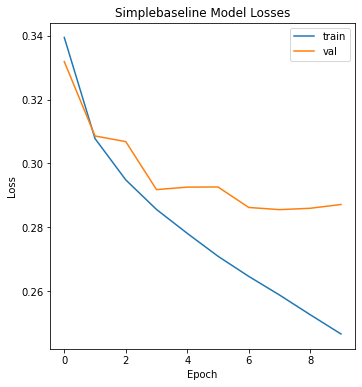

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# train, validation loss graph
plt.subplot(1, 2, 1)
plt.plot(sb_history['loss'])
plt.plot(sb_history['val_loss'])
plt.title('Simplebaseline Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

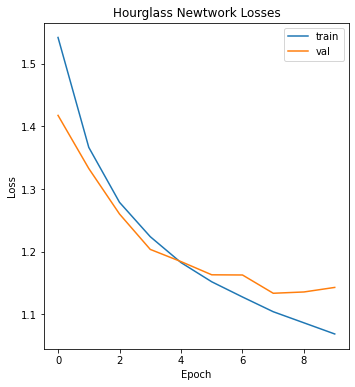

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# train, validation loss graph
plt.subplot(1, 2, 2)
plt.plot(hg_history['loss'])
plt.plot(hg_history['val_loss'])
plt.title('Hourglass Newtwork Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### (5) 모델 prediction

In [29]:
SB_WEIGHTS_PATH = os.path.join(MODEL_PATH, 'simple_baseline-epoch-8-loss-0.2856.h5')

sb_model = Simplebaseline(IMAGE_SHAPE)
sb_model.load_weights(SB_WEIGHTS_PATH)

In [30]:
HG_WEIGHTS_PATH = os.path.join(MODEL_PATH, 'stacked_hourglass-epoch-8-loss-1.1336.h5')

hg_model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
hg_model.load_weights(HG_WEIGHTS_PATH)

In [31]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [32]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [33]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [34]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [50]:
def draw_keypoints_on_image(image, keypoints, index=None):
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
#     plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
#     plt.show()

In [52]:
test_images = ['test_image.jpg', 'positano.jpg', 'barcelona.jpg']

- Simplebaseline model 결과

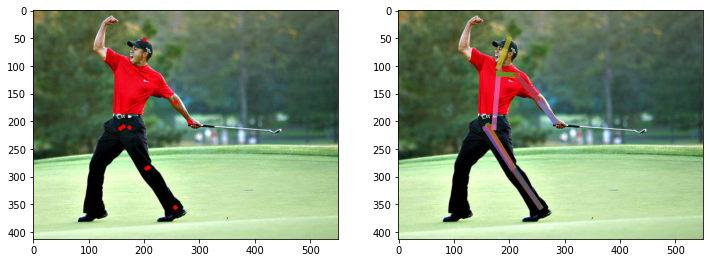

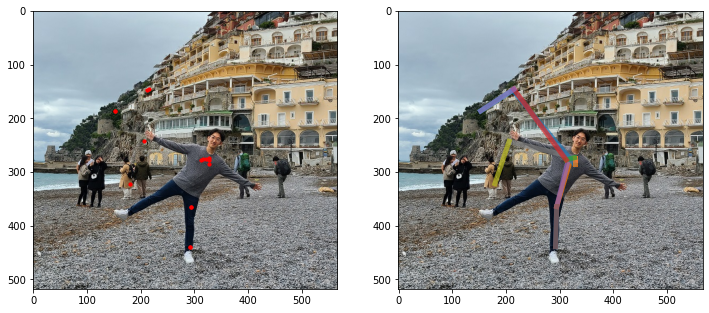

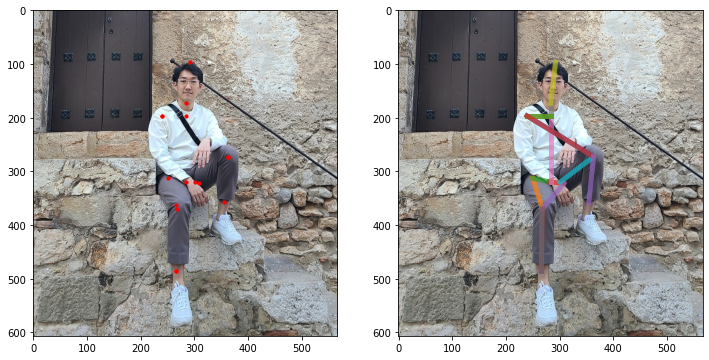

In [55]:
for t_img in test_images:
    test_image = os.path.join(os.getcwd(), 'sample_data', t_img)

    image, keypoints = predict(sb_model, test_image)
    plt.figure(figsize=(12, 6))
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)
    plt.show()

- Hourglass Network 결과

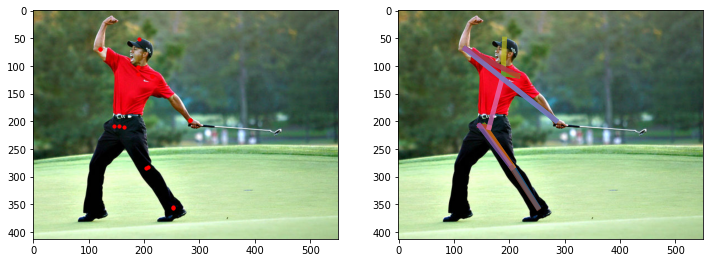

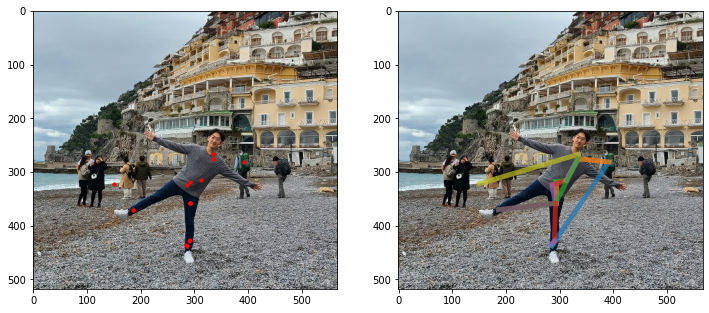

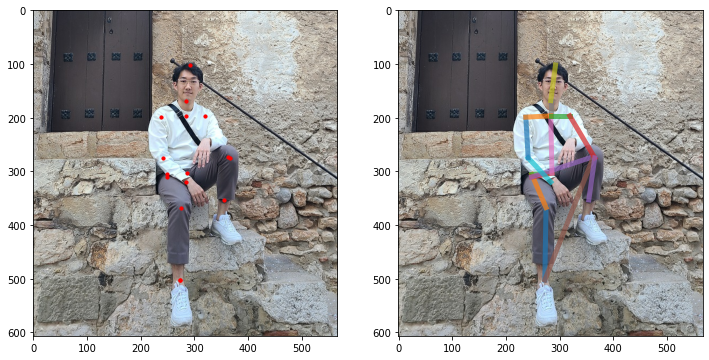

In [56]:
for t_img in test_images:
    test_image = os.path.join(os.getcwd(), 'sample_data', t_img)

    image, keypoints = predict(hg_model, test_image)
    plt.figure(figsize=(12, 6))
    draw_keypoints_on_image(image, keypoints)
    draw_skeleton_on_image(image, keypoints)
    plt.show()

### (6) 회고

- Simplebaseline model을 학습시킬 때 trainer의 compute_loss에서 error가 발생하였다.
- type 통일이 되지 않아서 생긴 문제인 것 같은데, for문을 제거하였더니 코드가 잘 돌아갔다.
```python
# for문 제거한 부분
def compute_loss(self, labels, outputs):
        loss = 0
#         for output in outputs:
        weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
        loss += tf.math.reduce_mean(
            tf.math.square(labels - outputs) * weights) * (
                1. / self.global_batch_size)
        return loss
```

- Simplebaseline model과 Hourglass Network 모두 10 epoch 씩 학습하였다.
- 둘 다 결과가 꽤 잘 나왔고, 서로 결과가 비슷하기도 하다.
- 다만, simplebaseline model은 hourglass network 보다는 성능이 조금 떨어지는 것 같았다.

- 앉아있는 이미지의 경우에는 괜찮은 결과를 냈지만 기울어진 이미지의 경우에는 결과를 잘 내지 못했다.
- data augmentation이 없어서 생긴 문제점이라고 생각한다.

- 10 epoch 학습한 결과임에도 생각보다 잘 결과를 낸 것 같았다.
- 더 많은 epoch으로 학습한 경우에는 어떤 결과를 나타낼지 궁금하다.